<a href="https://colab.research.google.com/github/Themis-Sot/datam/blob/main/DataMining_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Τεχνικές Εξόρυξης Δεδομένων
### Εργασία 1, Εαρινό Εξάμηνο 2021



**Θεμιστοκλής Σωτηρόπουλος 1115201400197**

**Δημήτριος Μπέρος 1115201600269**




*Προετοιμασία*


In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import pandas as pd
import random
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


*Διάβασμα αρχείου Netflix*

In [38]:
netflix = pd.read_csv('/content/gdrive/MyDrive/netflix_titles.csv')

*Διάβασμα αρχείου IMDB Movies*

In [39]:
imdb_movies = pd.read_csv('/content/gdrive/MyDrive/IMDb movies.csv', low_memory=False)

*Διάβασμα αρχείου IMDB Ratings*

In [40]:
imdb_ratings = pd.read_csv('/content/gdrive/MyDrive/IMDb ratings.csv', low_memory=False)

**Σε αυτό το σημείο να τονίσουμε ότι αφήσαμε τα αρχεία όπως έχουν ακόμα και στα σημεία που είχαν NaN τιμές. Έτσι έχουμε (έστω και λιγότερες) πληροφορίες για όλες τις ταινίες. Σε κάθε ερώτημα όμως, ανάλογα με αυτό που ψάχνουμε, κάνουμε drop τα rows εκείνα που έχουν NaN τιμή στο column που μας ενδιαφέρει για καλύτερα αποτελέσματα**

#Α. Ερωτήματα

**Ερώτημα 1:**
*Ποιό είδος υπερτερεί, οι ταινίες ή οι σειρές ;*

Αναζητήσαμε με βάση τη στήλη type ποιο από τα 2 είδη έχει τις περισσότερες εμφανίσεις


In [41]:
num_movies = netflix.loc[netflix['type']=='Movie'].count().max()
num_shows = netflix.loc[netflix['type']=='TV Show'].count().max()
if num_movies > num_shows:
    print('Υπερτερούν οι ταινίες με αριθμό:', num_movies)
else:
    print('Υπερτερούν οι σειρές με αριθμό', num_show)

Υπερτερούν οι ταινίες με αριθμό: 5377


**Ερώτημα 2:**
*Τα τελευταία χρόνια το netflix επενδύει περισσότερο σε ταινίες ή σε σειρές;*

Στο ερώτημα αυτό δε σκεφτήκαμε να λάβουμε υπόψιν στη διαδικασία της αναζήτησης τη στήλη budget, μιας και μας φάνηκε αρκετό το να υπολογίσουμε για κάθε έτος πόσες ταινίες και πόσες σειρές αντίστοιχα κυκλοφορεί το Netflix.

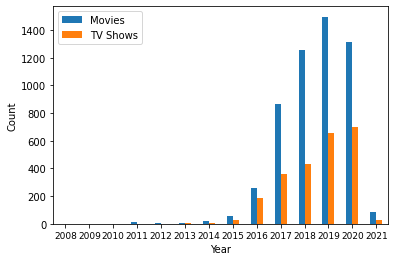

In [42]:
tempDF = netflix.dropna(axis=0, subset=['date_added'])

#Σπάσιμο του date_added και αποθήκευση μόνο του έτους
for x, y in tempDF.iterrows():
    date = str(y['date_added'])
    year = date.split(", ")
    tempDF.at[x, 'date_added'] = year[-1]

#Αναζήτηση ανά έτος και υπολογισμός πλήθους ταινιών και σειρών
dates = tempDF.groupby('date_added')
latest = dates['type'].value_counts()

#Αποθήκευση του πλήθους ανά έτος σε ένα dictionary
LY = {}
for x, y in latest.iteritems():
    if x[0] not in LY:
        LY[x[0]] = []
    LY[x[0]].append(y)

#Δημιουργία νέου dataframe με τα παραπάνω αποτελέσματα, συμπλήρωση κενών πεδίων και εμφάνιση αποτελεσμάτων στο plot
df1 = pd.DataFrame.from_dict(LY, orient='index', columns=['Movies', 'TV Shows']).fillna(0).astype({'Movies': int, 'TV Shows': int})
df1.plot.bar(rot=0)
mpl.pyplot.ylabel('Count')
mpl.pyplot.xlabel('Year')
mpl.pyplot.tick_params(axis='x', which='major', labelsize=9)

**Ερώτημα 3:**
*Ποιά χώρα έχει το περισσότερο περιεχόμενο;*

Αποφασίσαμε να βρούμε τη χώρα με τις περισσότερες παραγωγές ανεξαρτήτου είδους

In [43]:
temp = netflix.dropna(axis=0, subset=['country'])

#Συνάρτηση η οποία παίρνει ως όρισμα ένα dataframe και ένα column και σπάει όλα τα rows 
#εκείνα που έχουν στη στήλη column παραπάνω από μία τιμή, χωρισμένες με κόμμα
#Επίσης καθαρίζει και εκείνες τις τιμές που έχουν κόμμα στο τέλος π.χ. "United States,"
#Τα χωρισμένα καινούρια rows τα βάζει σε μια λίστα και δημιοργεί ένα καινούριο dataframe, το οποίο και επιστρέφει
#Αν έχουμε στη στήλη country: United Kingdom, Poland θα σπάσει σε 2 γραμμές με τις 2 χώρες αντίστοιχα

def split_df_rows(temp_df, column):
    row_accumulator = []
    def split_list_to_rows(row):
        split_row = re.split(', |[,](?!\s)', str(row[column]))
        if isinstance(split_row, list):
            for s in split_row:
                if s != '':
                    new_row = row.to_dict()
                    new_row[column] = str(s)
                    row_accumulator.append(new_row)
        else:
            new_row = row.to_dict()
            new_row[column] = str(split_row)
            row_accumulator.append(new_row)

    temp_df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
    return new_df

#Ξεχώρισμα των διαφορετικών χωρών και υπολογισμός πλήθους μοναδικών τιμών
temp = split_df_rows(temp, 'country')
top_country = temp['country'].value_counts().index[0]
top_value = temp['country'].value_counts()[0]
print("Η χώρα με το περισσότερο περιεχόμενο είναι:",top_country,"με",top_value, "παραγωγές")

Η χώρα με το περισσότερο περιεχόμενο είναι: United States με 3297 παραγωγές


**Ερώτημα 4:**
*Τι είδους περιεχόμενο έχει κάθε χώρα;*

In [44]:
#Προετοιμασία αρχείων έτσι ώστε κάθε γραμμή να περιέχει μία και μόνο χώρα στη στήλη country
genre_netflix=netflix.dropna(axis=0, subset=['country', 'listed_in'])
genre_netflix=split_df_rows(genre_netflix, 'listed_in')
genre_netflix=split_df_rows(genre_netflix, 'country')

#Αναζήτηση ανά χώρα τα μοναδική είδη και αποθήκευση σε dictionary
countries_genres=genre_netflix.groupby('country')
genres = countries_genres['listed_in'].unique()
countryList = genres.index
genreDict = {}


for x in range(len(countryList)):
    if countryList[x] not in genreDict:
        genreDict[countryList[x]] = []
    for i in range(len(genres[x])):
        genreDict[countryList[x]].append(genres[x][i])

for x, y in genreDict.items():
    print('Η χώρα: ', x)
    print('Έχει περιεχόμενο: ',','.join(y),'\n')

Η χώρα:  Afghanistan
Έχει περιεχόμενο:  Documentaries,International Movies 

Η χώρα:  Albania
Έχει περιεχόμενο:  Dramas,International Movies 

Η χώρα:  Algeria
Έχει περιεχόμενο:  Classic Movies,Dramas,International Movies 

Η χώρα:  Angola
Έχει περιεχόμενο:  Action & Adventure,International Movies 

Η χώρα:  Argentina
Έχει περιεχόμενο:  Action & Adventure,Comedies,International Movies,Documentaries,Sports Movies,Dramas,Thrillers,Stand-Up Comedy,International TV Shows,Spanish-Language TV Shows,TV Comedies,Crime TV Shows,Independent Movies,Romantic Movies,Docuseries,Movies,Kids' TV,Horror Movies,TV Dramas,Cult Movies,Teen TV Shows,Children & Family Movies,Music & Musicals,LGBTQ Movies,Romantic TV Shows,Reality TV,Classic Movies,Sci-Fi & Fantasy,TV Horror 

Η χώρα:  Armenia
Έχει περιεχόμενο:  Documentaries,International Movies 

Η χώρα:  Australia
Έχει περιεχόμενο:  Docuseries,International TV Shows,Science & Nature TV,Children & Family Movies,Dramas,Sports Movies,Independent Movies,Inter

**Ερώτημα 5:**
*Ετοιμάστε γραφήματα που δειχνουν τους ηθοποιούς με τις περισσότερες ταινίες σε
κάθε χώρα. Κάντε το ίδιο και για τις σειρές*

Επιλέξαμε να εμφανίζουμε ένα γράφημα για κάθε χώρα, με τους 5 ηθοποιούς με περισσότερες ταινίες. Μετά το ίδιο για τις σειρές. Ο αριθμός των ηθοποιών που εμφανίζονται αλλάζει εύκολα αν απλώς αλλάξουμε το νούμερο στο iloc του sorted series.

*Για τις ταινίες:*

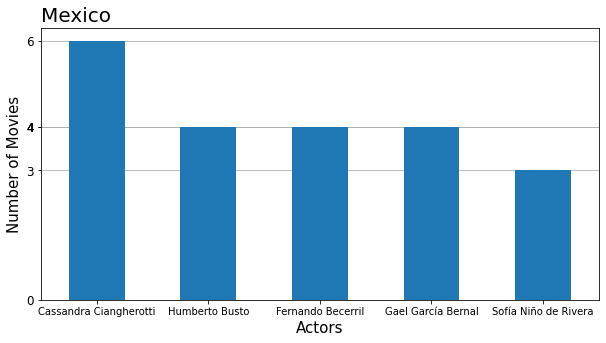

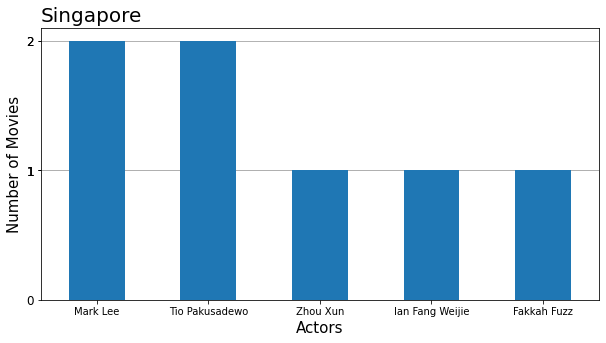

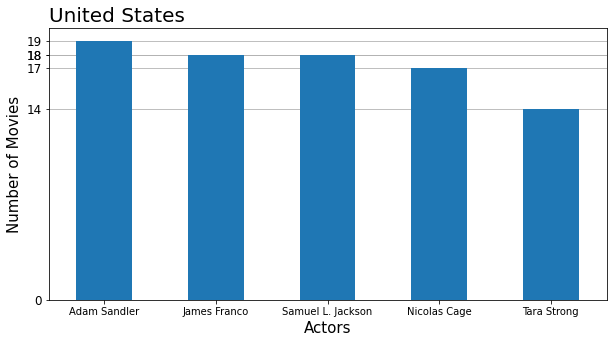

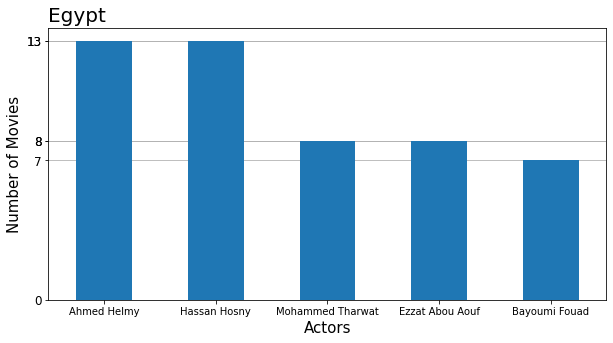

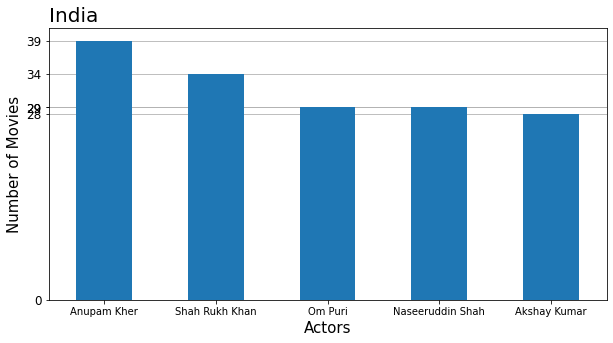

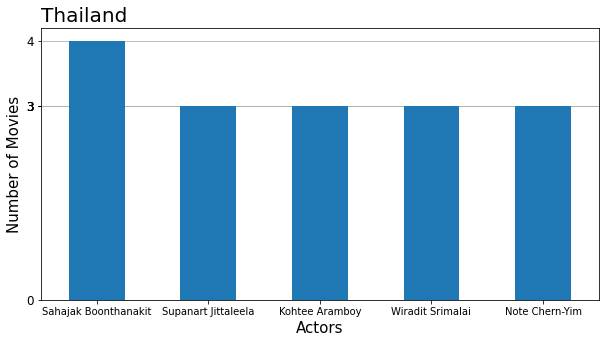

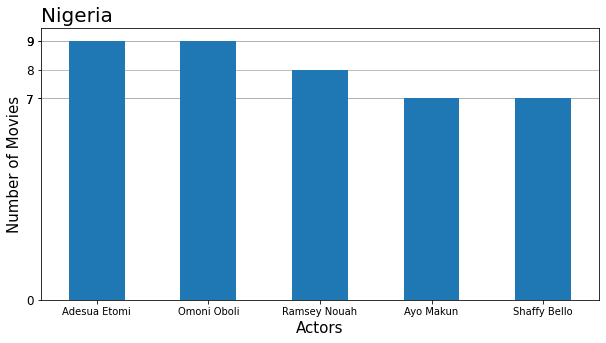

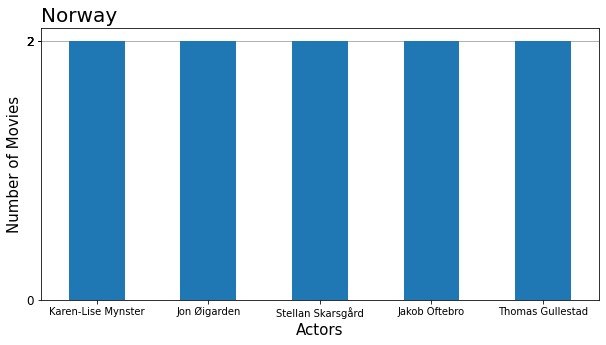

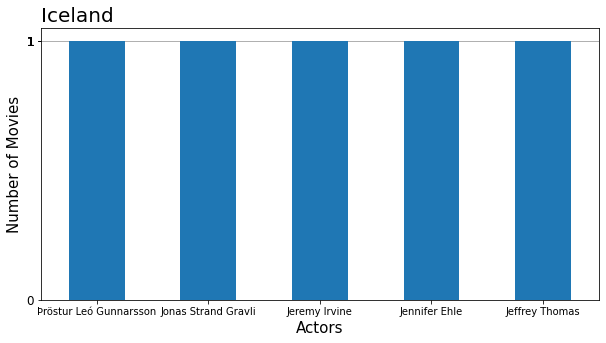

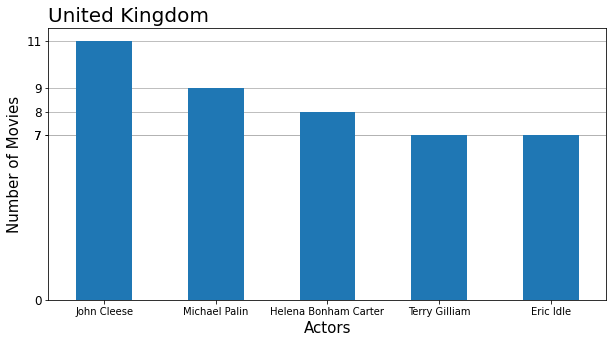

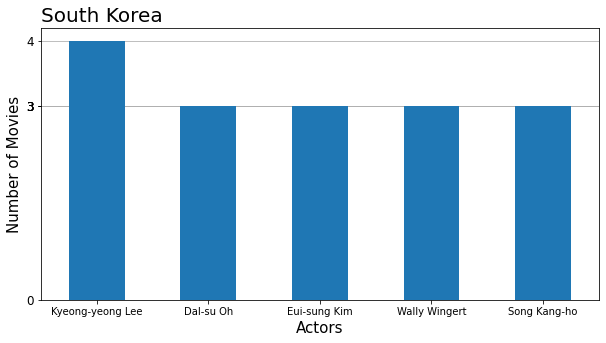

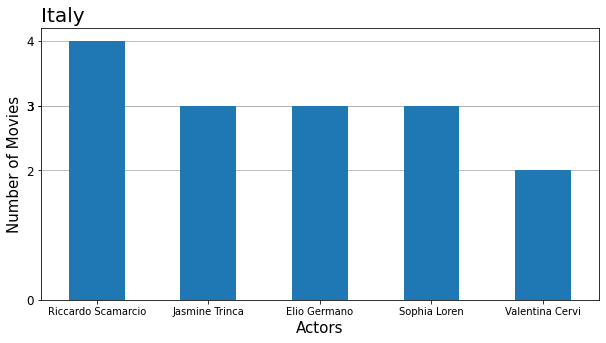

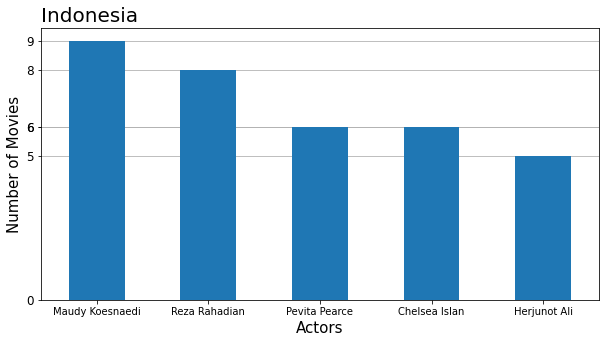

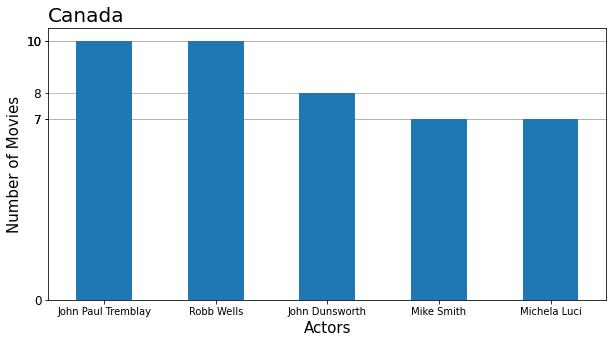

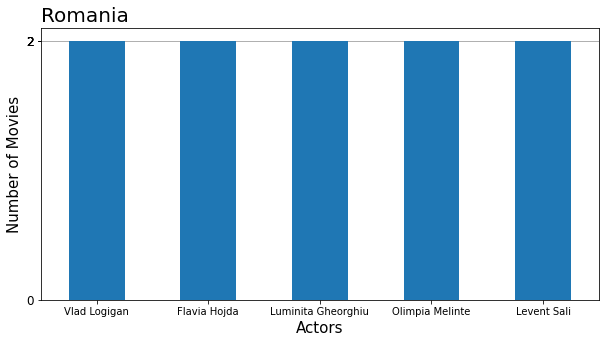

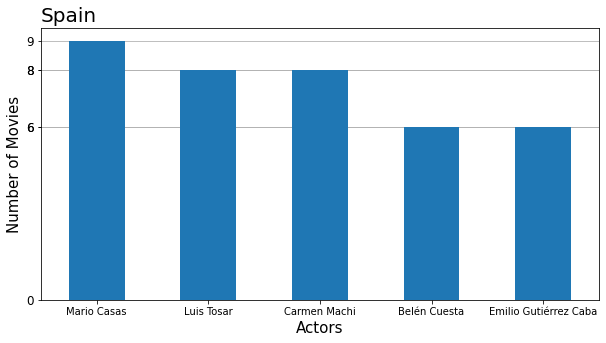

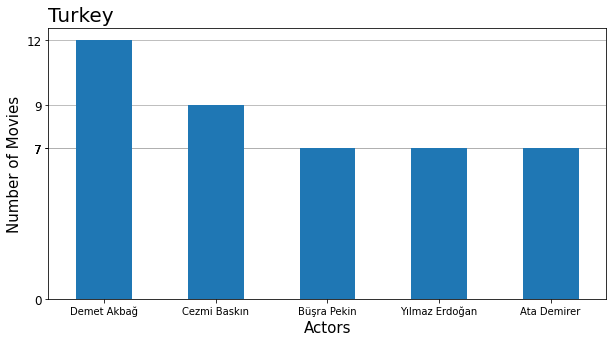

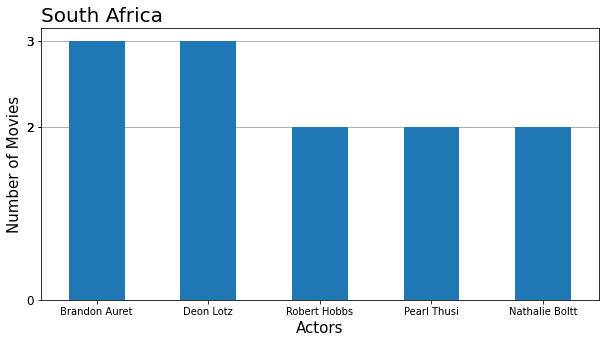

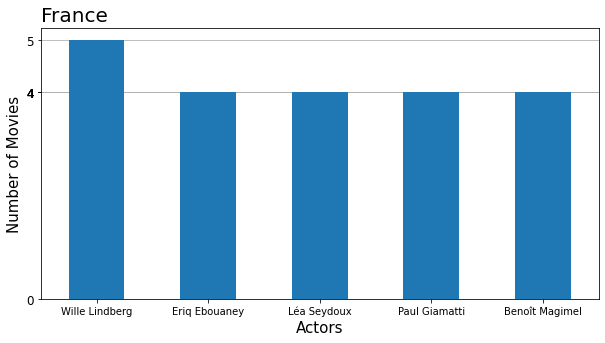

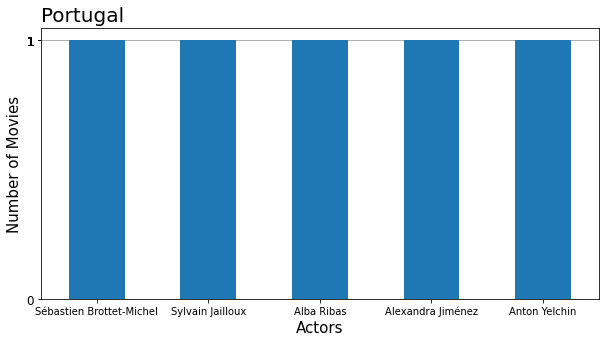

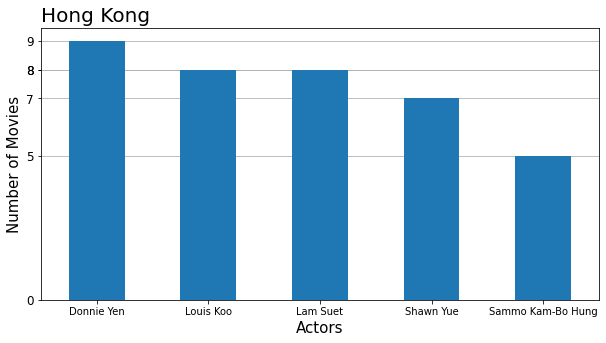

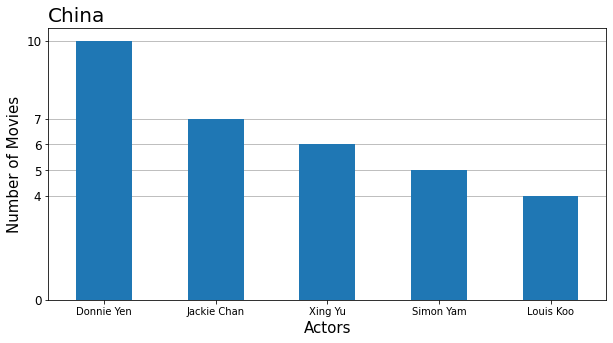

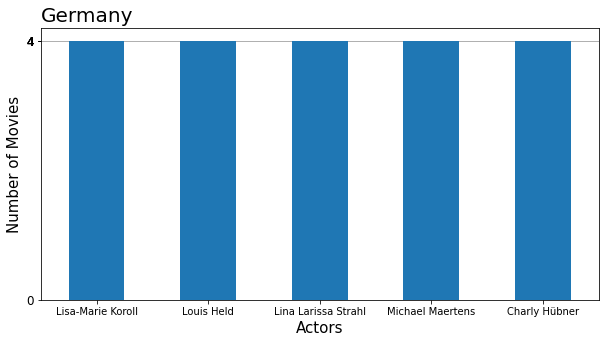

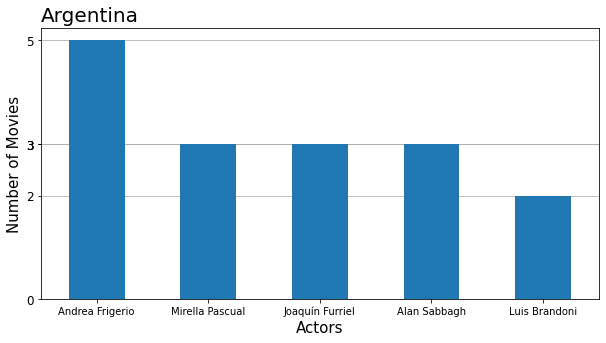

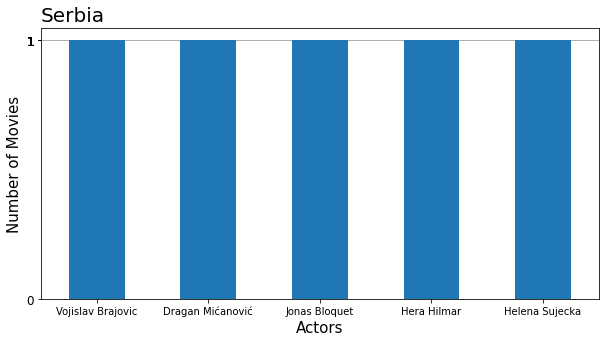

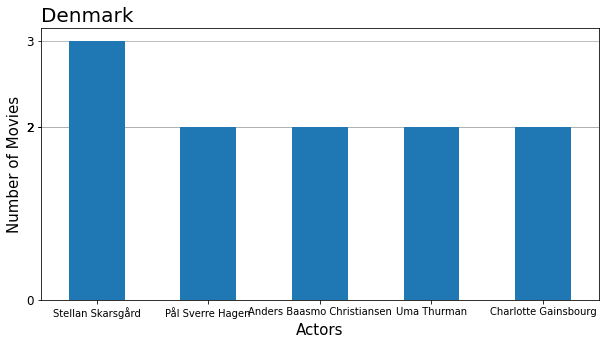

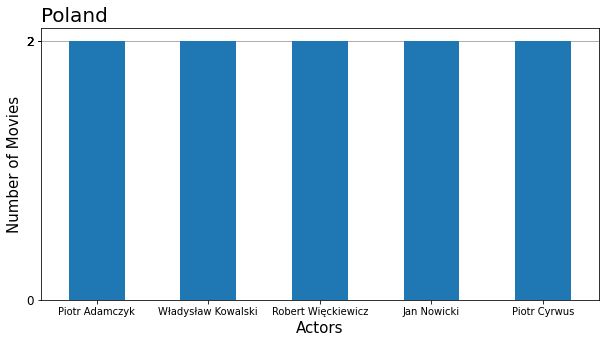

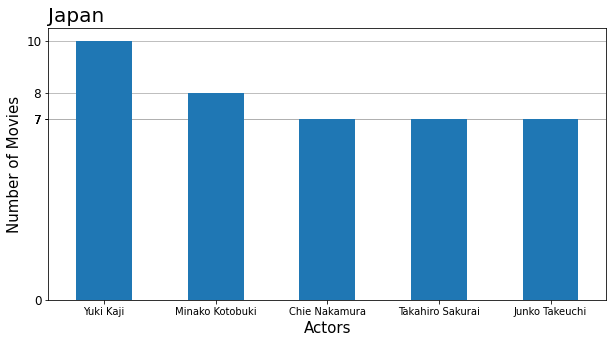

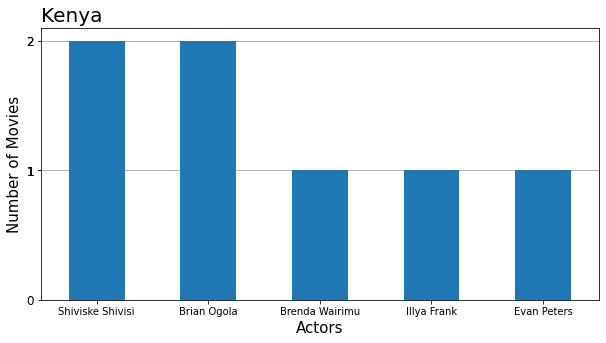

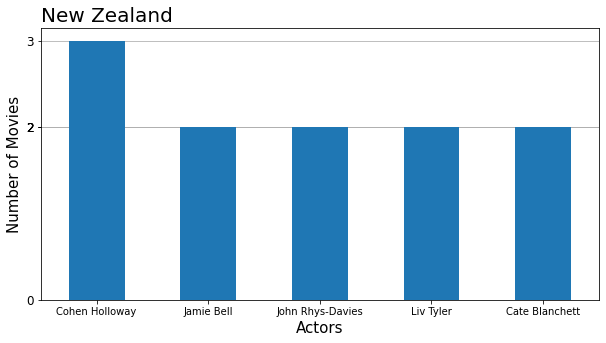

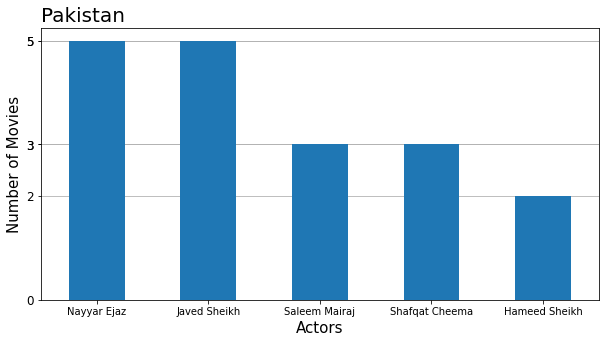

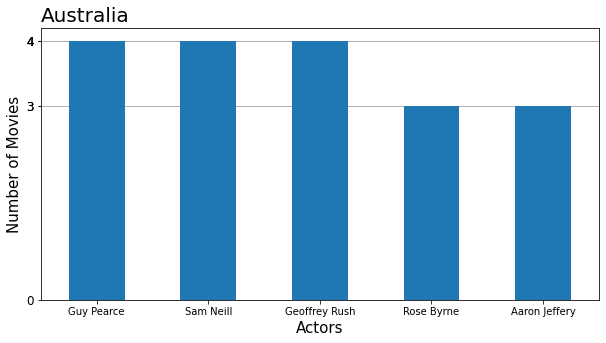

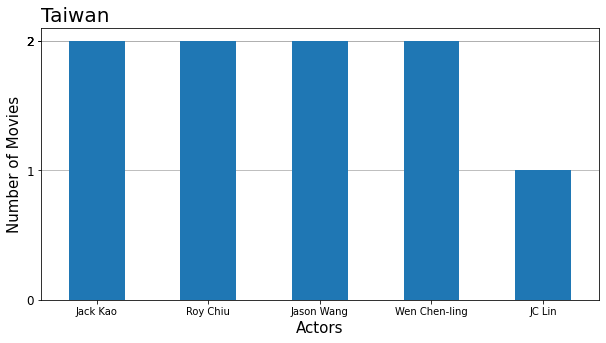

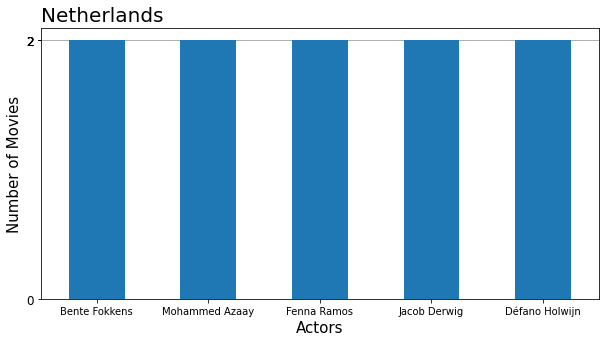

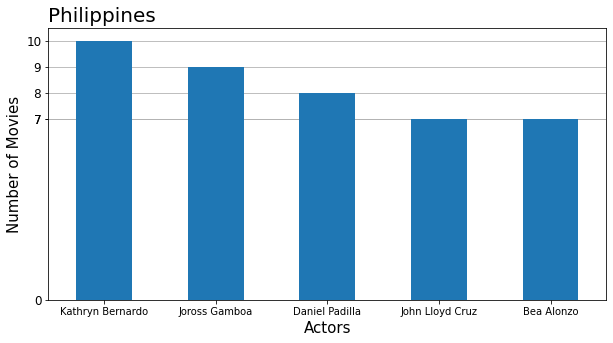

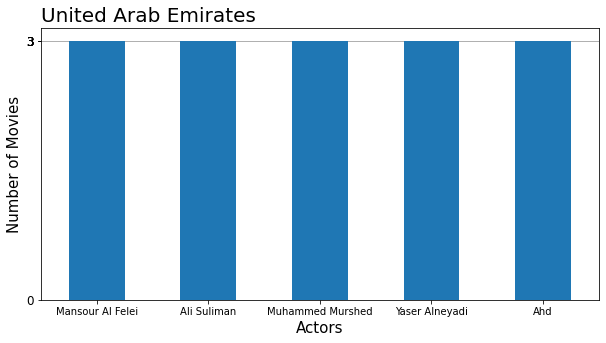

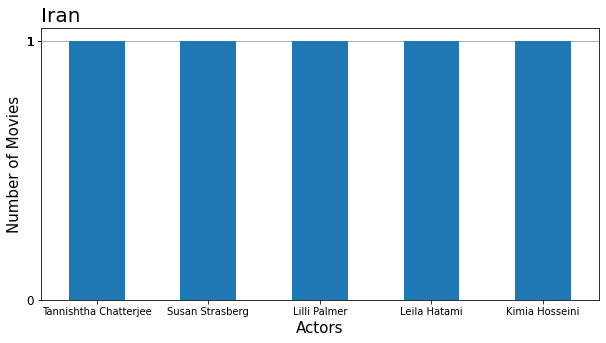

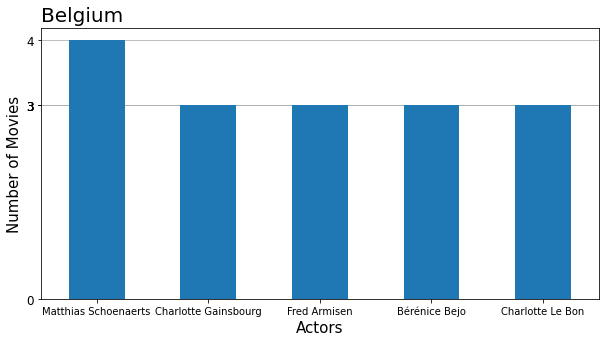

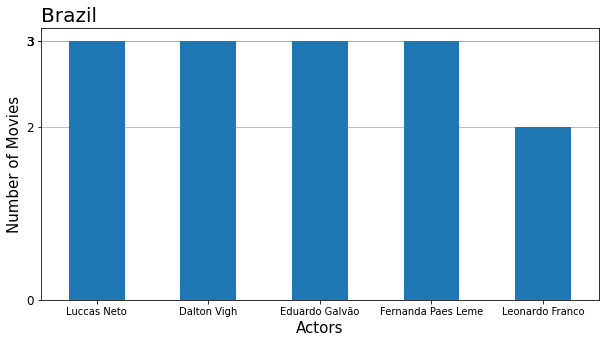

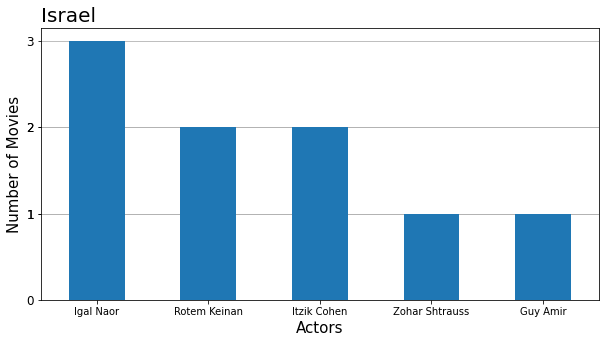

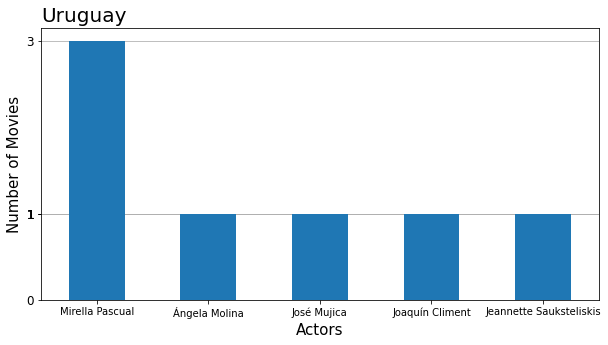

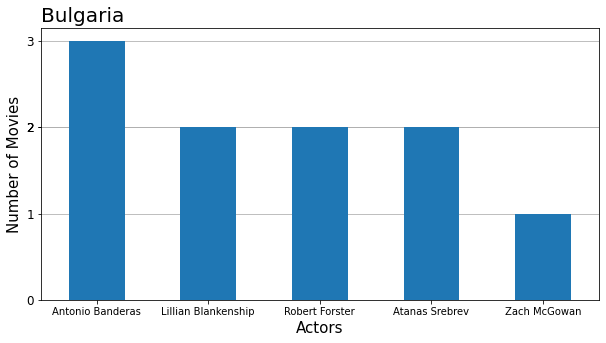

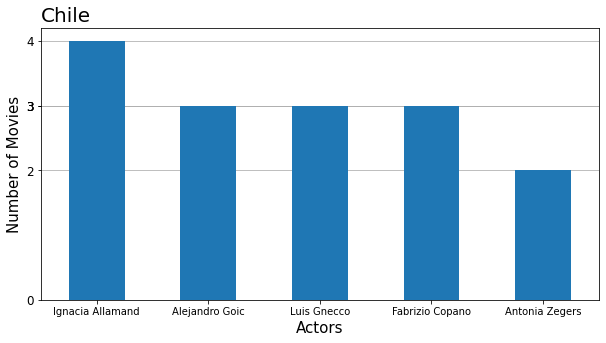

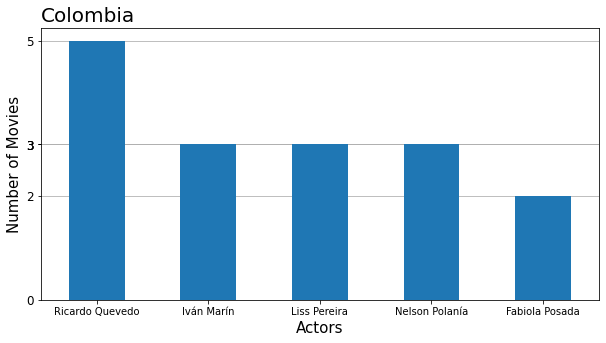

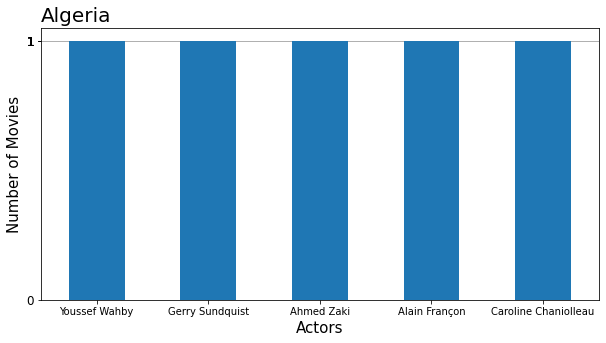

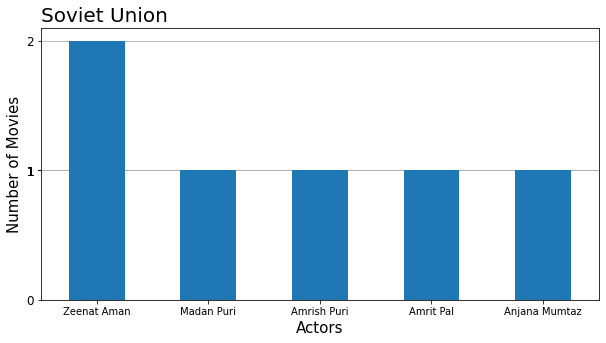

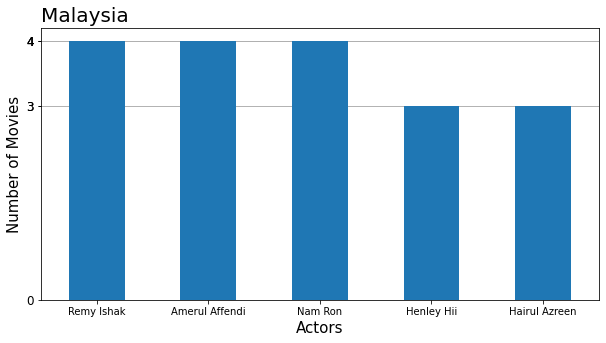

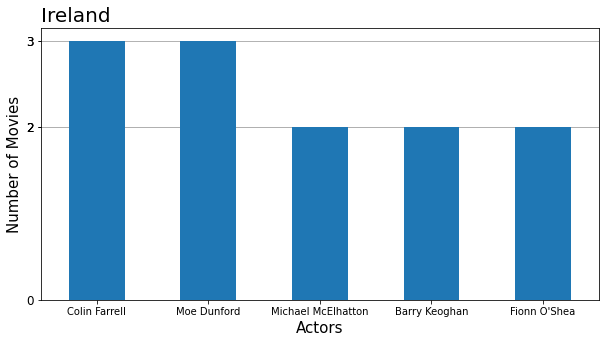

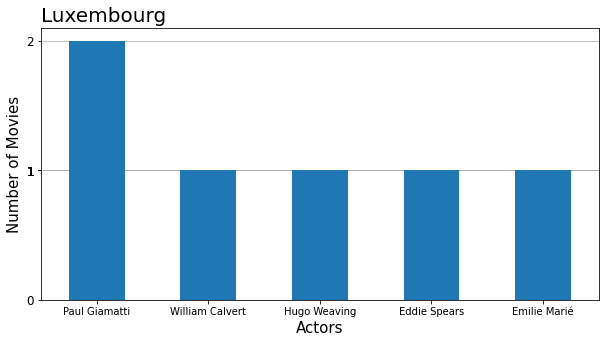

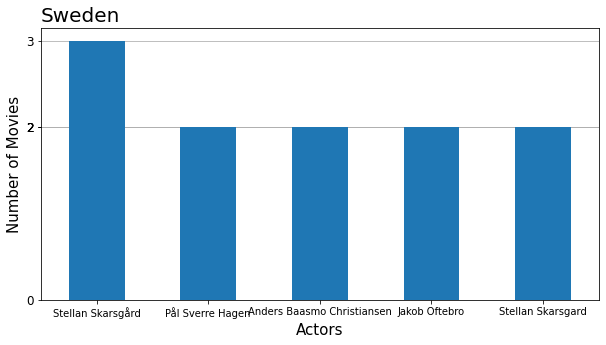

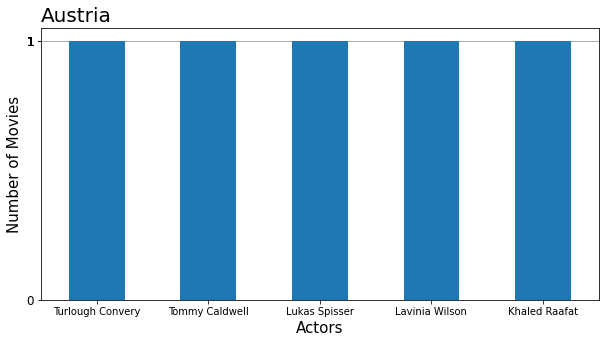

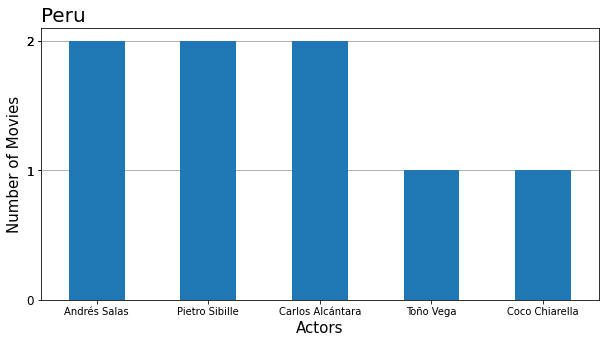

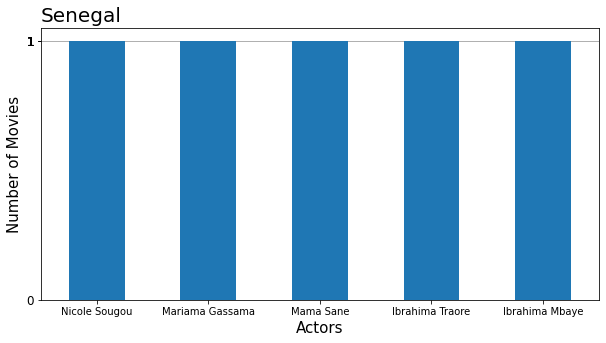

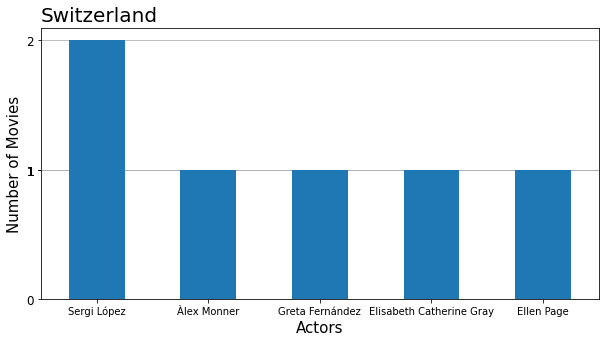

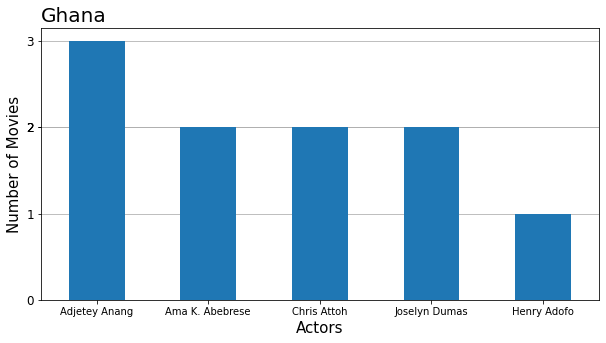

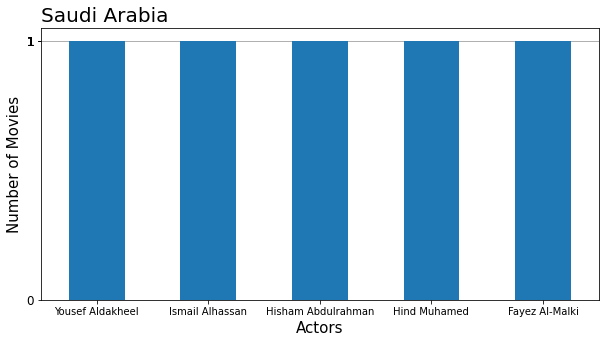

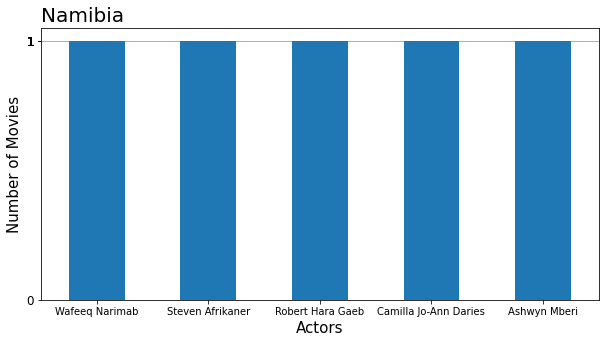

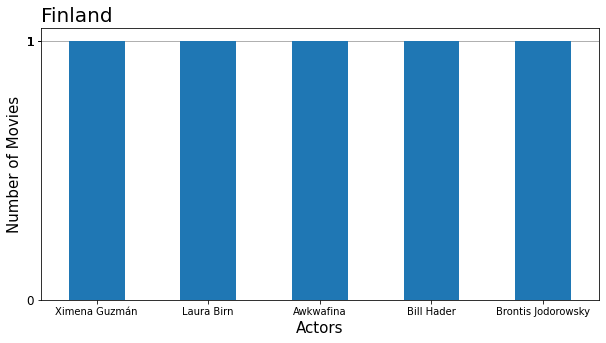

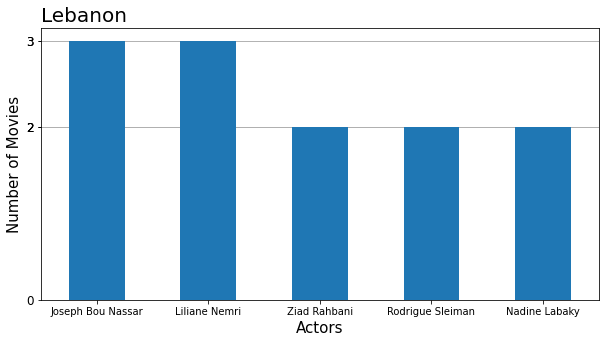

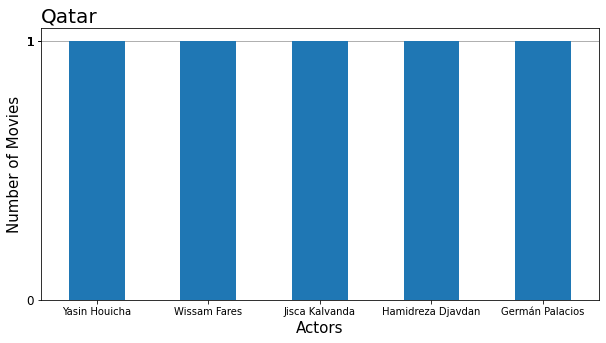

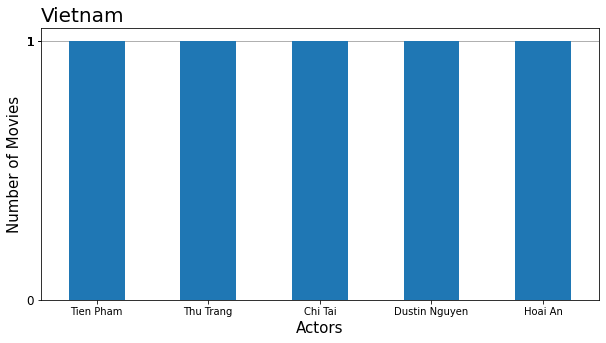

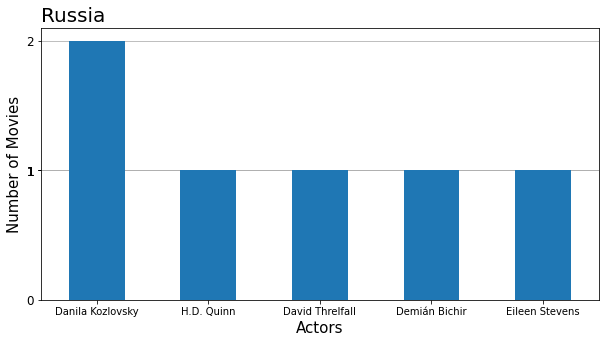

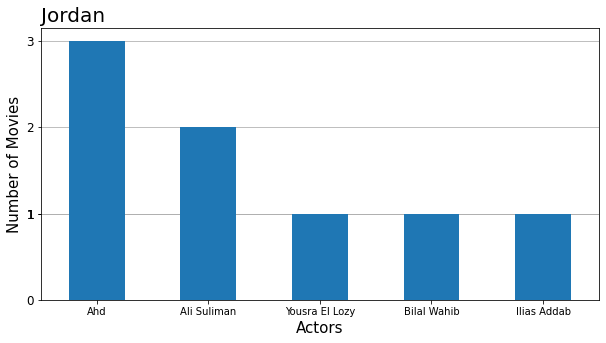

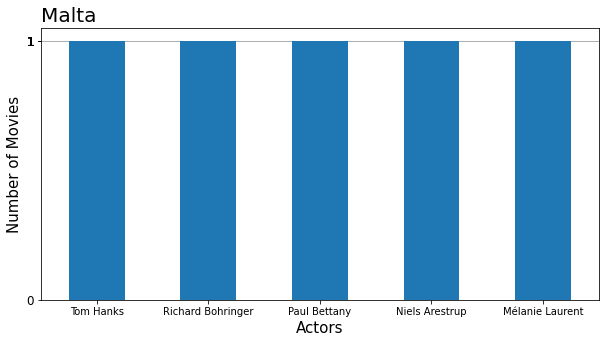

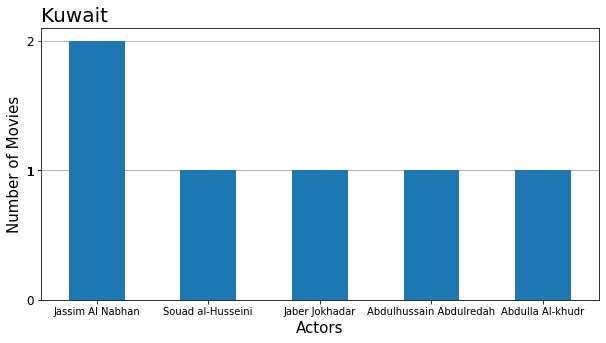

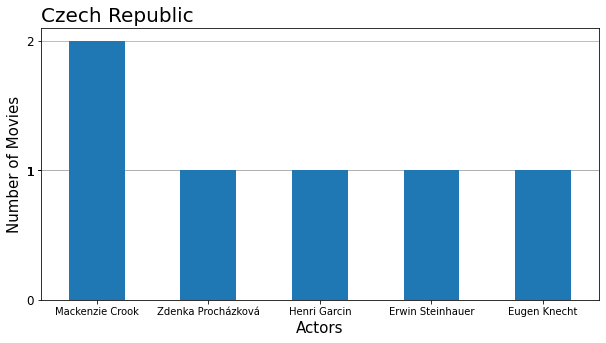

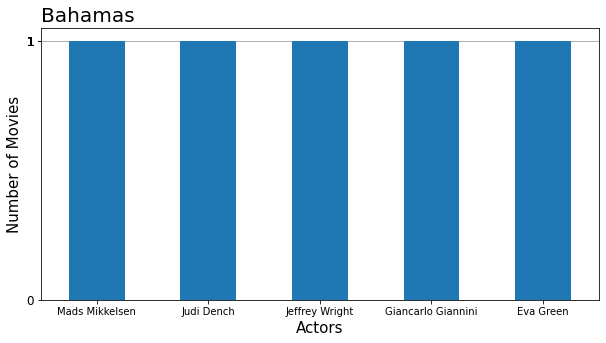

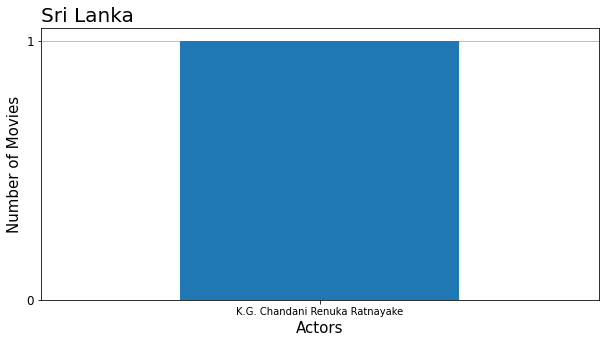

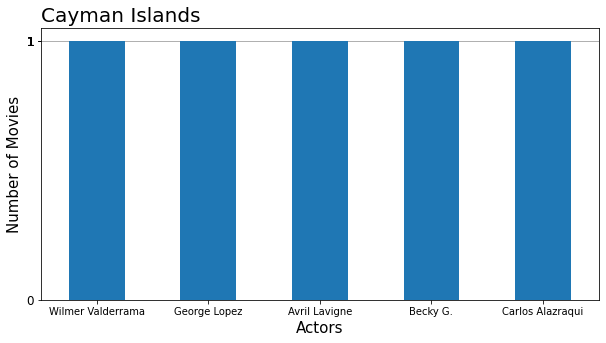

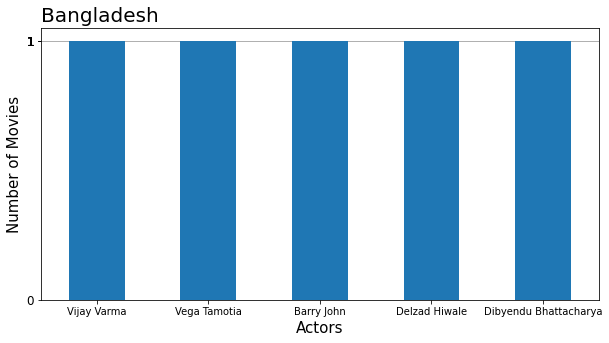

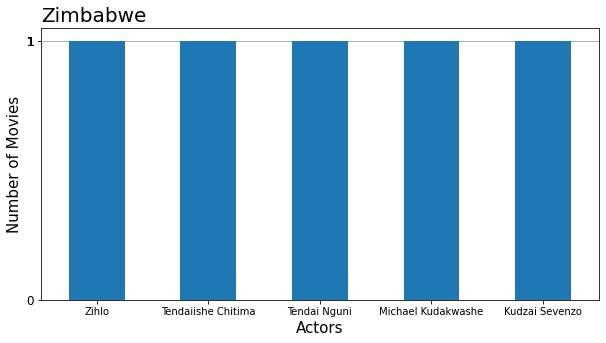

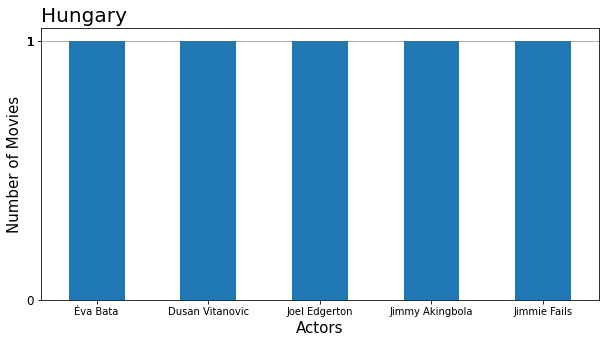

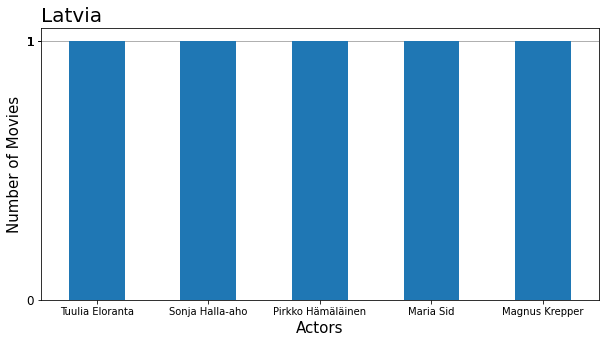

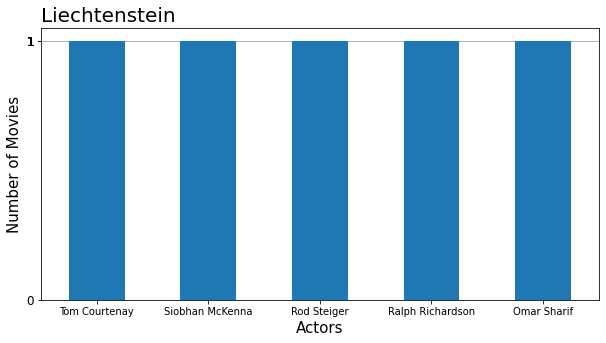

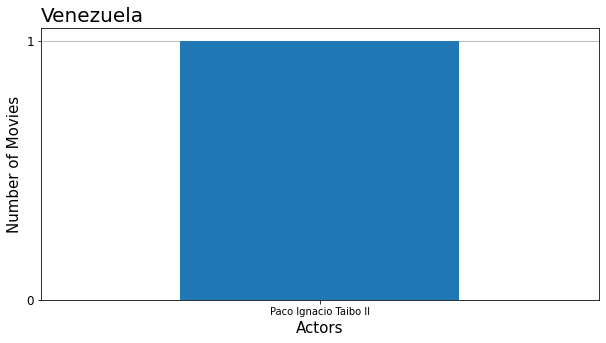

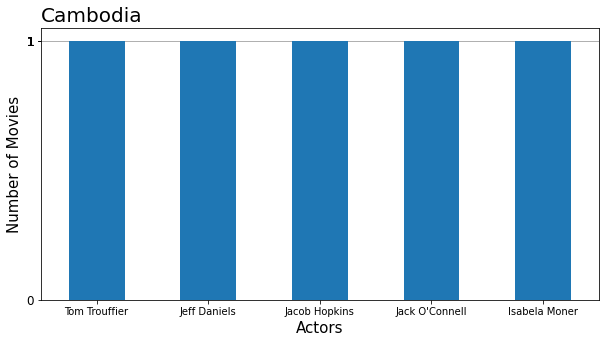

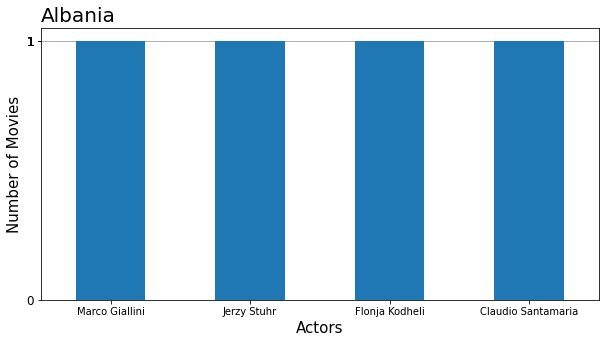

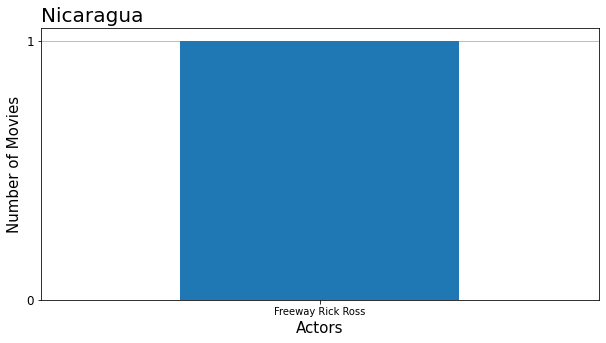

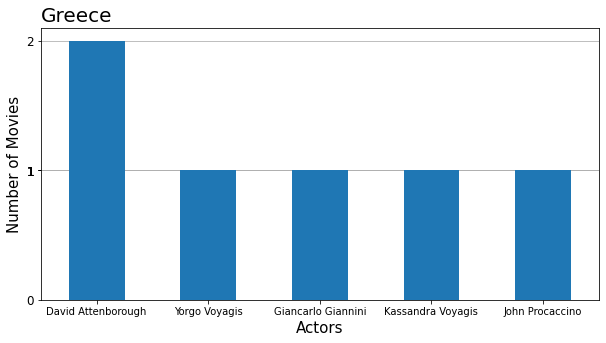

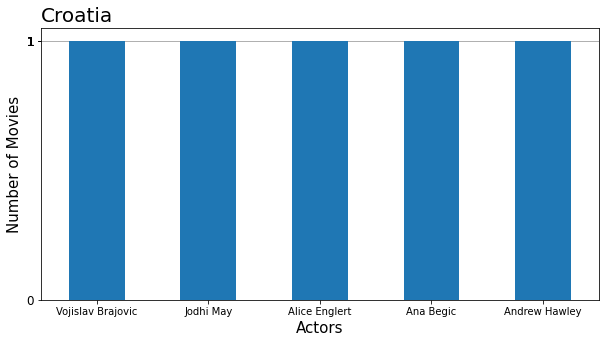

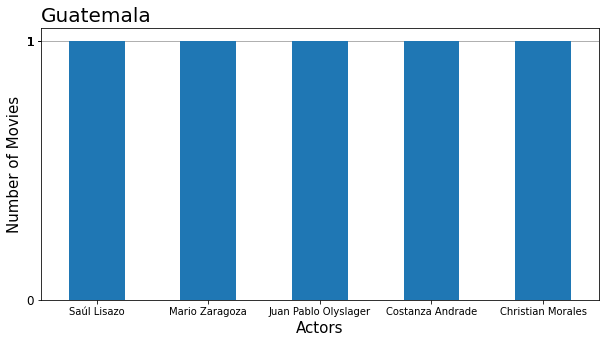

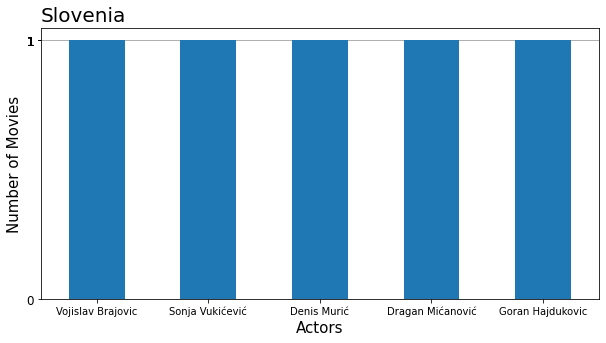

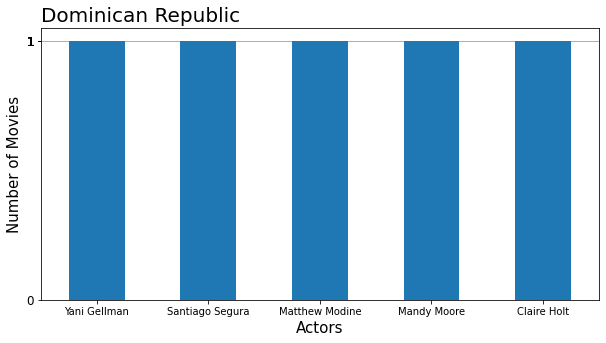

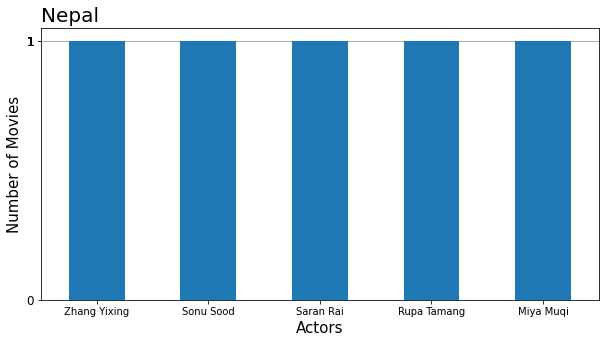

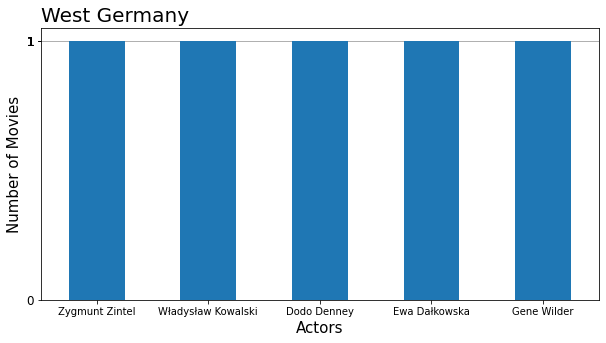

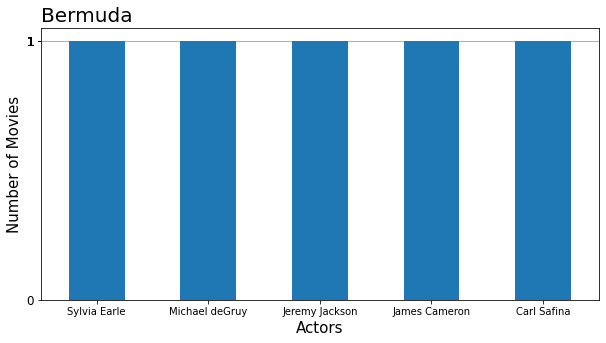

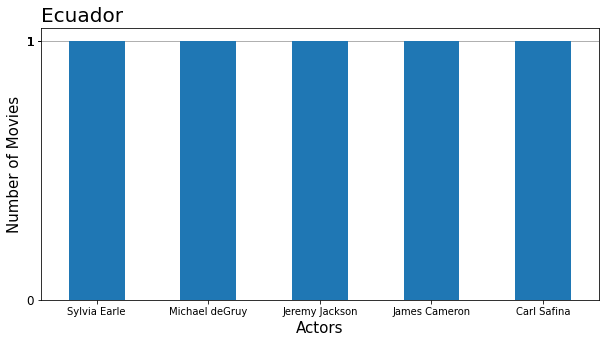

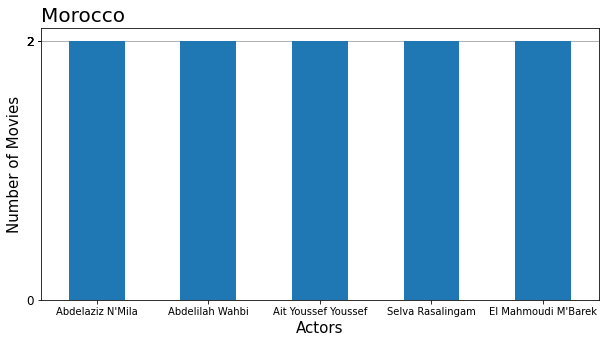

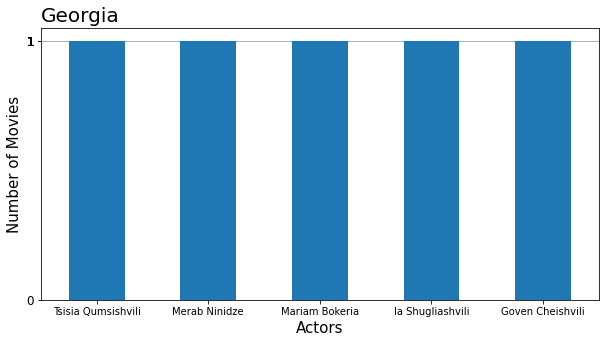

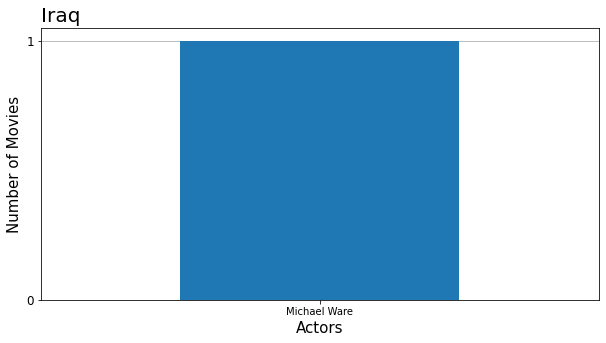

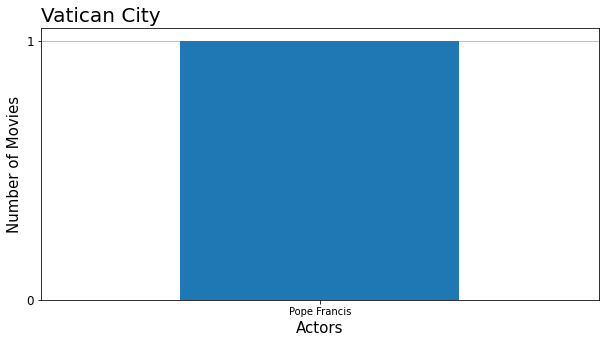

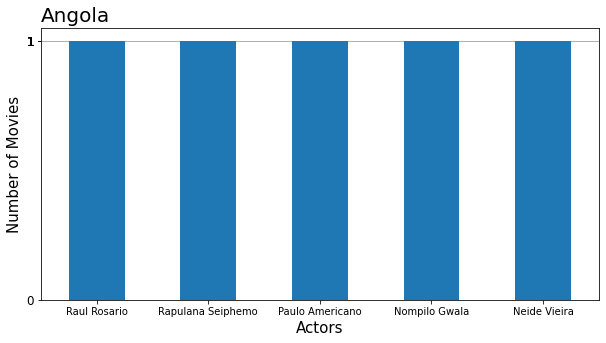

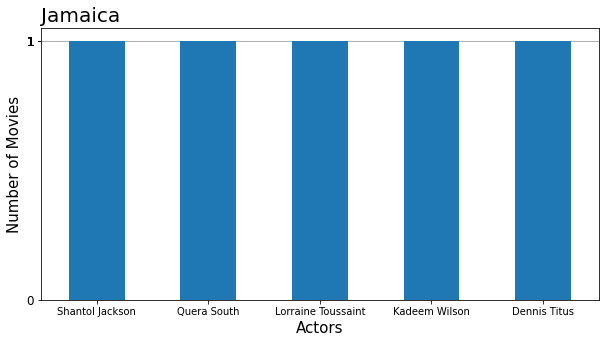

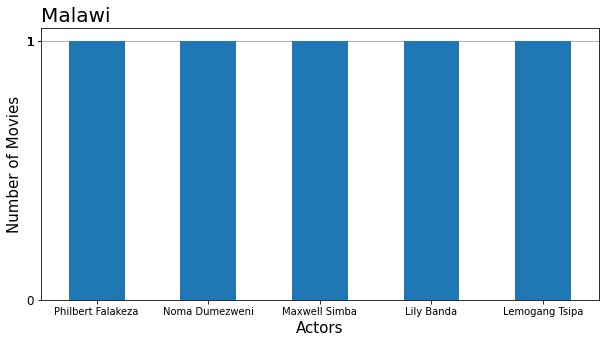

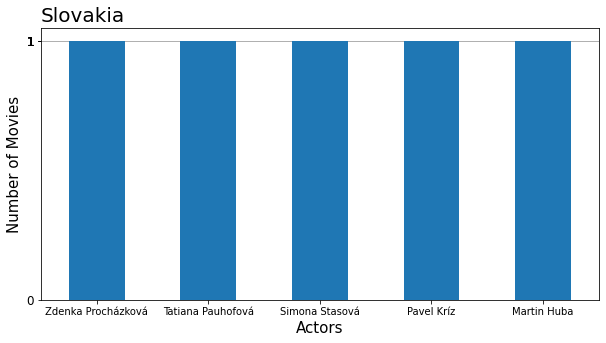

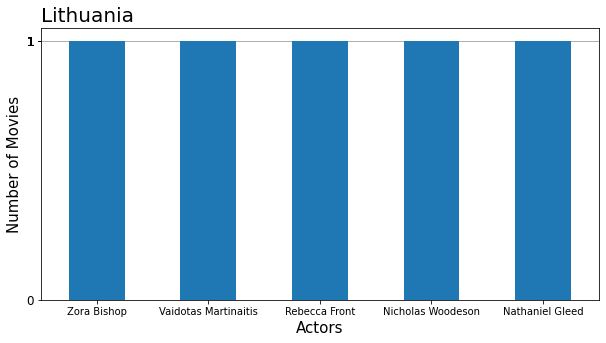

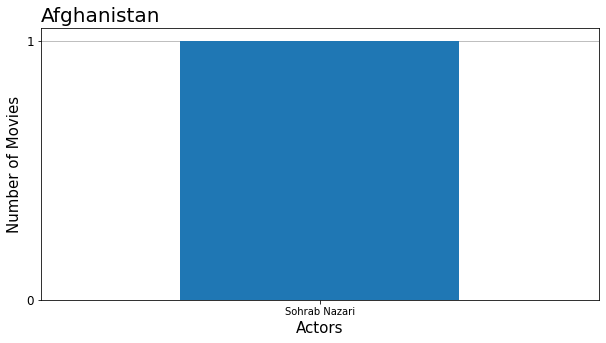

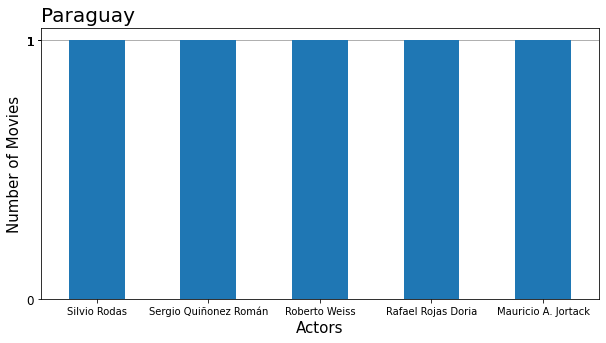

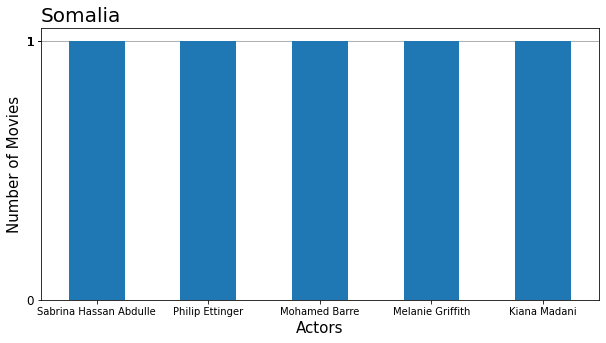

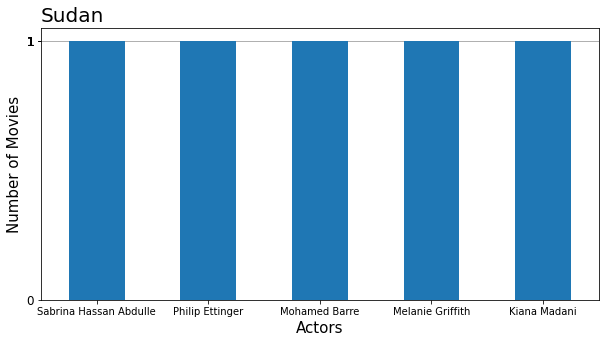

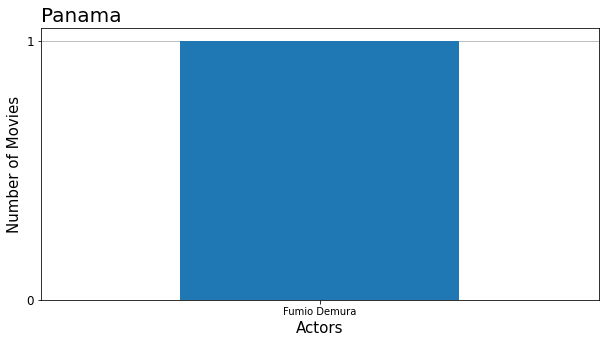

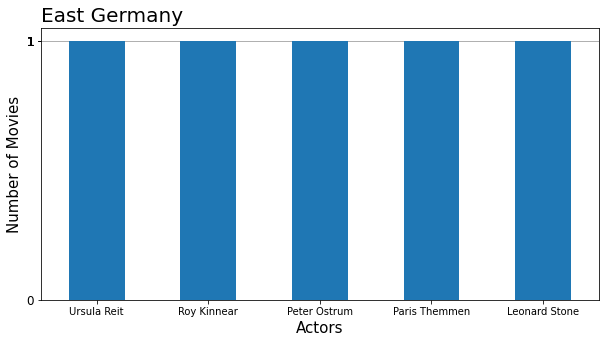

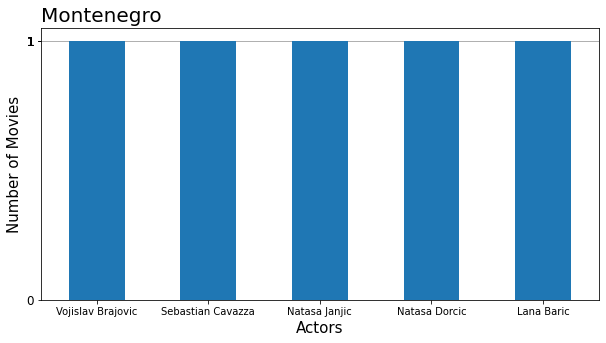

In [45]:

#Σπάσιμο των γραμμών έτσι ώστε να περιέχουν μία χώρα και έναν ηθοποιό μόνο
cmovies = netflix.loc[netflix['type']=='Movie']
ctmp = cmovies.dropna(axis=0,subset=['country', 'cast'])
ctmp = split_df_rows(ctmp,'country')
ctmp = split_df_rows(ctmp,'cast')

#Εύρεση μοναδικών χωρών
countries = ctmp['country'].unique()

#Για κάθε χώρα: εύρεση όλων των γραμμών που αντιστοιχούν σε αυτήν
#και αναζήτηση με βάση τους ηθοποιούς σε πόσα μοναδικά show_id εμφανίζονται
for x in countries:
    cDF = ctmp.loc[ctmp['country']==x]
    actors = cDF.groupby('cast')
    numActors = actors['show_id'].nunique()

    #Ταξινόμηση από το μεγαλύτερο προς το μικρότερο
    sorted = numActors.sort_values(ascending=False)
    s = sorted.iloc[:5]
    ylen = [0]

    for i in s:
        ylen.append(i)

    #Εμφάνιση αποτελεσμάτων στο γράφημα
    ax = s.plot.bar(rot=0, figsize=(10,5),zorder=3)
    plt.ylabel('Number of Movies', fontsize=15)
    plt.xlabel('Actors', fontsize=15)
    plt.title(x, fontsize=20, loc='left')
    ax.set_yticks(ylen)
    ax.yaxis.grid(True)
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.show()

*Για τις σειρές*

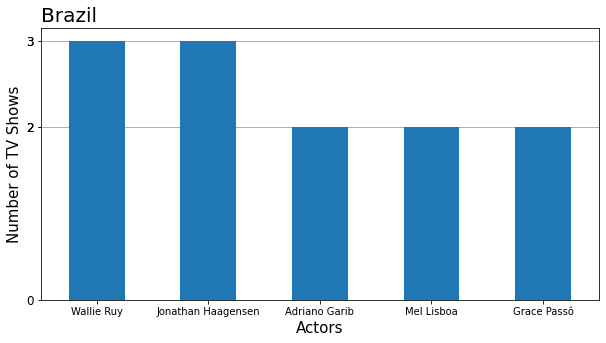

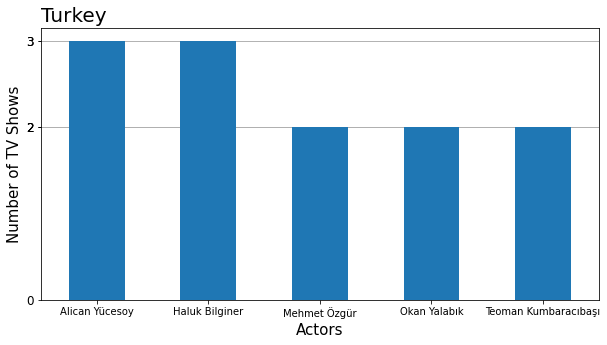

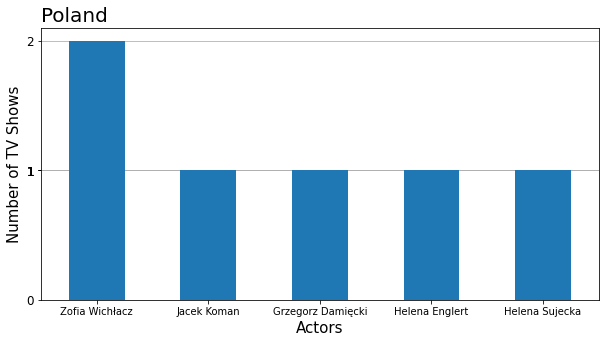

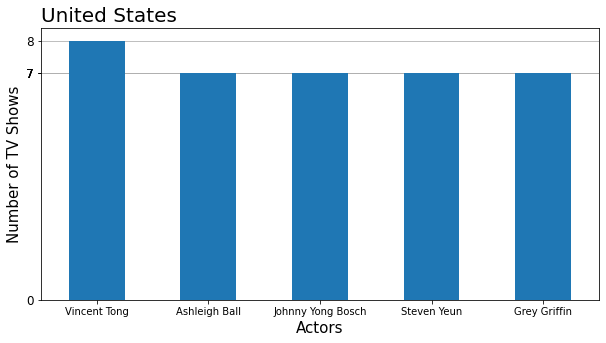

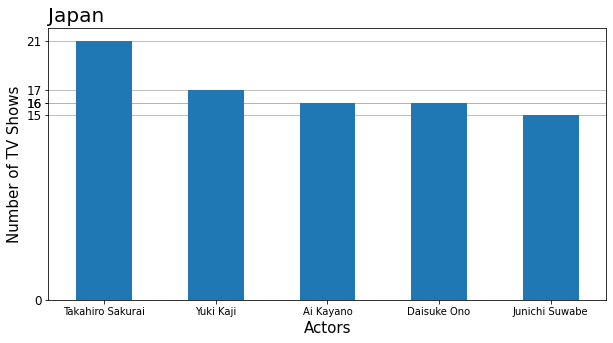

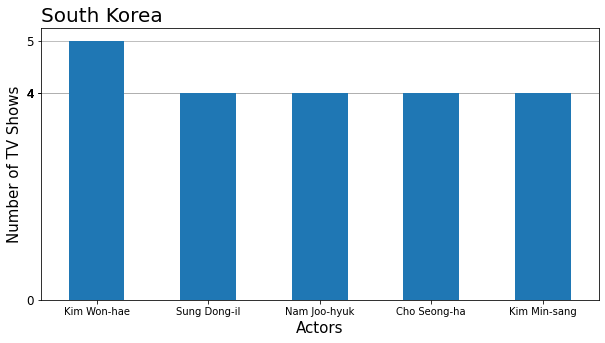

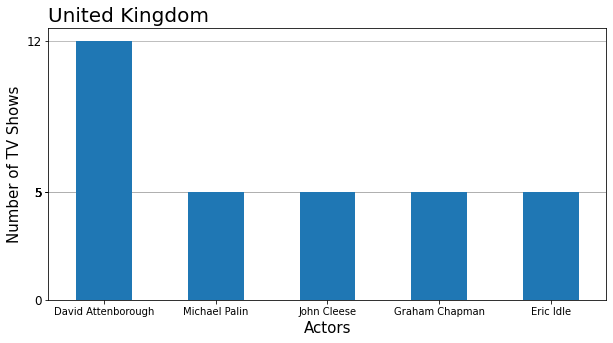

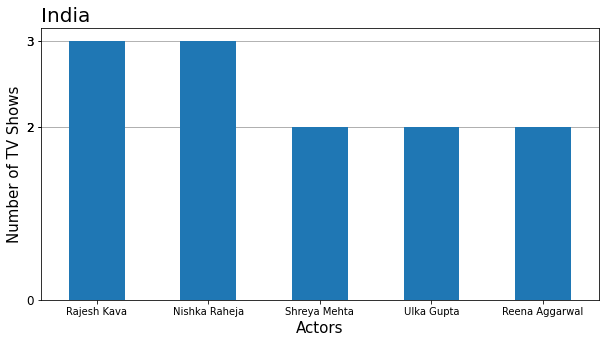

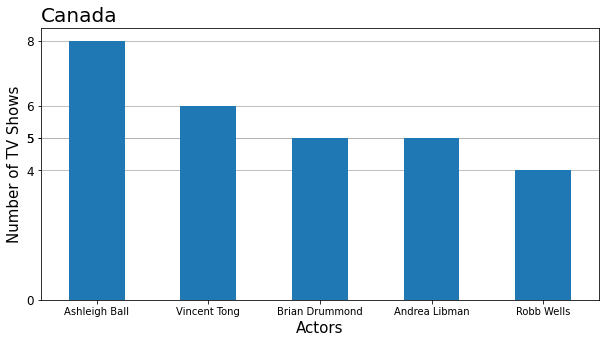

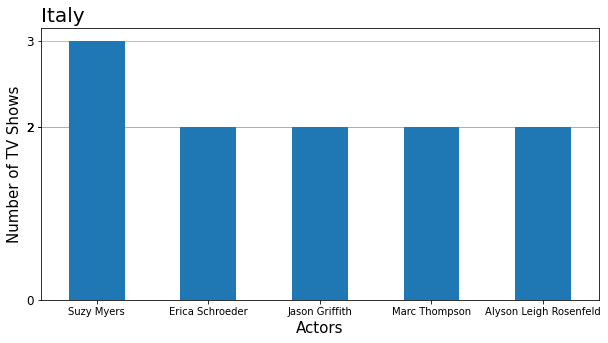

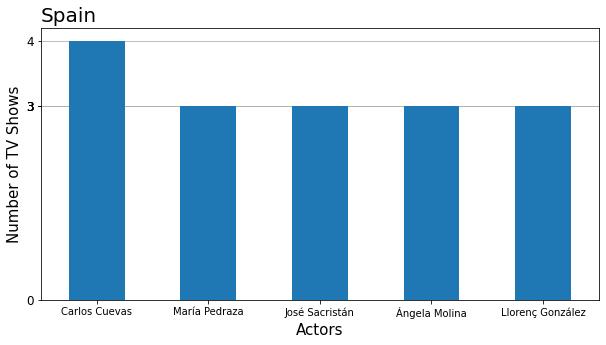

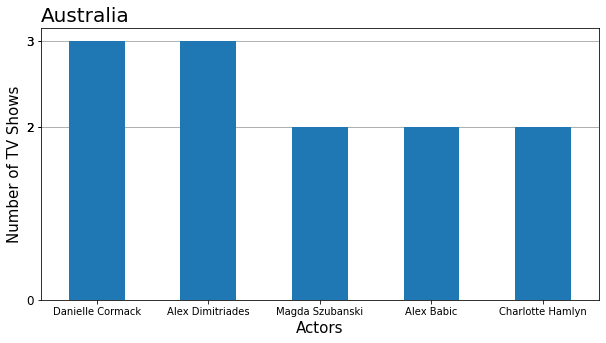

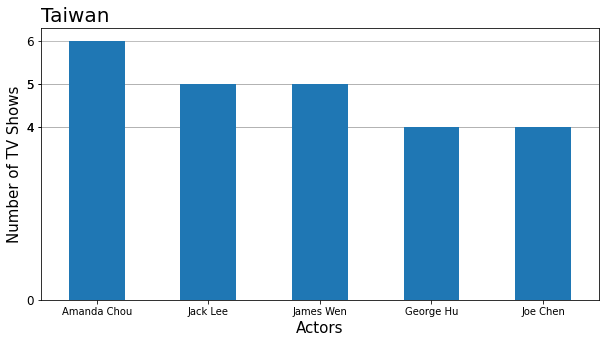

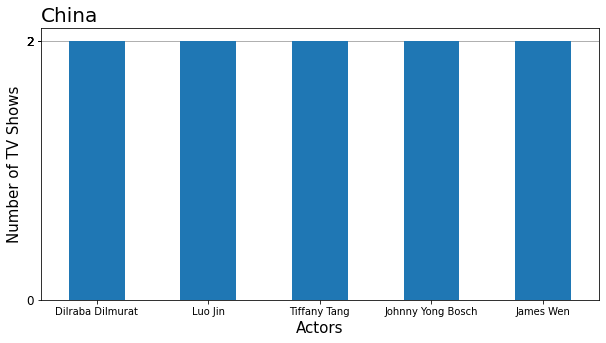

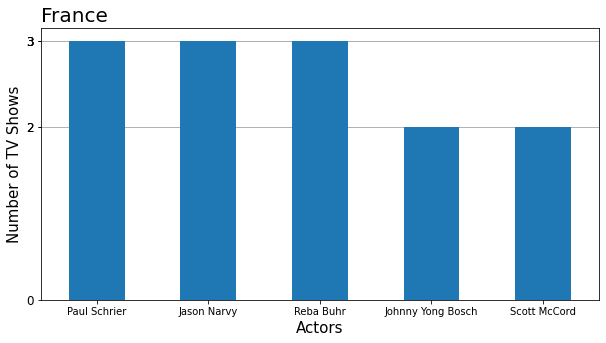

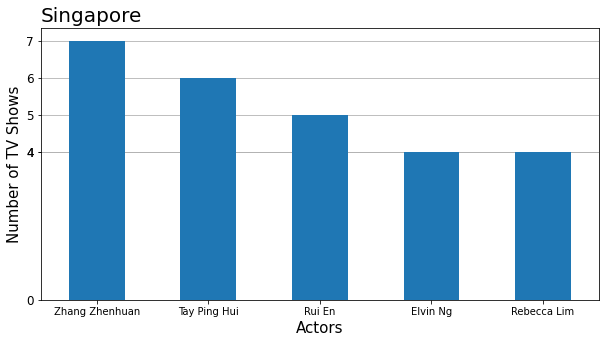

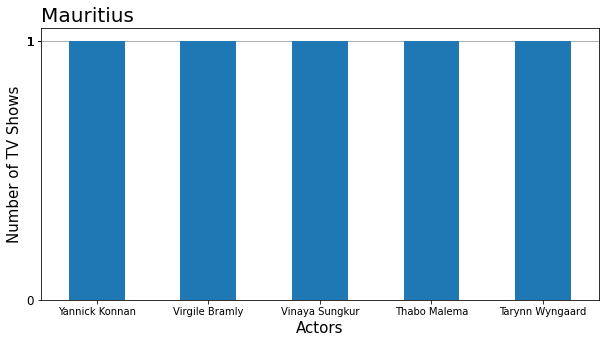

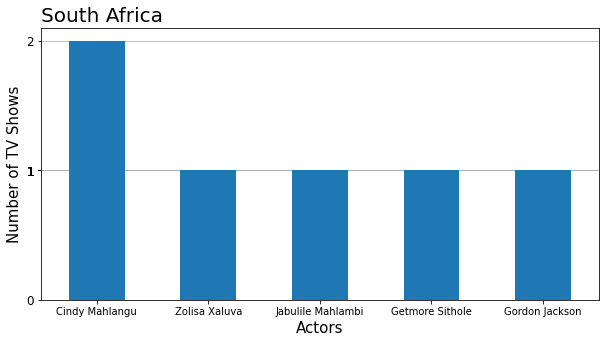

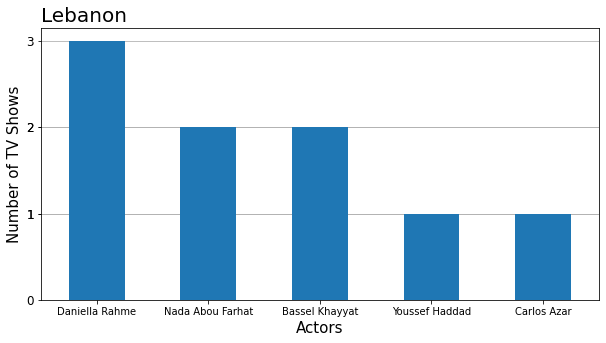

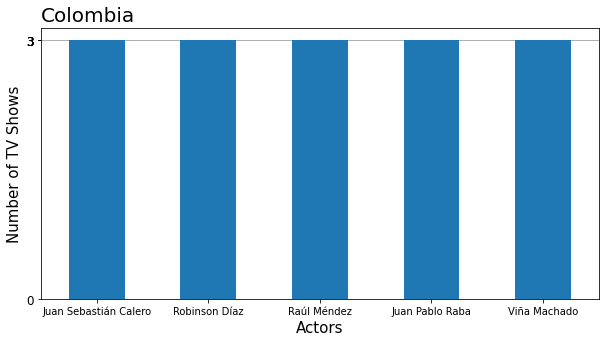

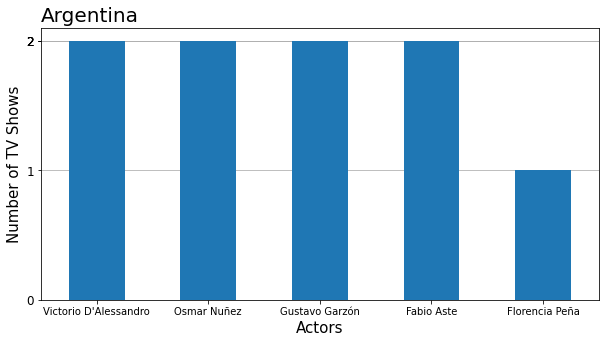

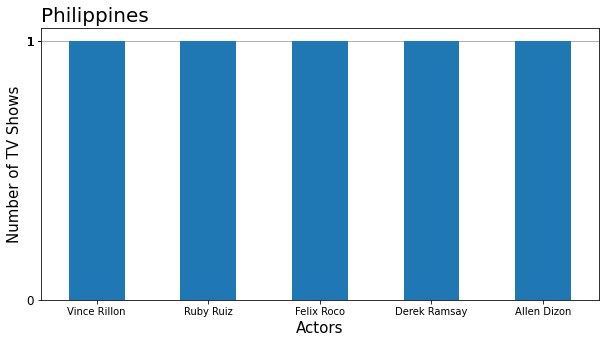

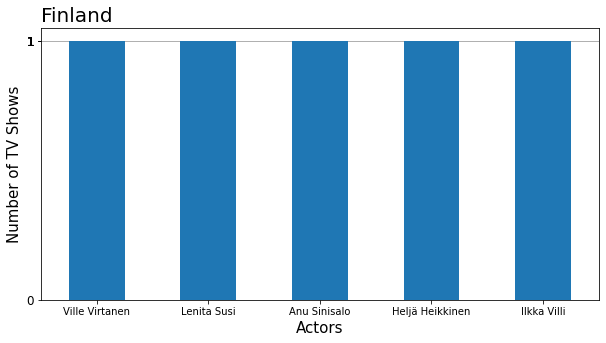

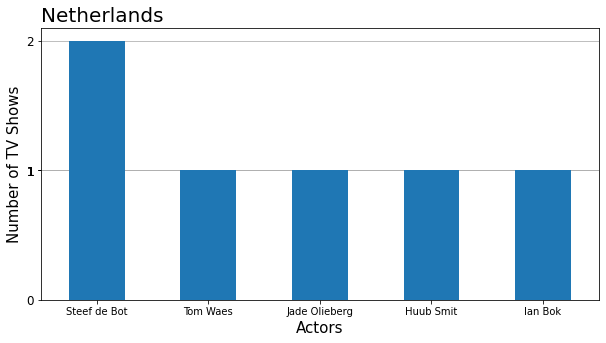

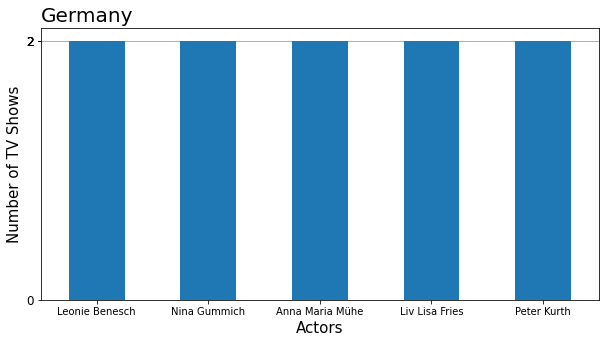

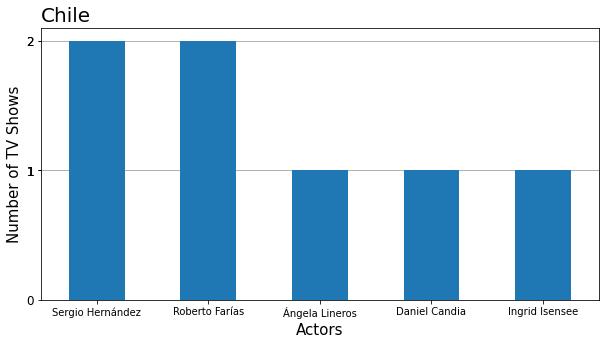

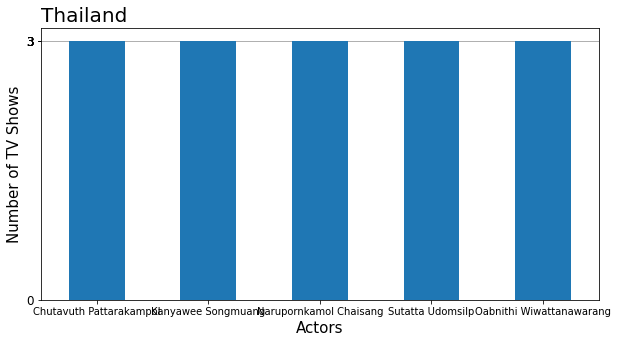

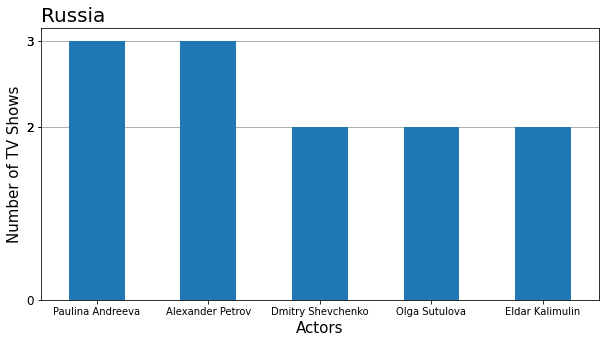

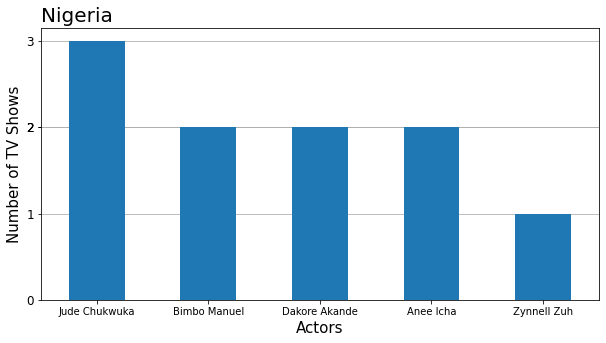

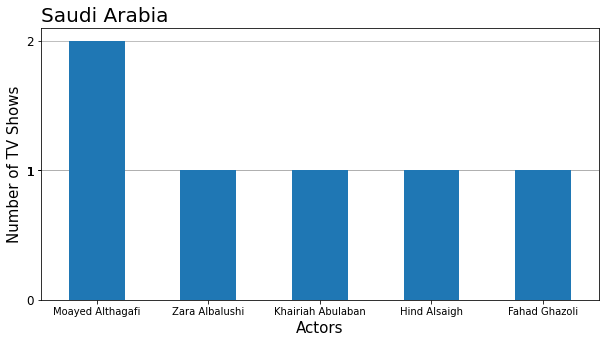

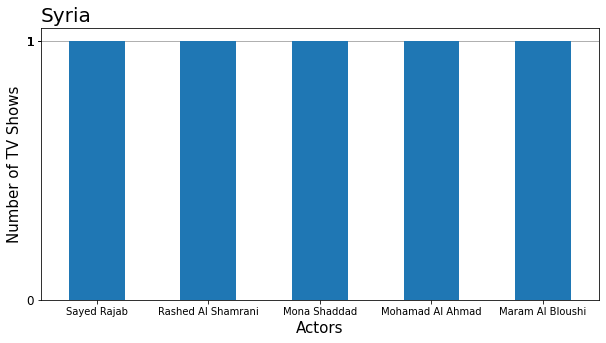

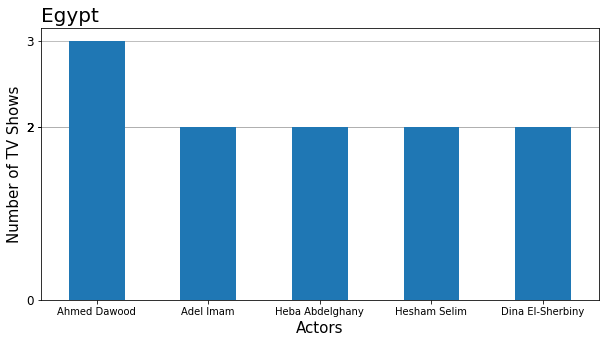

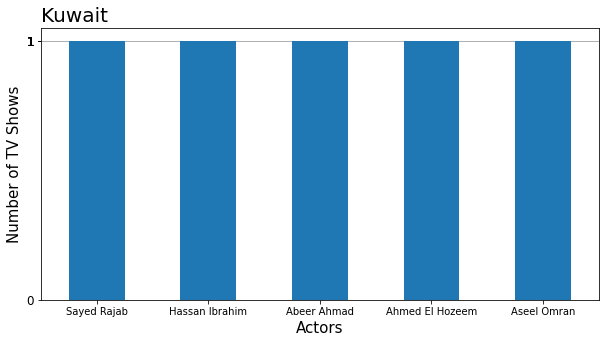

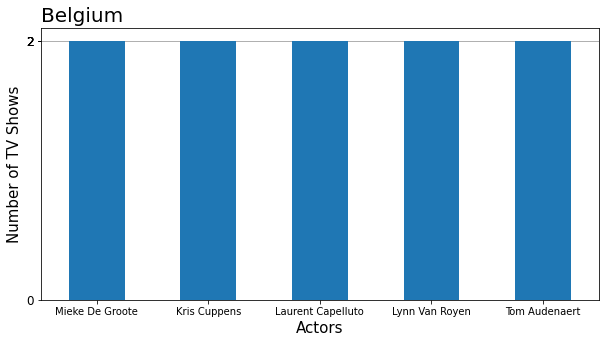

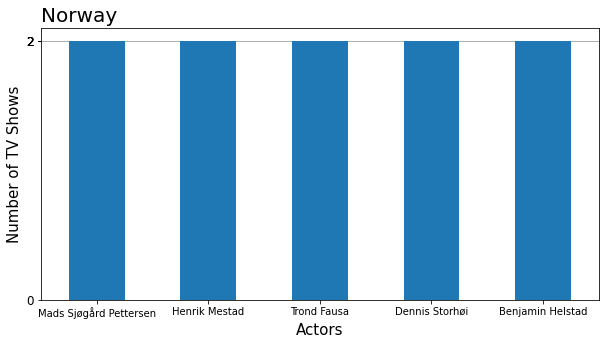

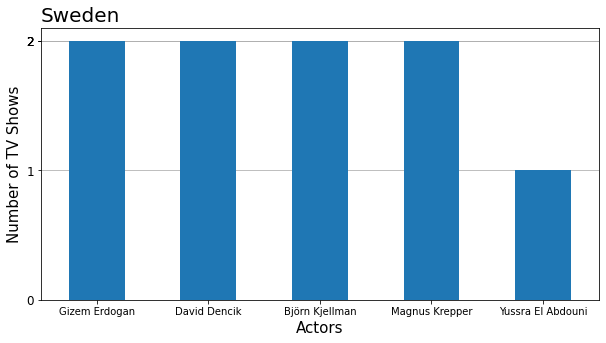

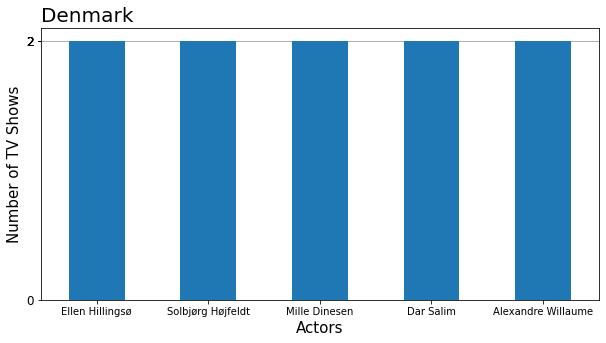

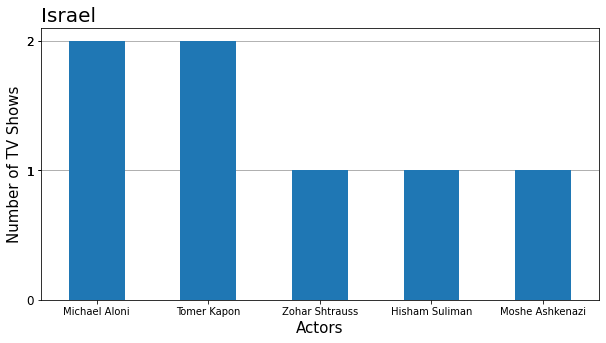

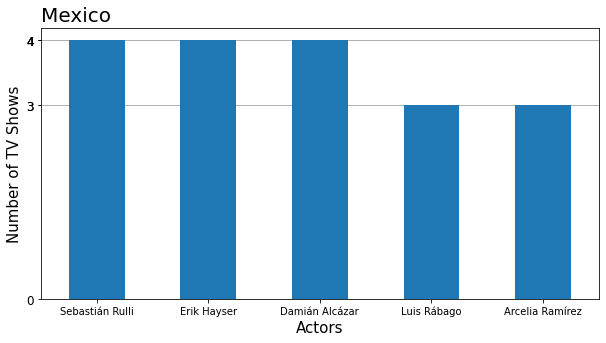

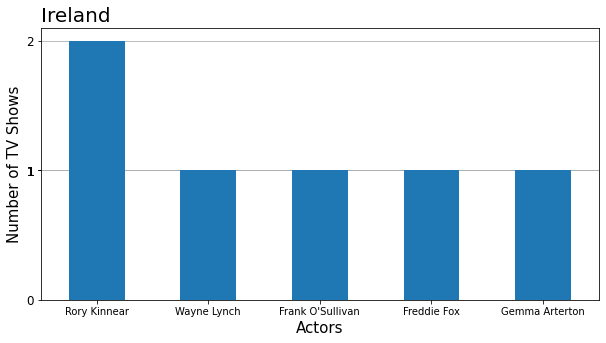

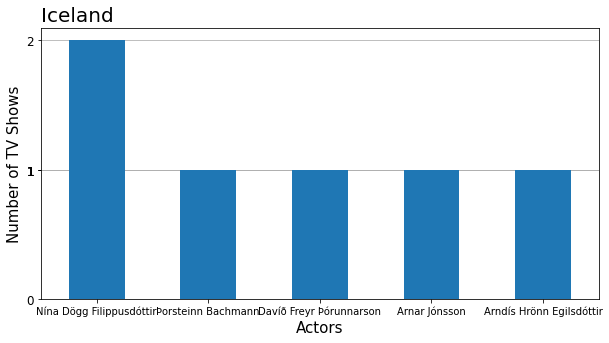

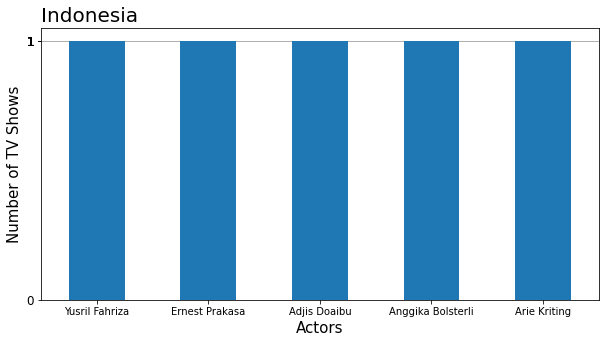

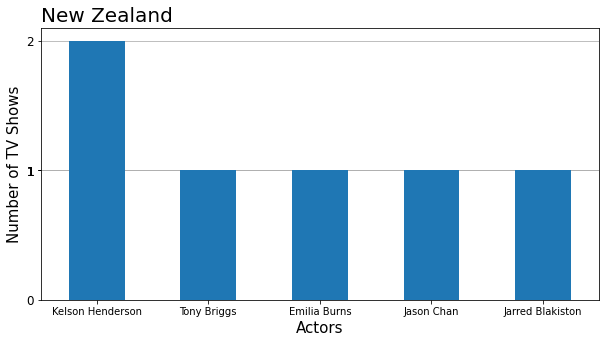

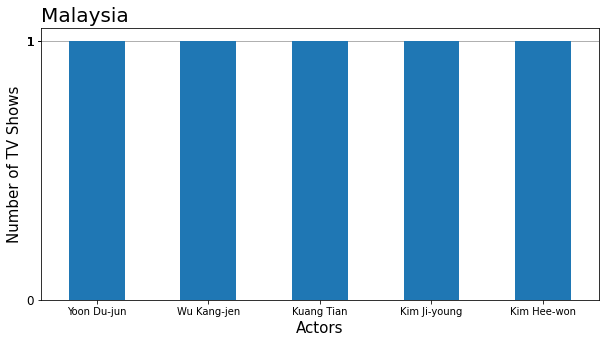

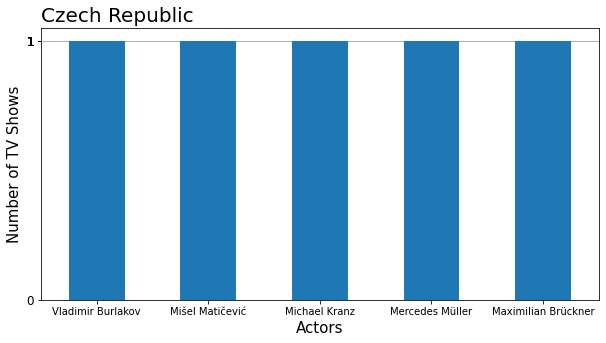

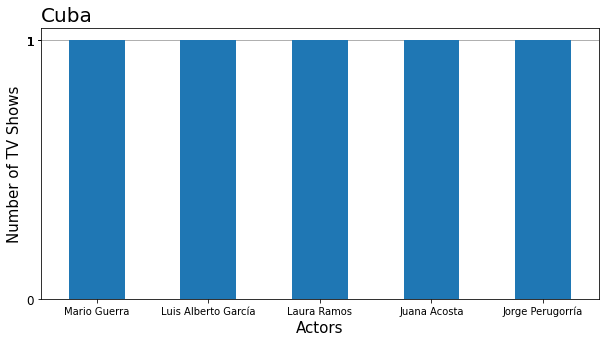

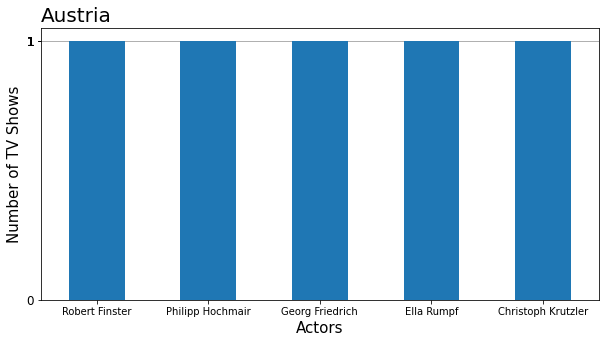

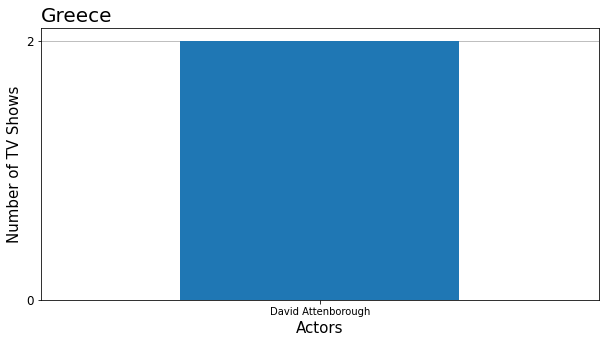

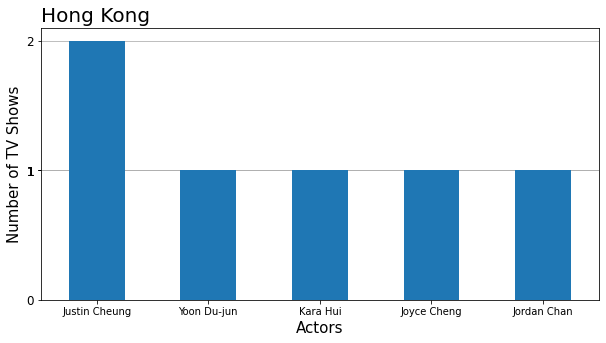

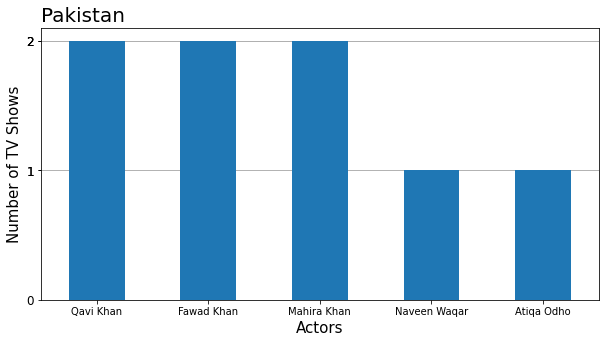

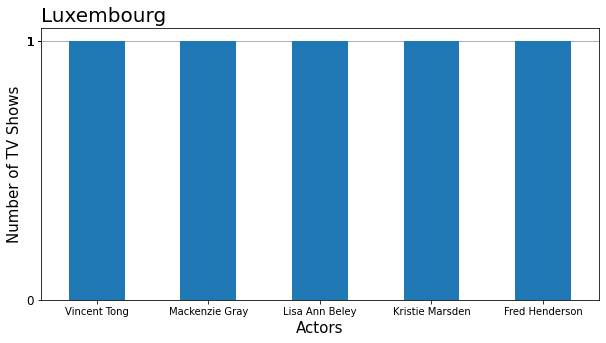

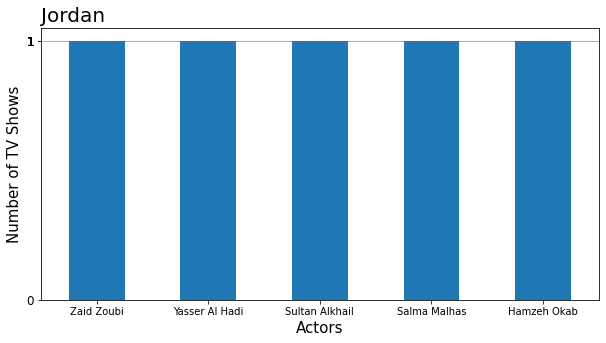

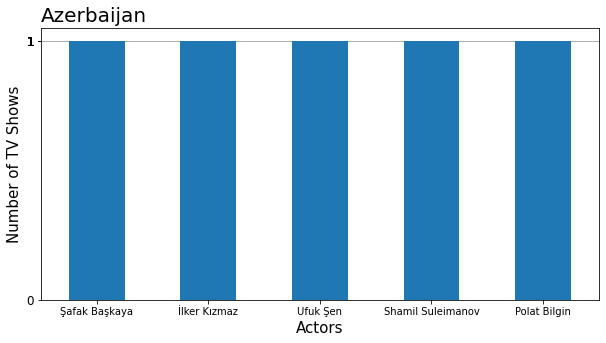

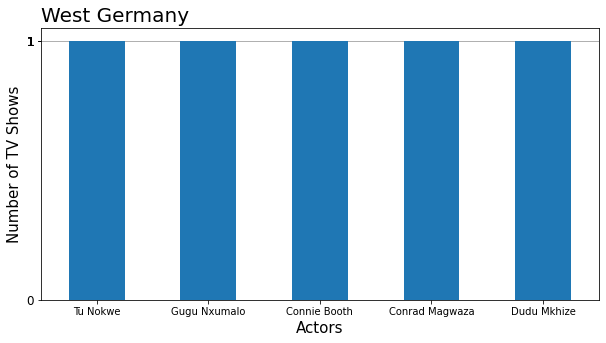

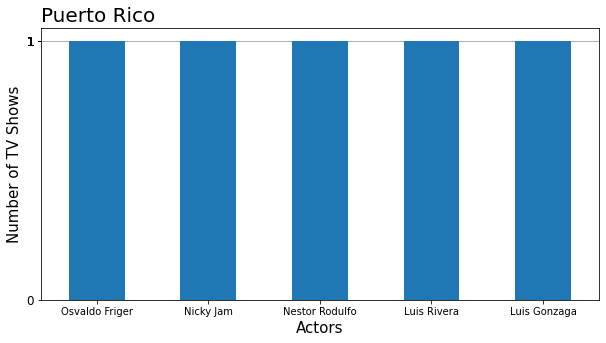

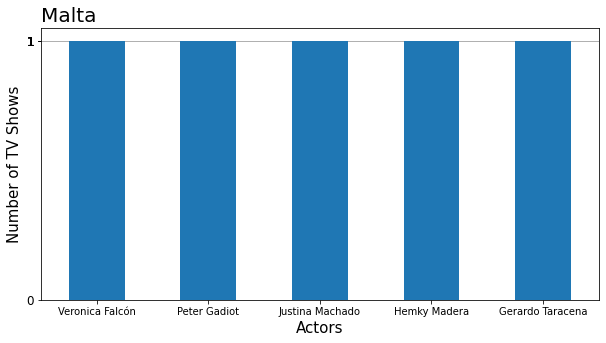

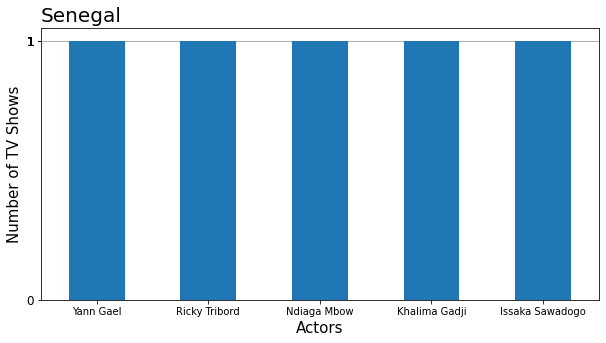

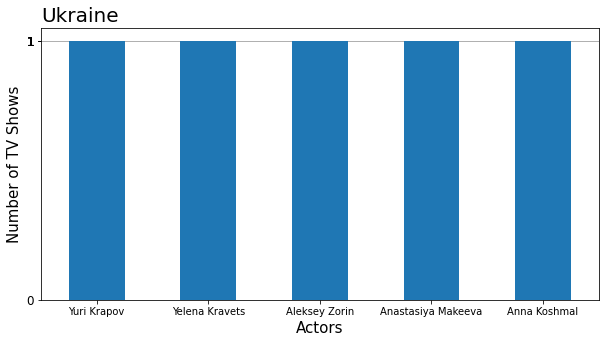

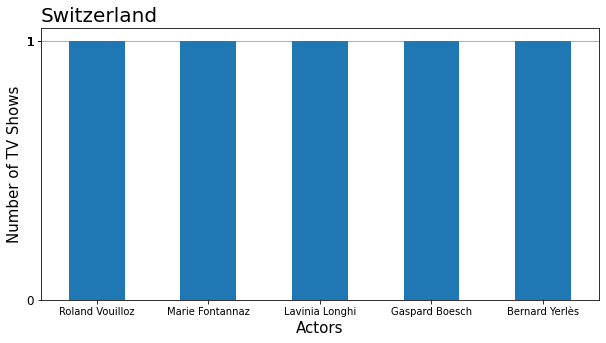

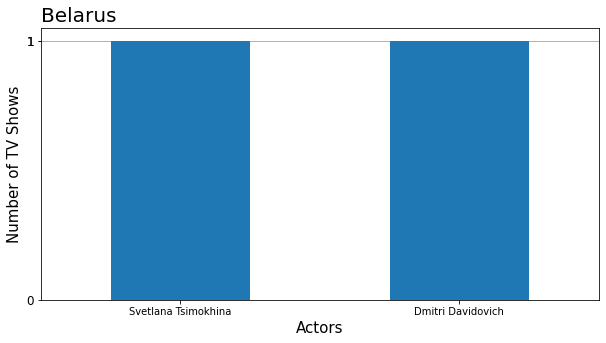

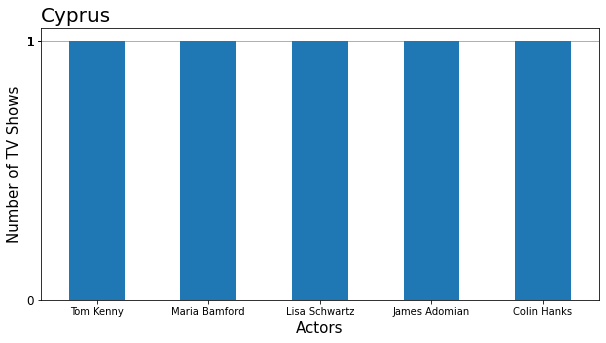

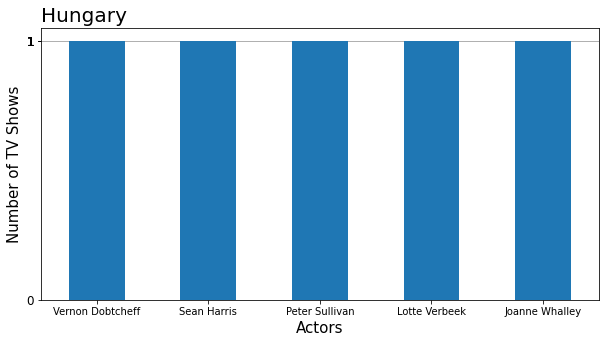

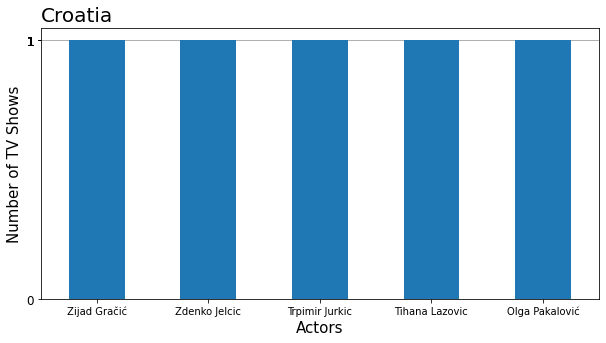

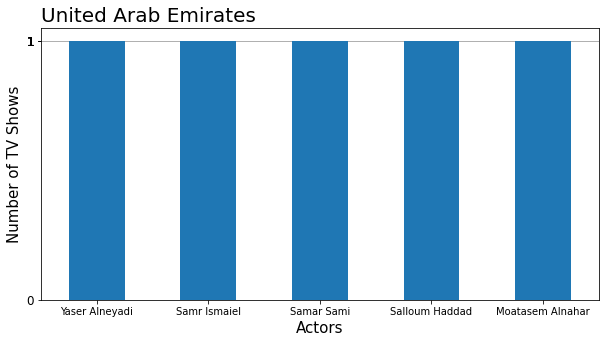

In [46]:

#Όμοια διαδικασία με τις ταινίες από πάνω
cshows = netflix.loc[netflix['type']=='TV Show']
ctmp_show = cshows.dropna(axis=0,subset=['country', 'cast'])
ctmp_show = split_df_rows(ctmp_show,'country')
ctmp_show = split_df_rows(ctmp_show,'cast')
countries_shows = ctmp_show['country'].unique()

for x in countries_shows:
    cDF1 = ctmp_show.loc[ctmp_show['country']==x]
    actors = cDF1.groupby('cast')
    numActors = actors['show_id'].nunique()
    sorted = numActors.sort_values(ascending=False)
    s = sorted.iloc[:5]
    ylen1 = [0]
    for i in s:
        ylen1.append(i)
    ax = s.plot.bar(rot=0, figsize=(10,5),zorder=3)
    plt.ylabel('Number of TV Shows', fontsize=15)
    plt.xlabel('Actors', fontsize=15)
    plt.title(x, fontsize=20, loc='left')
    ax.set_yticks(ylen1)
    ax.yaxis.grid(True)
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.show()

**Ερώτημα 6:**
*Το netflix υποστηρίζει ότι παρέχει πλούσιο περιεχόμενο για όλες τις ηλικίες.
Αληθεύει αυτό; Φτιάξτε ένα γράφημα το οποίο συγκεντρώνει το πλήθος των
ταινιων ανάλογα με την προτεινόμενη ηλικία (αναφερόμαστε στη στήλη rating). Τα
όρια καθορίζονται σύμφωνα με τον παρακάτω πίνακα. Κάντε το ίδιο γράφημα και
για τις σειρές.*

*Για τις ταινίες*

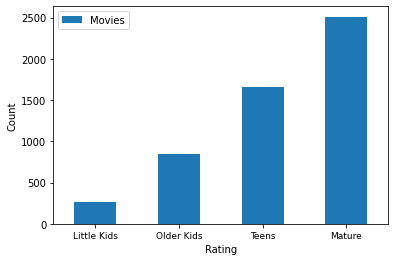

In [47]:
#Αναζήτηση ανά τύπο rating και εύρεση πλήθους μοναδικών εμφανίσεων
movie = netflix.loc[netflix['type']=='Movie']
temp_df = movie.dropna(axis=0, subset=['rating'])
rating = temp_df.groupby('rating')
whole = rating['type'].value_counts()

d6 = {}
d6['Little Kids'] = 0
d6['Older Kids'] = 0
d6['Teens'] = 0
d6['Mature'] = 0

#Ανάλογα το rating προσθέτουμε το πλήθος στην κατάλληλη κατηγορία
for x, y in whole.iteritems():
    if x[0] in {'G','TV-Y','TV-G'}:
        d6['Little Kids'] += int(y)
    elif x[0] in {'PG','TV-Y7','TV-Y7-FV','TV-PG'}:
        d6['Older Kids'] += int(y)
    elif x[0] in {'PG-13','TV-14'}:
        d6['Teens'] += int(y)
    elif x[0] in {'R','NC-17','TV-MA'}:
        d6['Mature'] += int(y)
  
d_f = pd.DataFrame.from_dict(d6, orient='index', columns=['Movies']).fillna(0).astype({'Movies':int})
d_f.plot.bar(rot=0)
plt.ylabel('Count')
plt.xlabel('Rating')
plt.tick_params(axis='x', which='major', labelsize=9)

*Για τις σειρές*

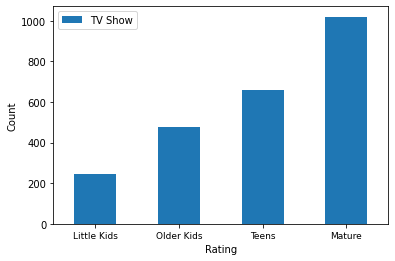

In [48]:
#Όμοια διαδικασία με τις ταινίες από πάνω

shows = netflix.loc[netflix['type']=='TV Show']
temp_df = shows.dropna(axis=0, subset=['rating'])
rating = temp_df.groupby('rating')
whole_1 = rating['type'].value_counts()
d6_1 = {}
d6_1['Little Kids'] = 0
d6_1['Older Kids'] = 0
d6_1['Teens'] = 0
d6_1['Mature'] = 0
for x, y in whole_1.iteritems():
    if x[0] in {'G','TV-Y','TV-G'}:
        d6_1['Little Kids'] += int(y)
    elif x[0] in {'PG','TV-Y7','TV-Y7-FV','TV-PG'}:
        d6_1['Older Kids'] += int(y)
    elif x[0] in {'PG-13','TV-14'}:
        d6_1['Teens'] += int(y)
    elif x[0] in {'R','NC-17','TV-MA'}:
        d6_1['Mature'] += int(y)
  
d_f1 = pd.DataFrame.from_dict(d6_1, orient='index', columns=['TV Show']).fillna(0).astype({'TV Show':int})
d_f1.plot.bar(rot=0)
plt.ylabel('Count')
plt.xlabel('Rating')
plt.tick_params(axis='x', which='major', labelsize=9)

**Ερώτημα 7:**
*Αν ένας παραγωγός ήθελε να έχει υψηλή ακροαματικότητα, σκέφτεται ότι θα ήταν
ίσως καλύτερα να βγάλει την ταινία του σε μία εποχή που δεν υπάρχει
ανταγωνισμός. Κάντε ένα γράφημα με το περιεχόμενο που προστίθεται ανά μήνα
για να τον βοηθήσετε να επιλέξει τη σωστή χρονική περίοδο.*

Σε αυτό το ερώτημα σκεφτήκαμε ότι δε χρειαζόταν να κοιτάξουμε και τα είδη του περιεχόμενου, αλλά ότι αρκούσε μόνο να ελέγξουμε το πόσες ταινίες και σειρές βγαίνουν ανά μήνα.

Text(0.5, 0, 'Month')

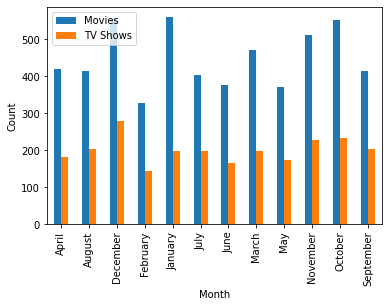

In [49]:
#Διαχείριση της στήλης date_added για να κρατήσουμε μόνο τους μήνες
tmpdf = netflix.dropna(axis=0, subset=['date_added'])
for x, y in tmpdf.iterrows():
    date7 = str(y['date_added'])
    month = date7.split()
    tmpdf.at[x, 'date_added'] = month[0]

#Αναζήτηση ανά μήνα του πλήθους ταινιών και σειρών
dat = tmpdf.groupby('date_added')
find = dat['type'].value_counts()
d7 = {}


for x, y in find.iteritems():
    if x[0] not in d7:
        d7[x[0]] = []
    d7[x[0]].append(y)

#Αποθήκευση, συμπλήρωση τιμών και εμφάνιση αποτελεσμάτων σε γράφημα
df7 = pd.DataFrame.from_dict(d7, orient='index', columns=['Movies', 'TV Shows']).fillna(0).astype({'Movies': int, 'TV Shows': int})
df7.plot.bar()
plt.ylabel('Count')
plt.xlabel('Month')

**Ερώτημα 8:**
*Ετοιμάστε ένα γράφημα που παρουσιάζει συγκεντρωτικά τα είδη του περιεχομένου
(αναφερόμαστε στη στήλη listed_in).*

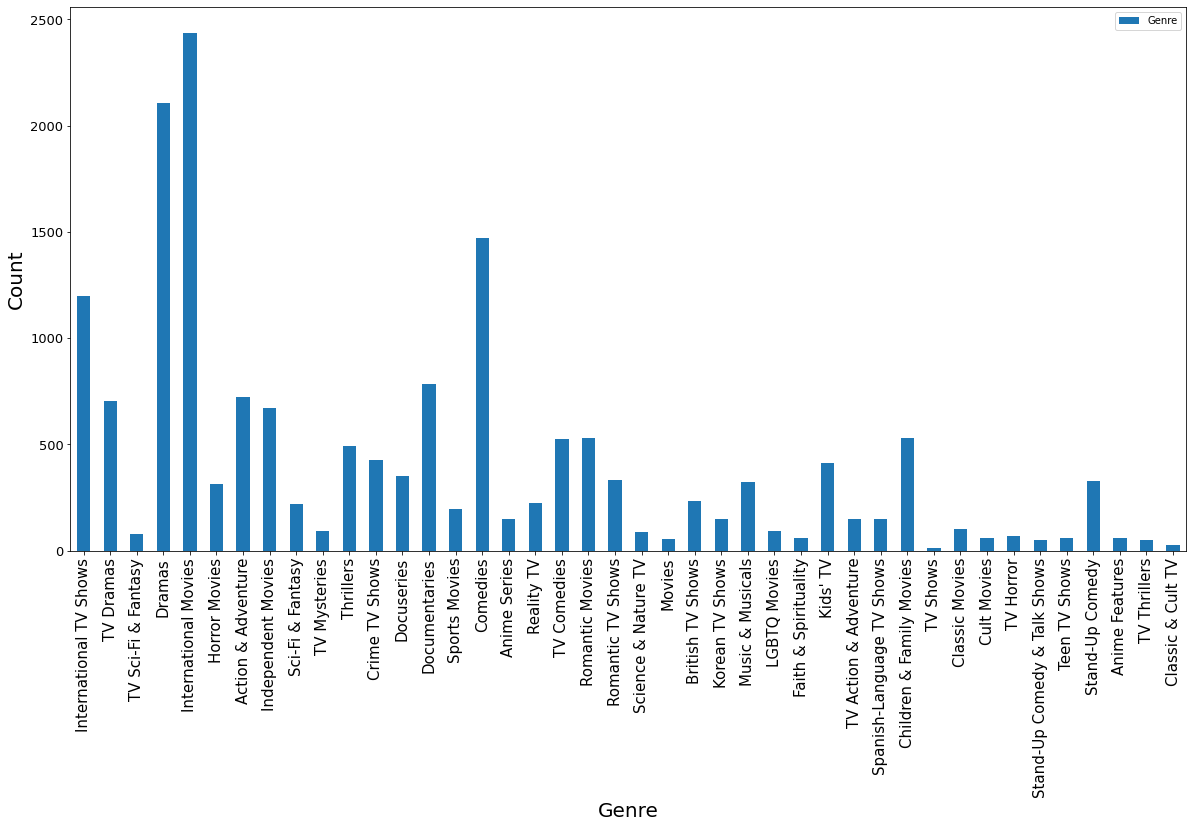

In [50]:
#Σπάσιμο γραμμών βάσει της στήλης listed_in και έυρεση των μοναδικών genres
genre8 = netflix.dropna(axis=0,subset=['listed_in'])
genre8 = split_df_rows(genre8,'listed_in')
genres8 = genre8['listed_in'].unique()

d8={}

for x in genres8:
    d8[x]=0
for x in genre8['listed_in']:
    d8[x]+=1
    
df8 = pd.DataFrame.from_dict(d8, orient='index', columns=['Genre']).fillna(0).astype({'Genre': int})
df8.plot.bar(figsize=(20,10))
plt.ylabel('Count',fontsize=20)
plt.xlabel('Genre',fontsize=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=13)

**Ερώτημα 9:**
*Μελετήστε τους σκηνοθέτες ανά χώρα και παρουσιάστε σχετικά γραφήματα*

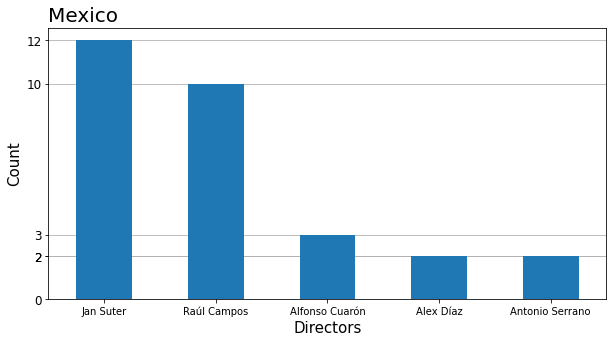

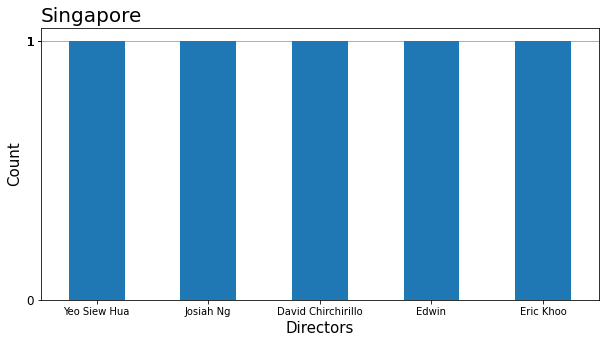

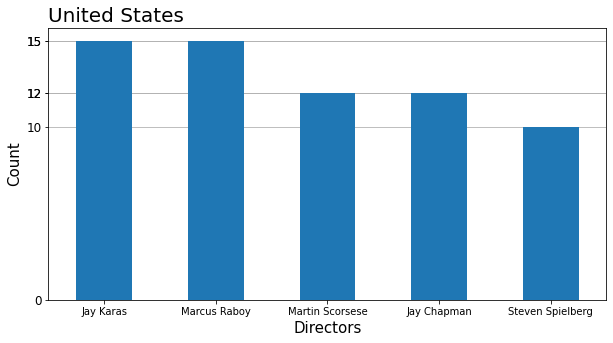

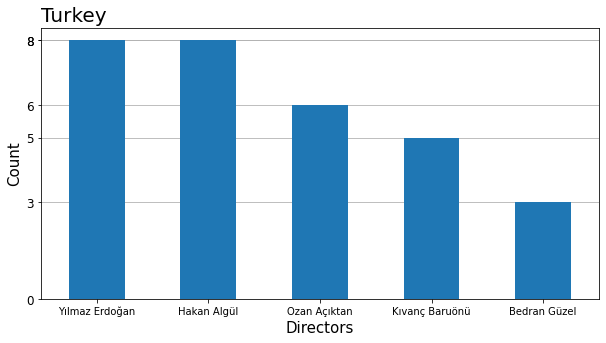

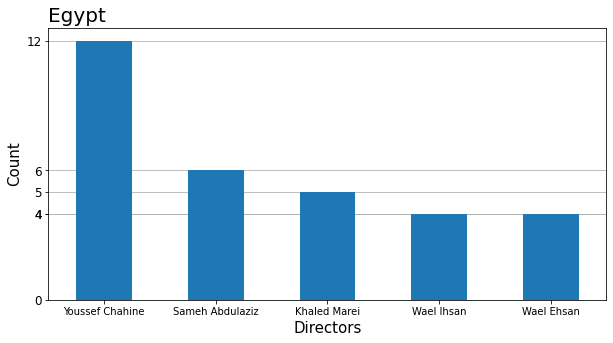

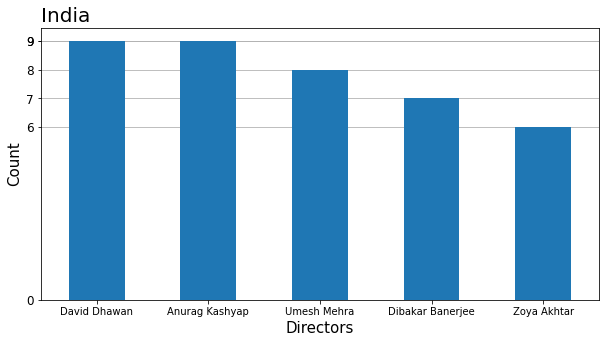

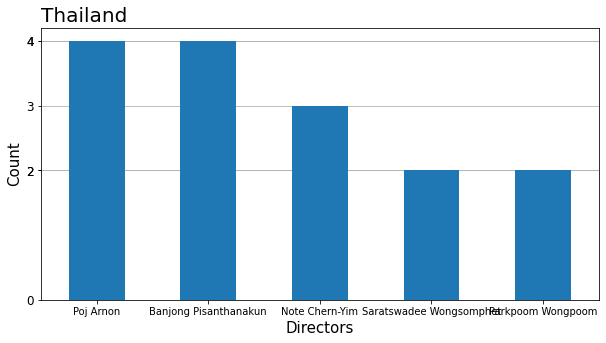

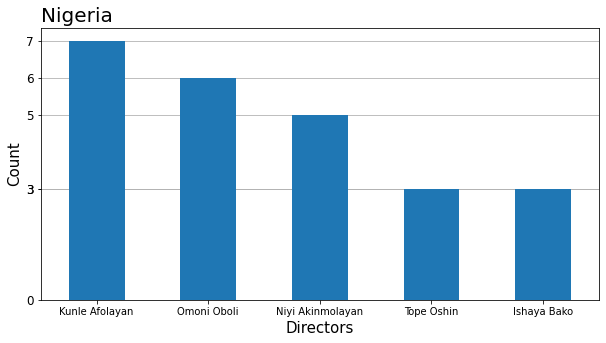

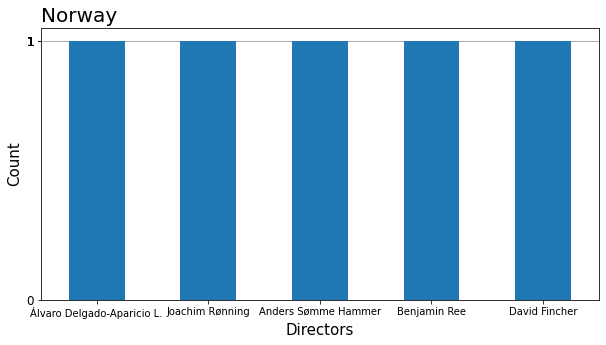

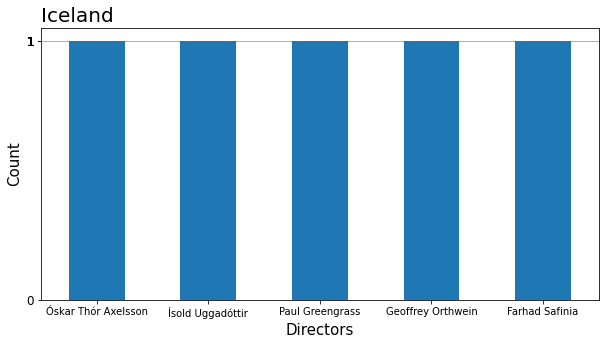

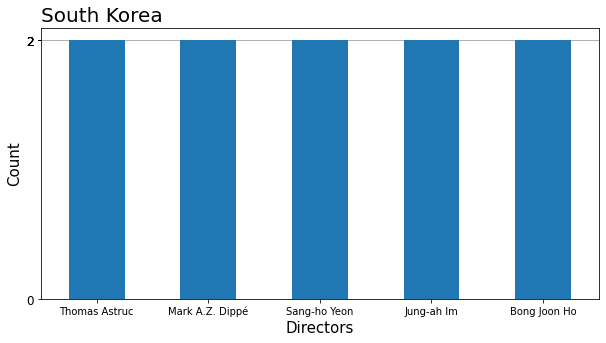

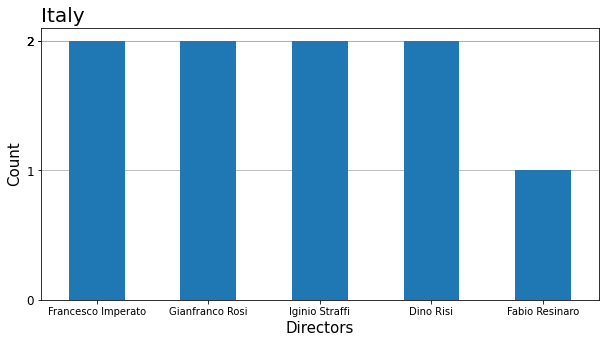

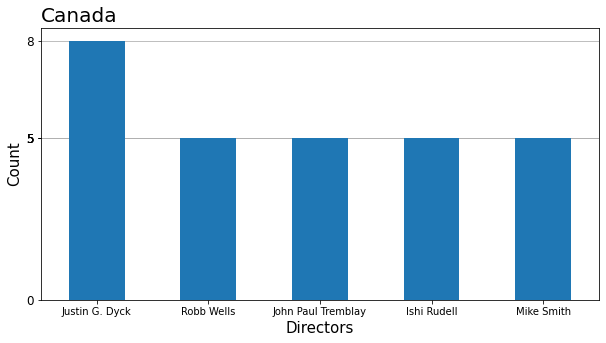

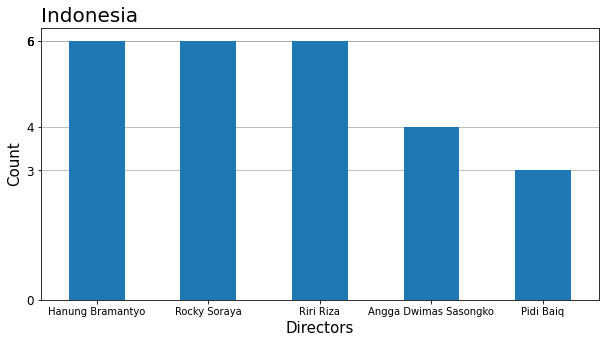

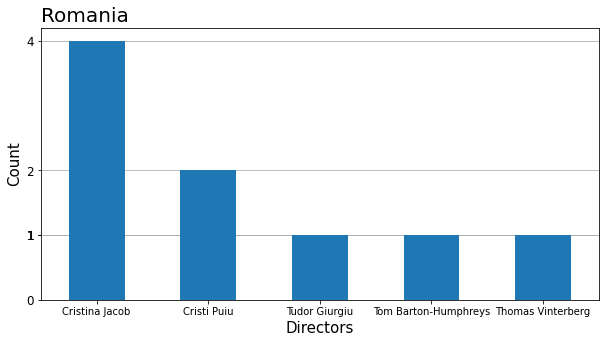

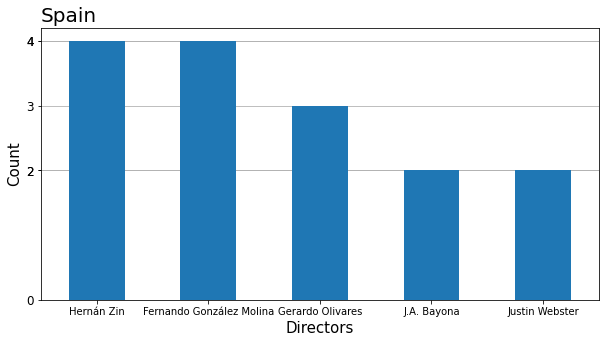

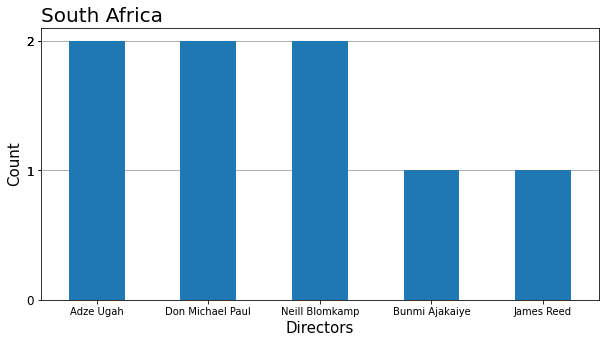

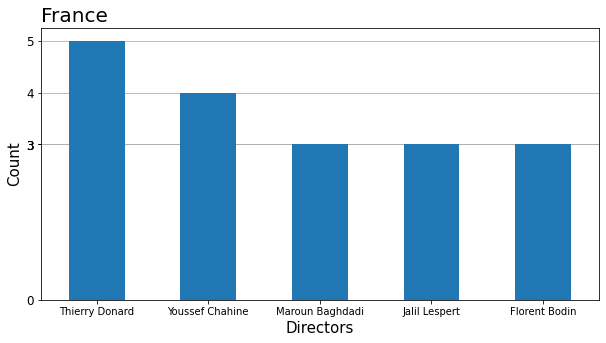

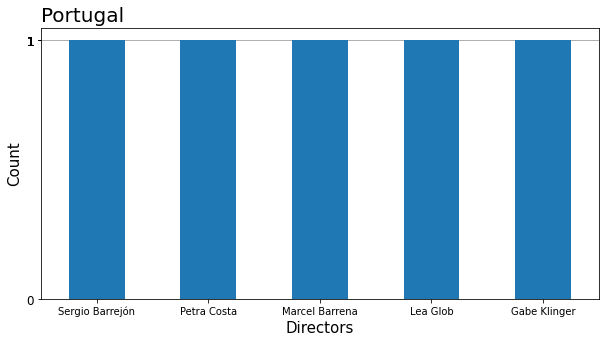

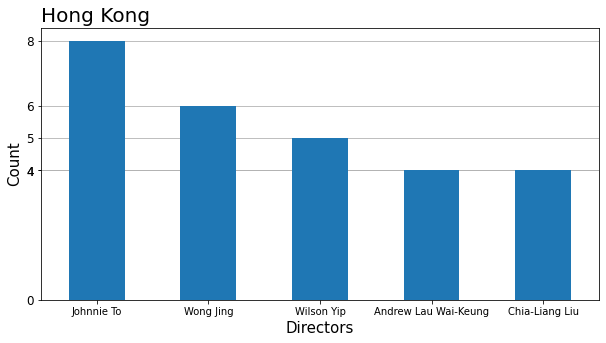

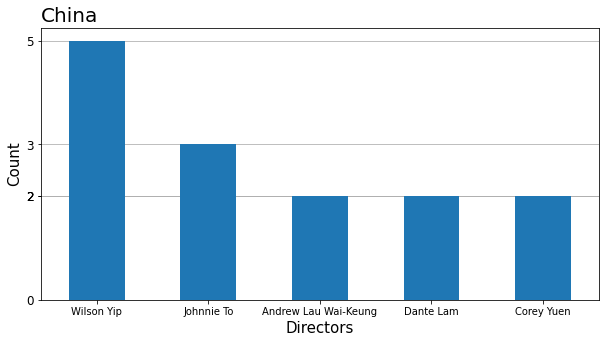

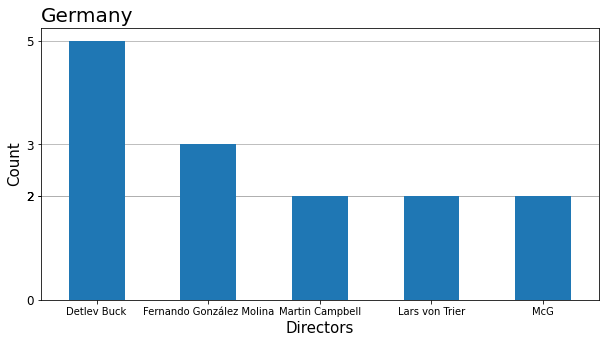

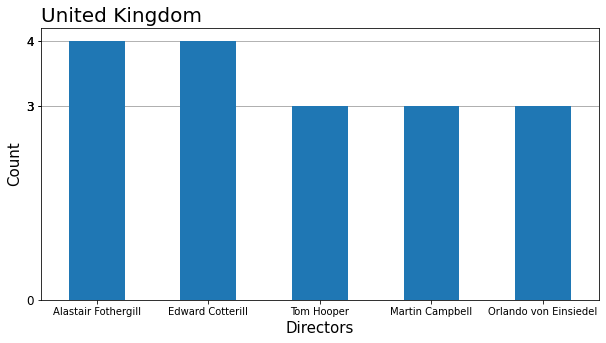

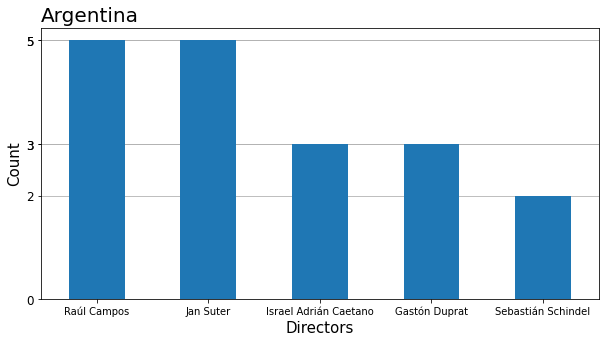

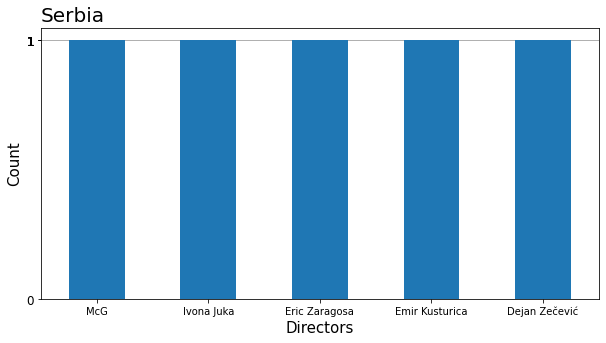

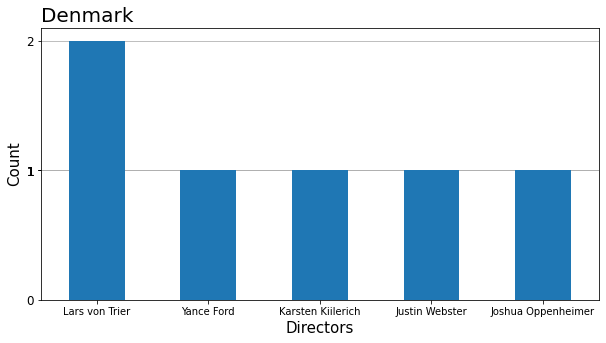

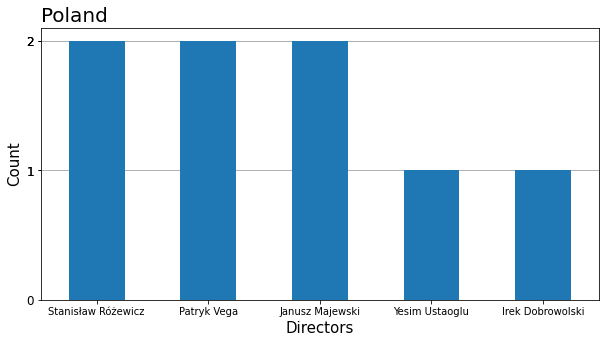

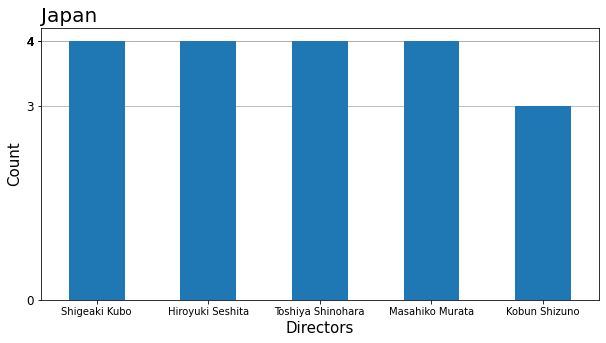

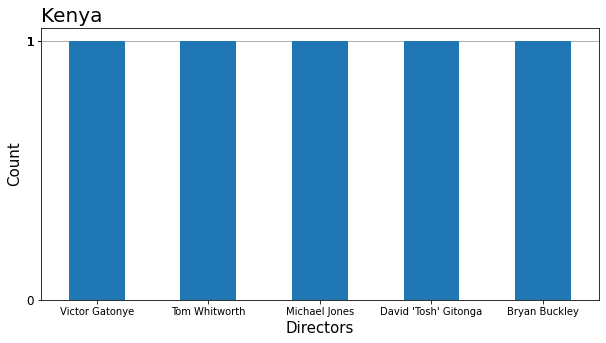

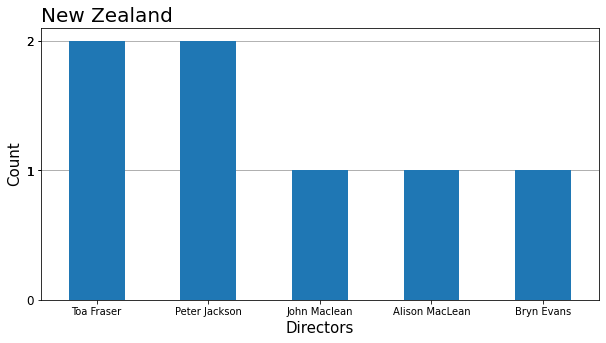

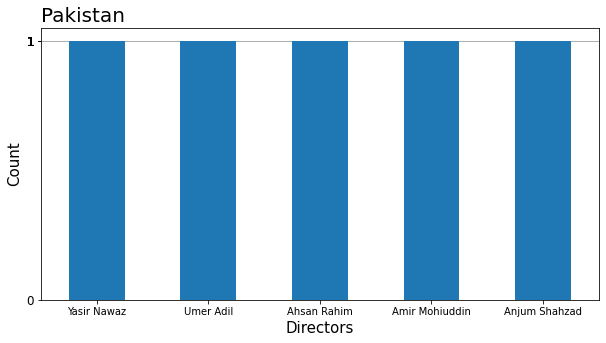

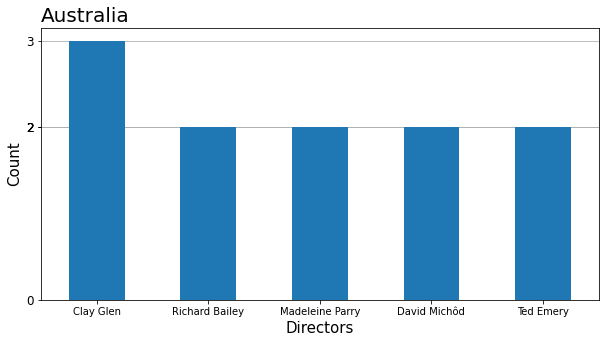

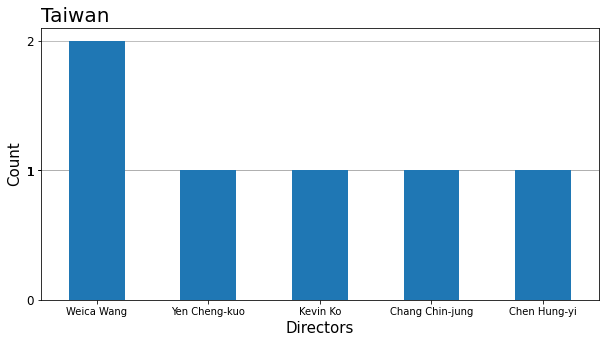

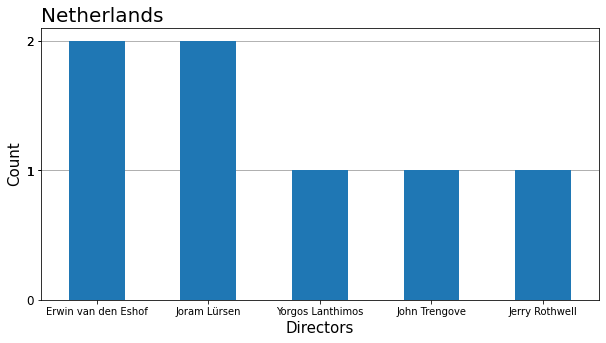

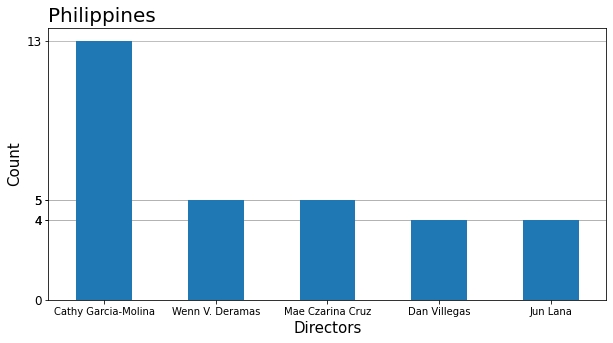

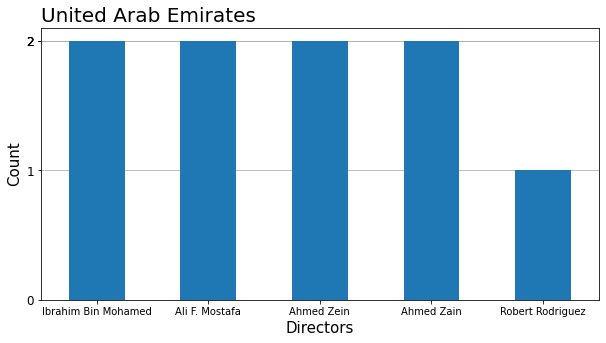

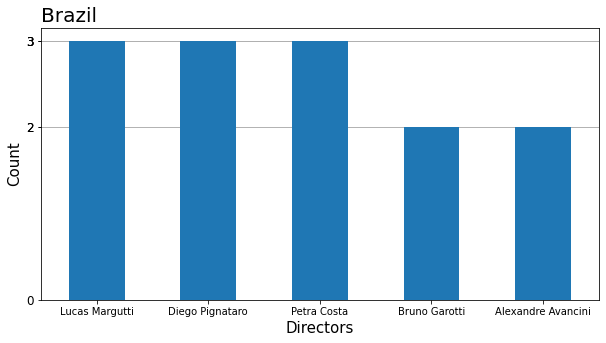

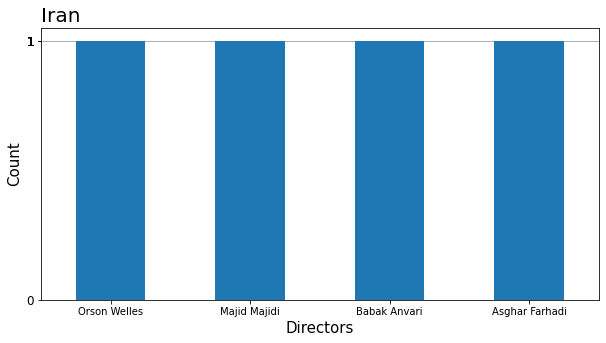

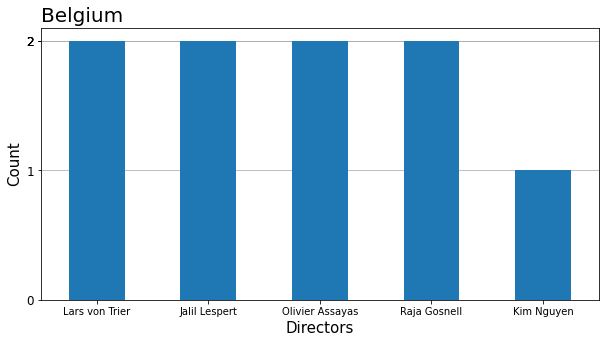

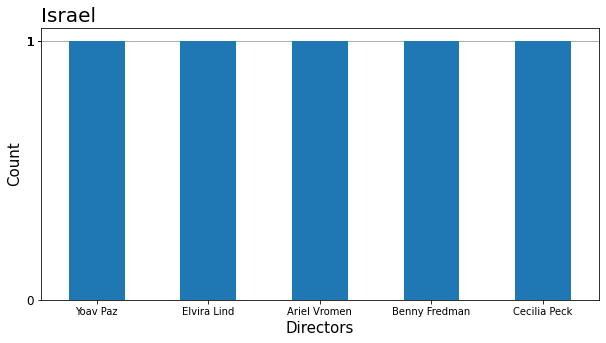

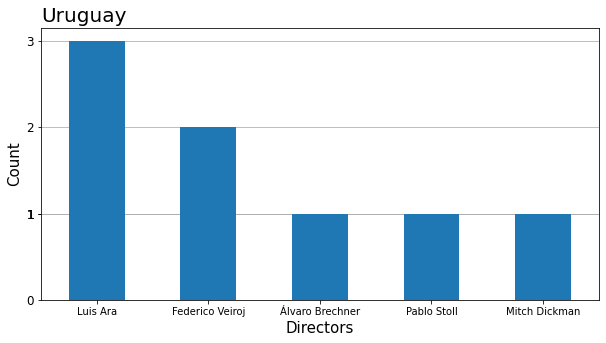

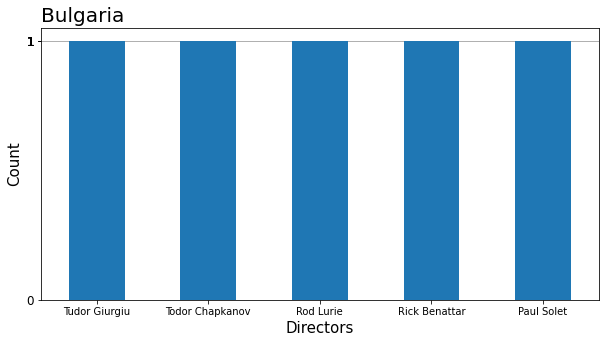

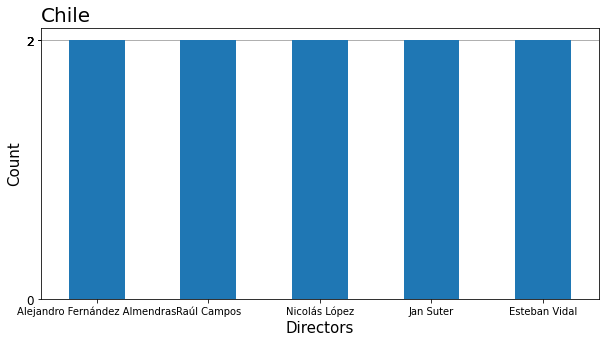

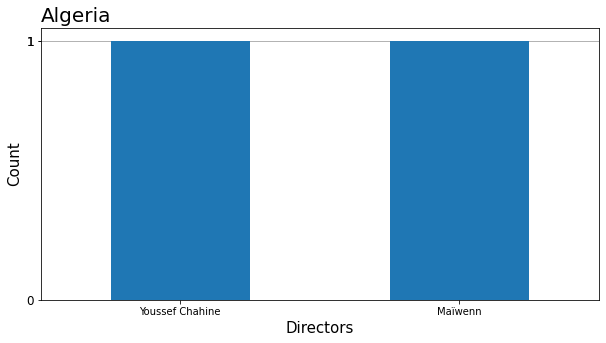

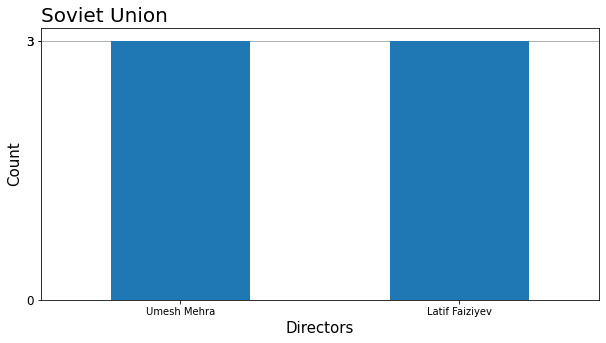

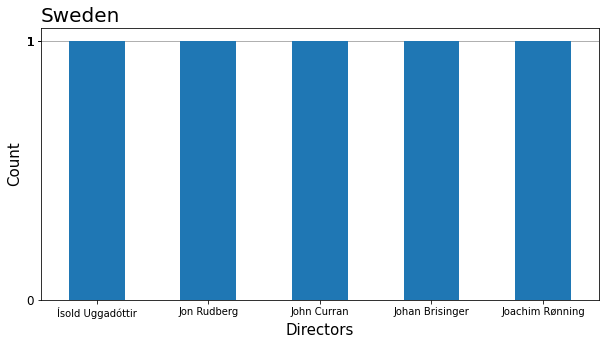

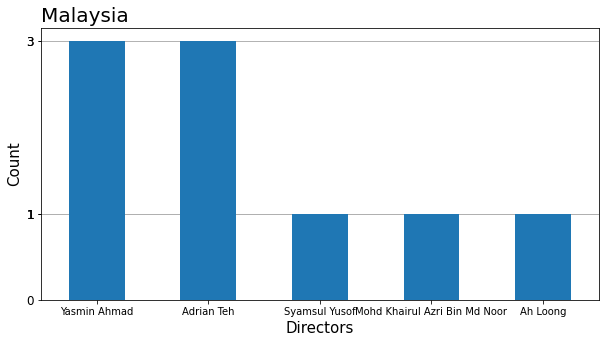

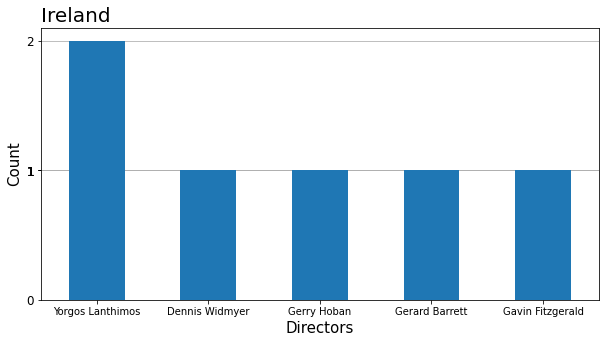

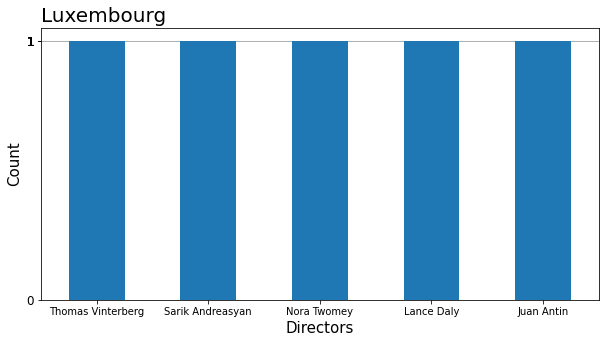

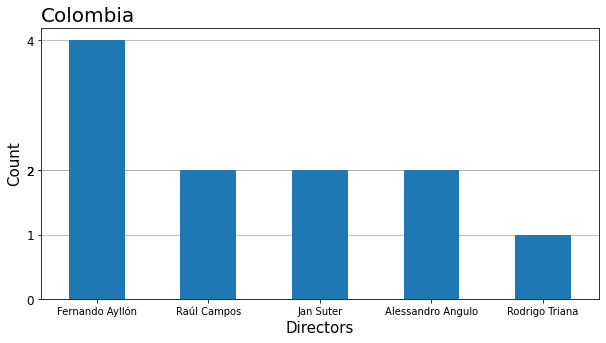

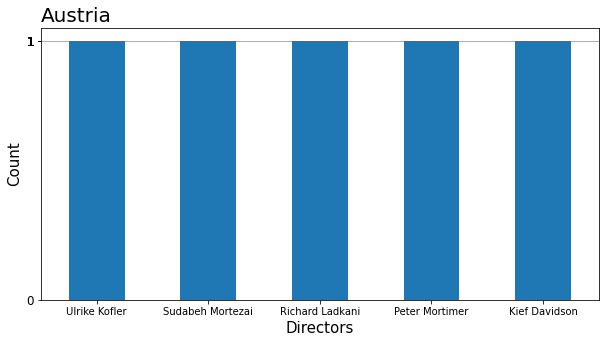

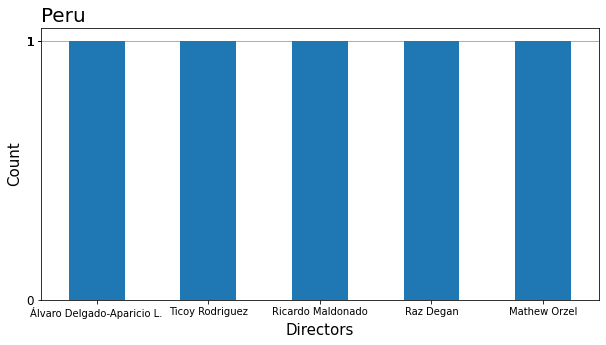

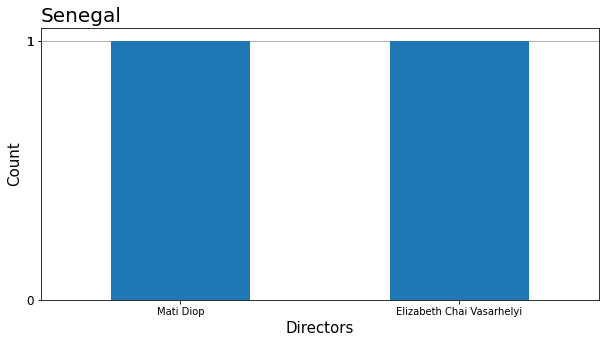

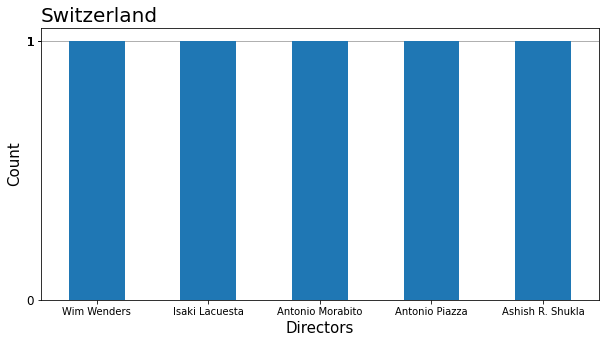

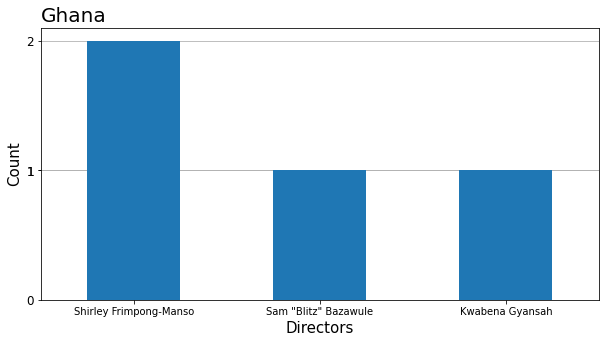

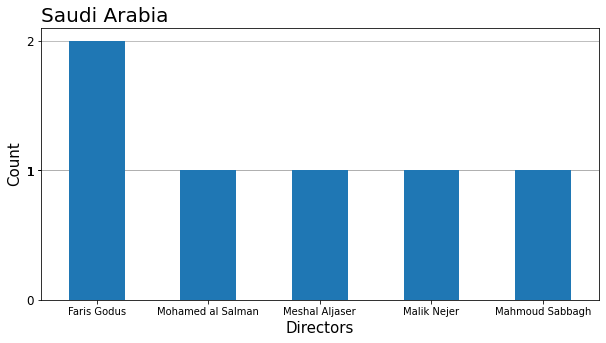

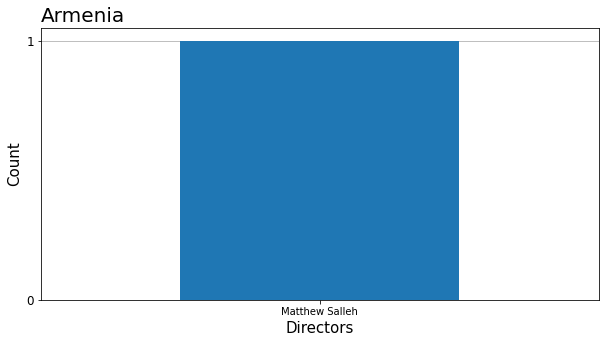

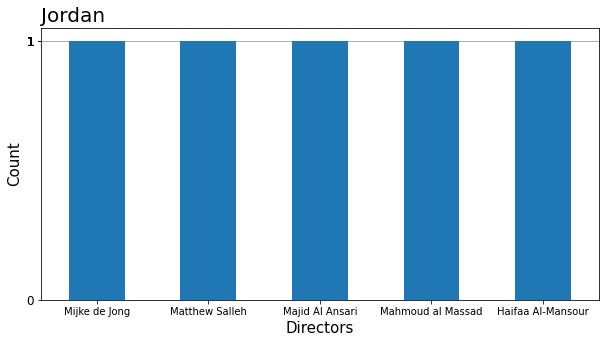

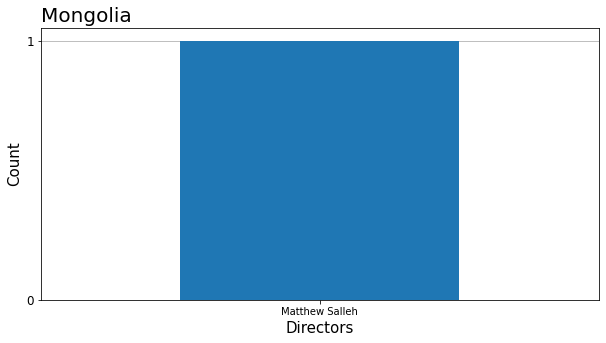

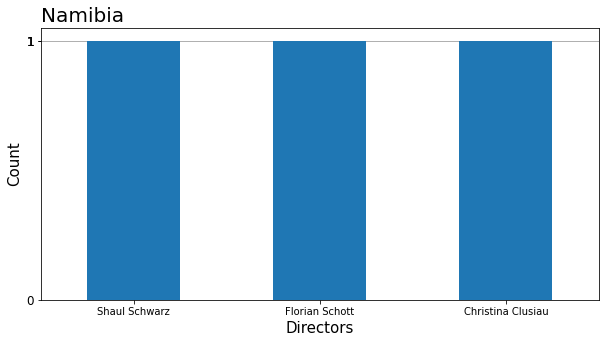

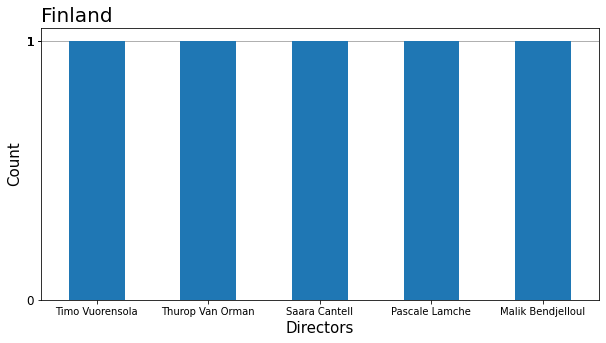

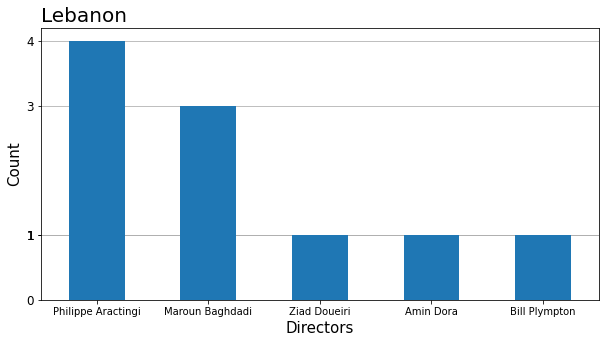

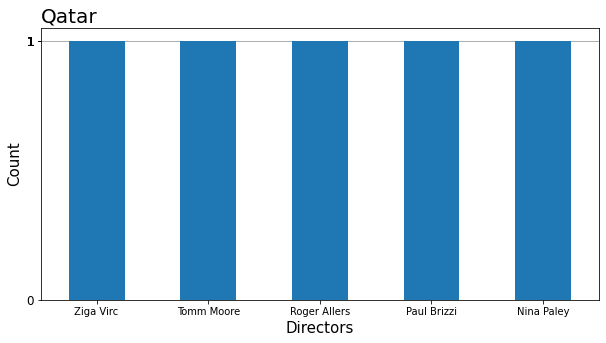

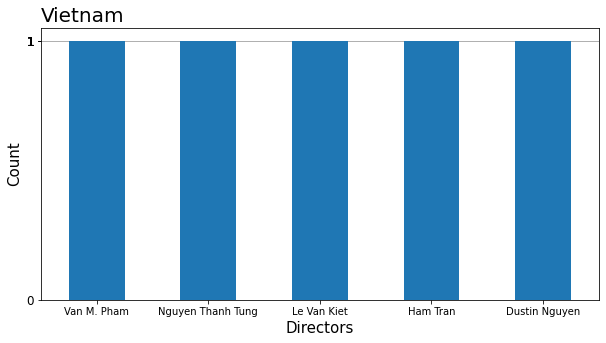

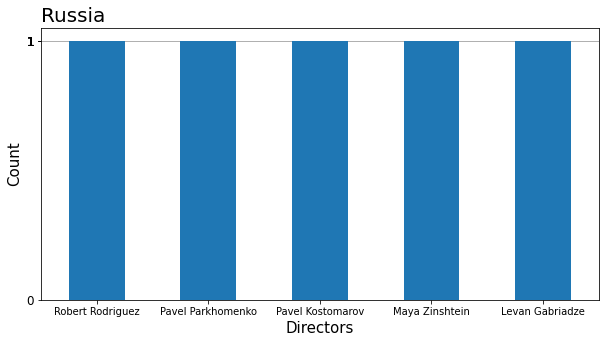

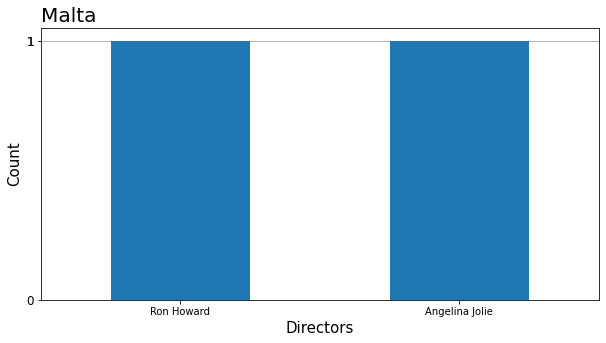

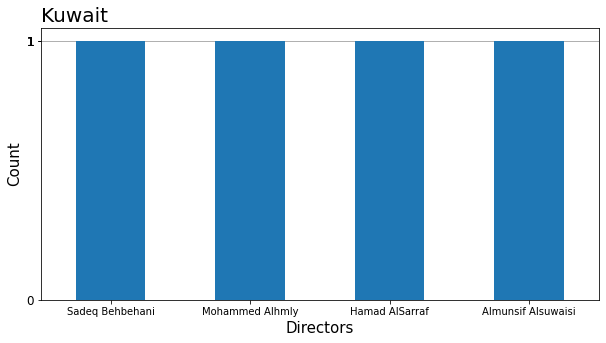

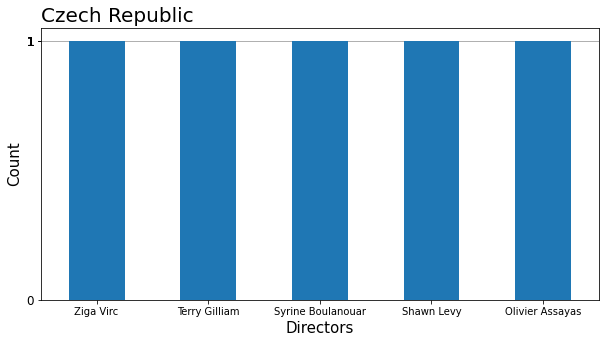

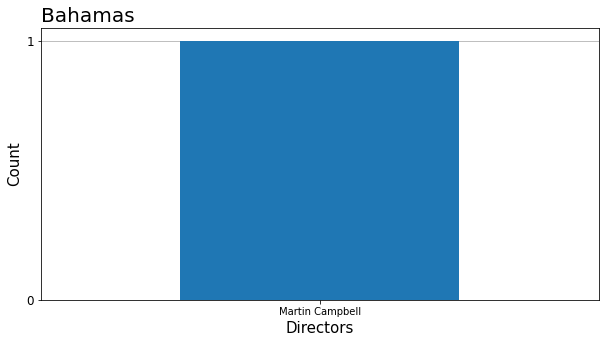

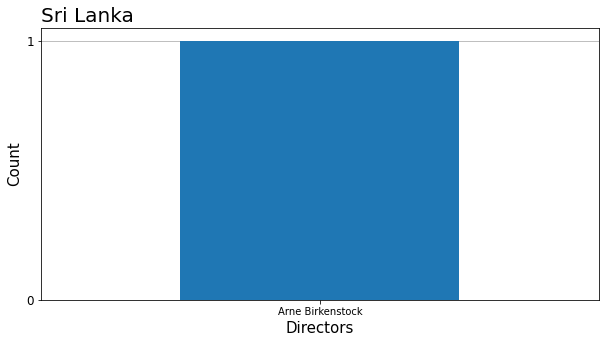

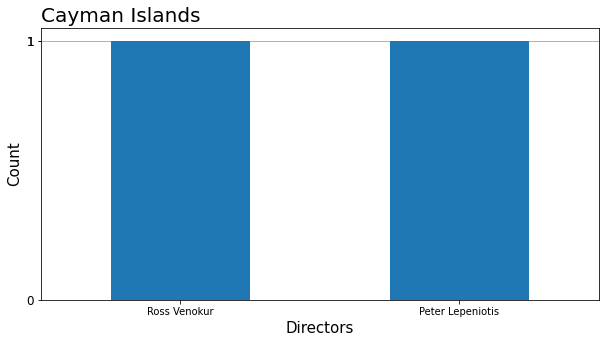

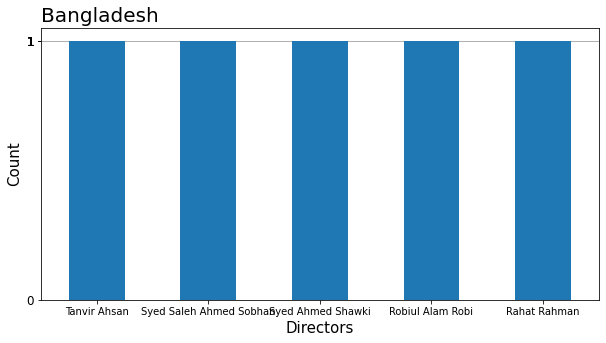

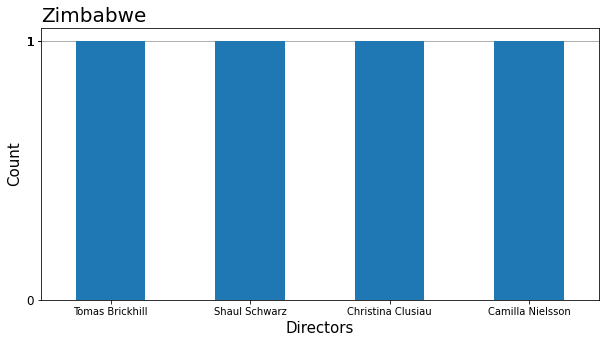

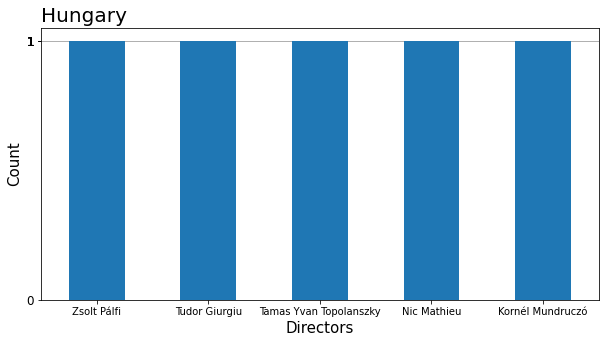

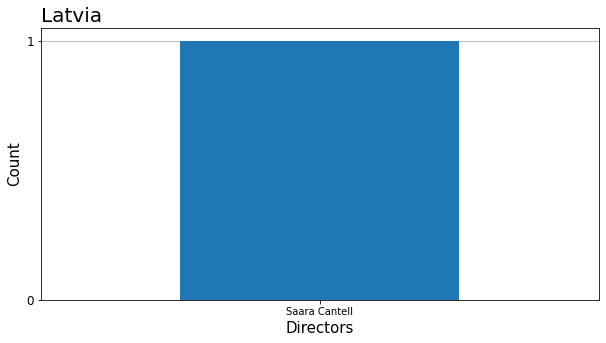

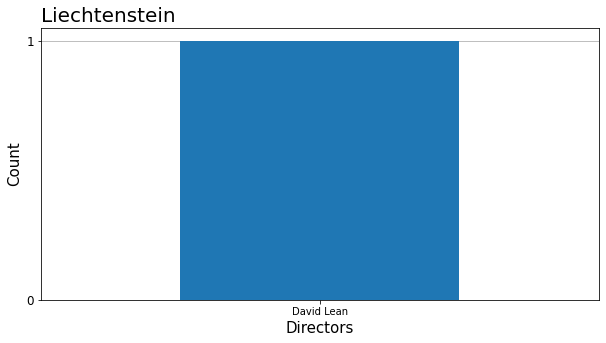

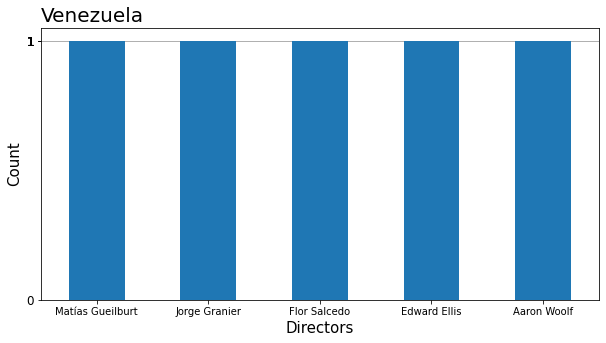

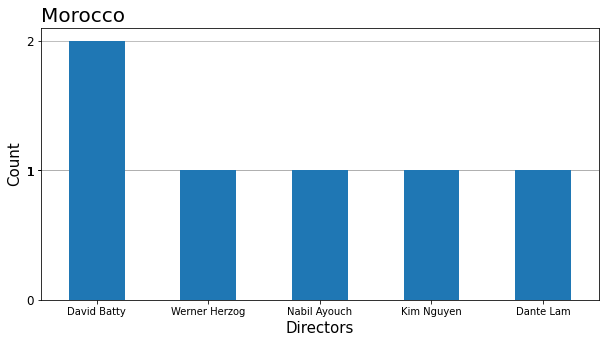

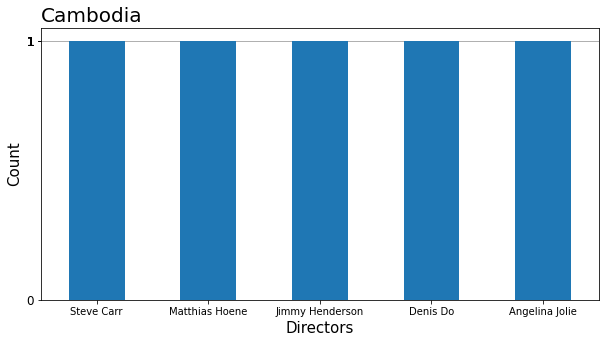

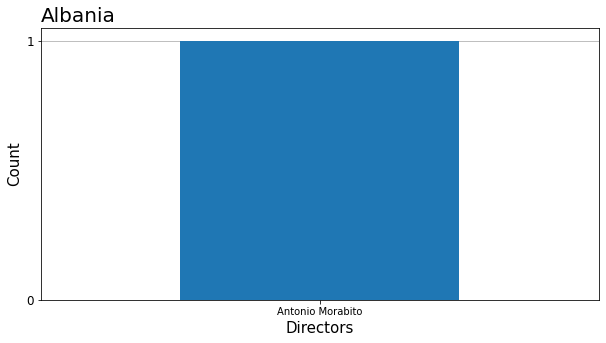

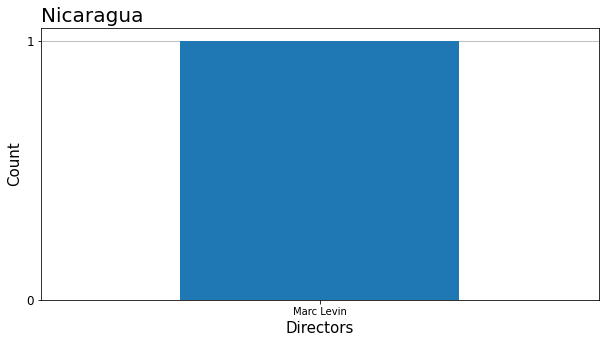

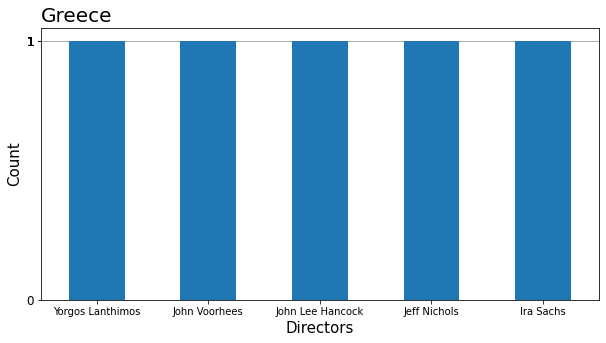

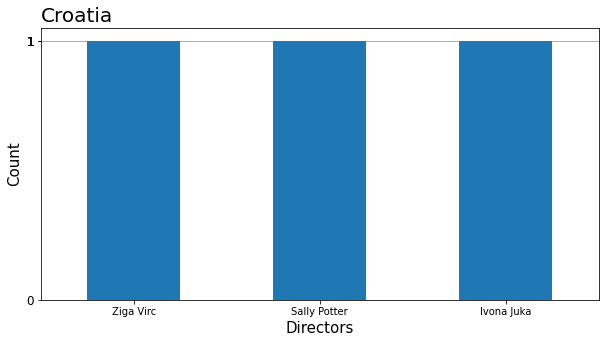

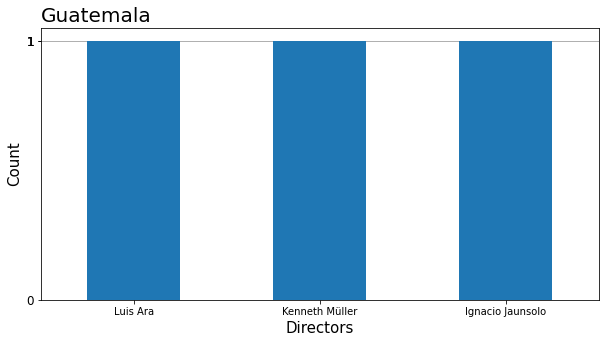

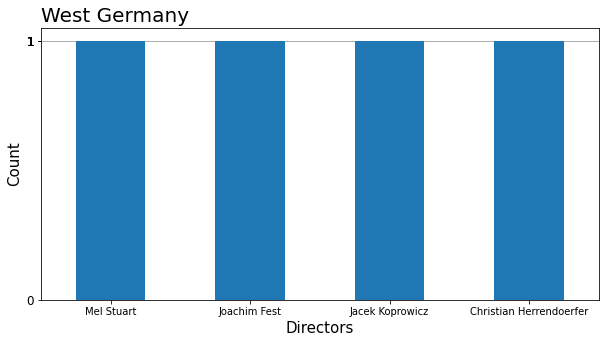

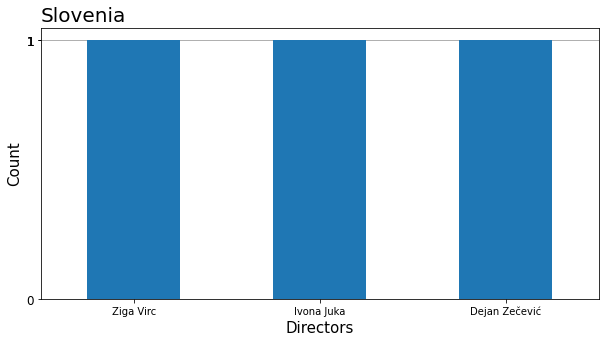

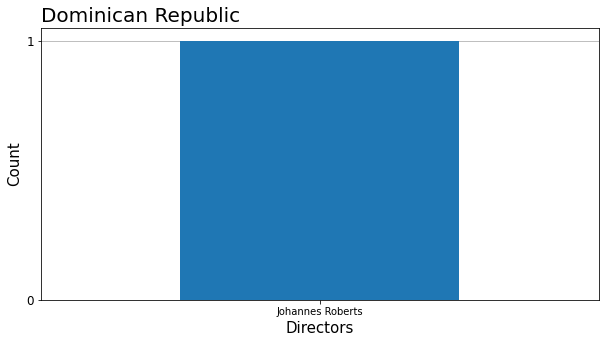

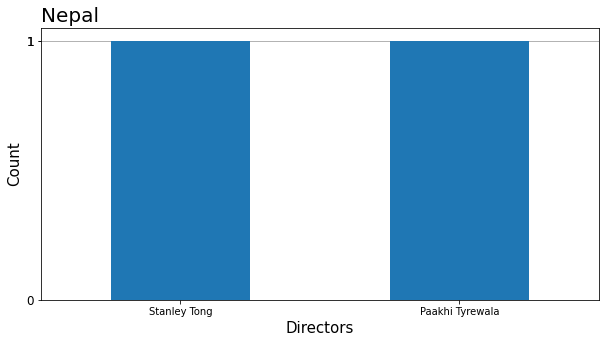

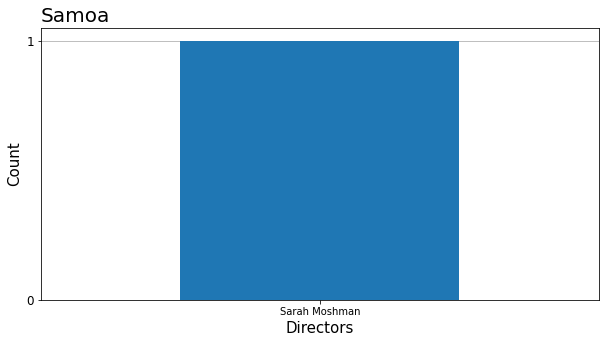

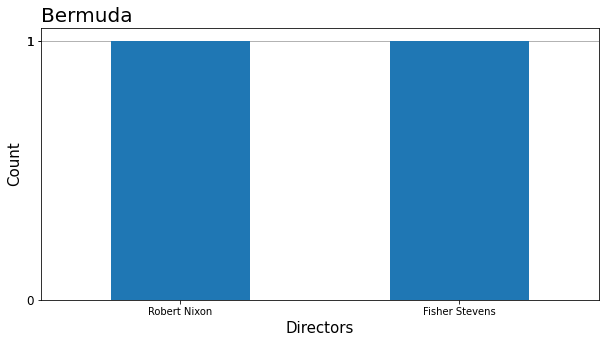

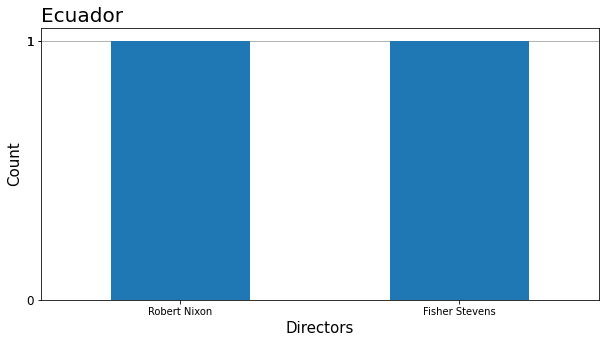

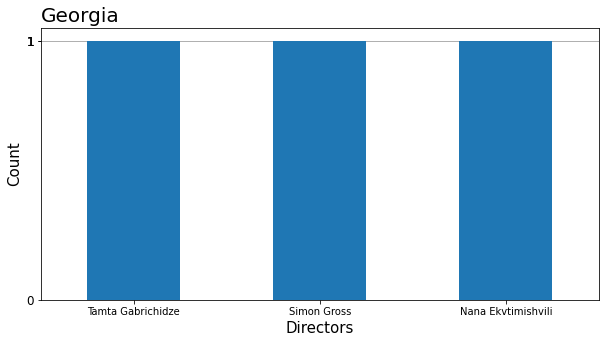

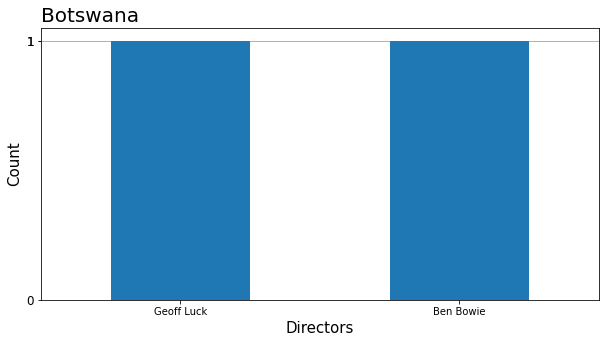

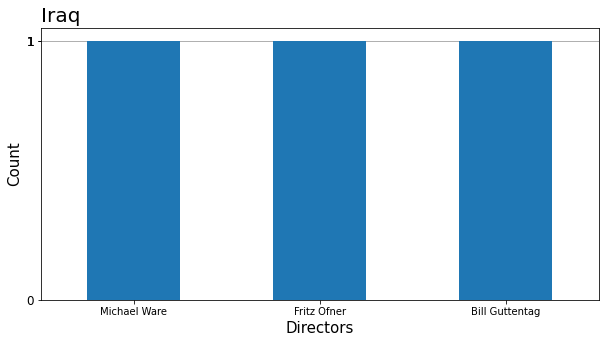

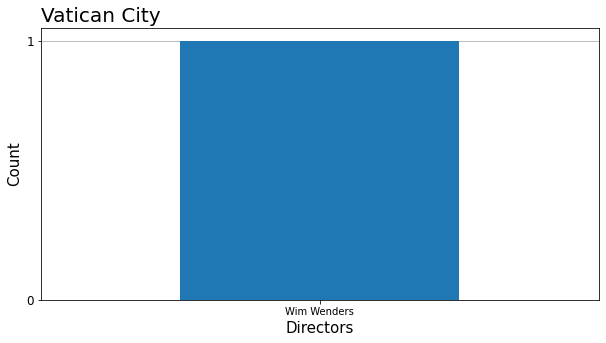

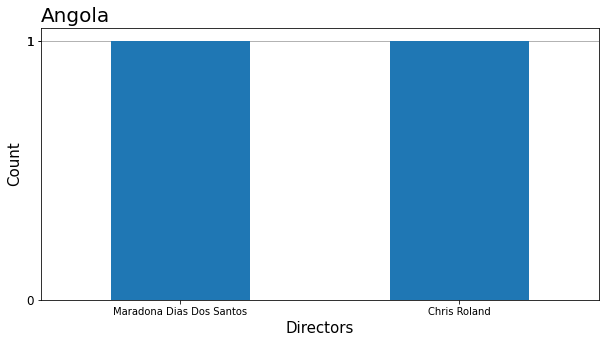

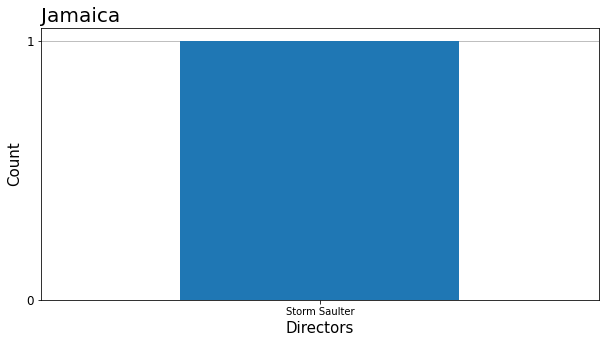

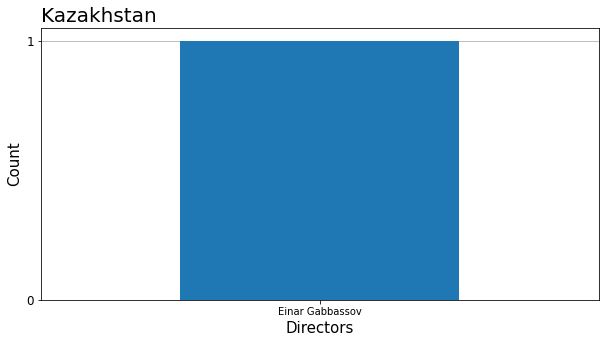

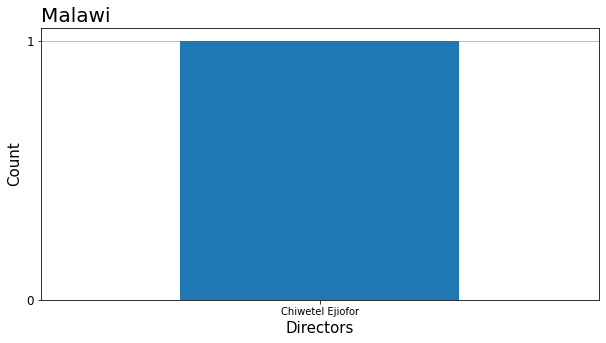

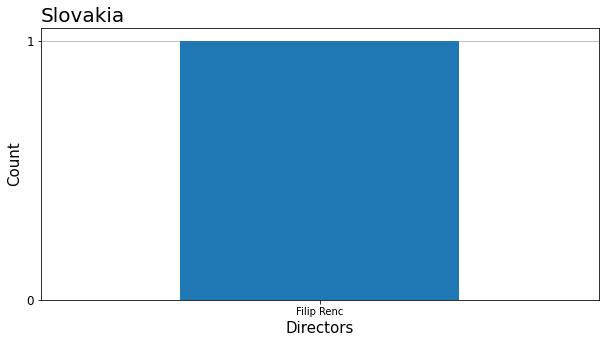

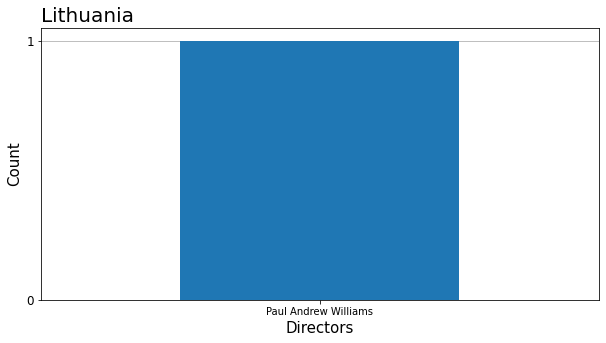

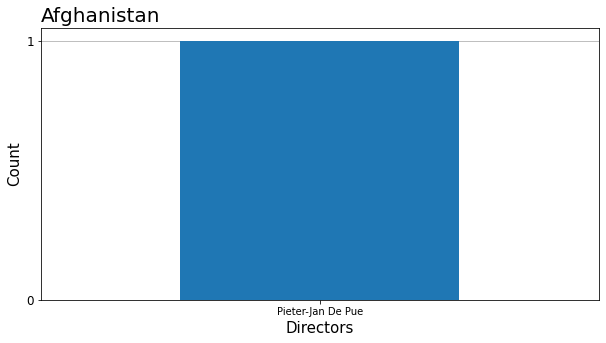

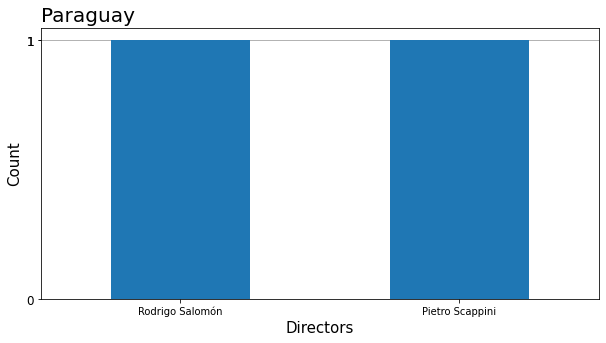

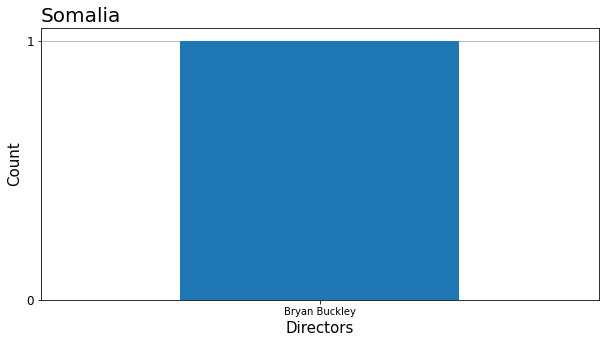

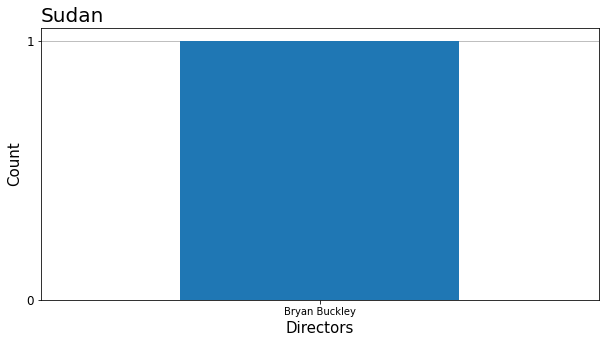

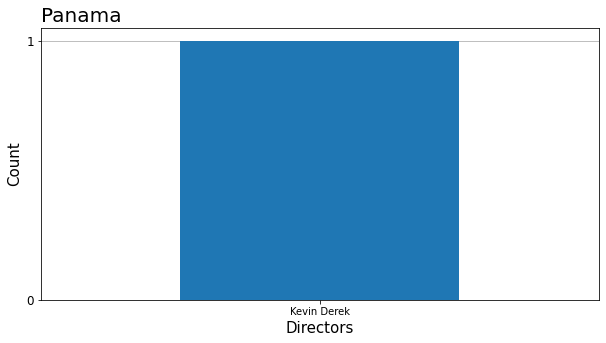

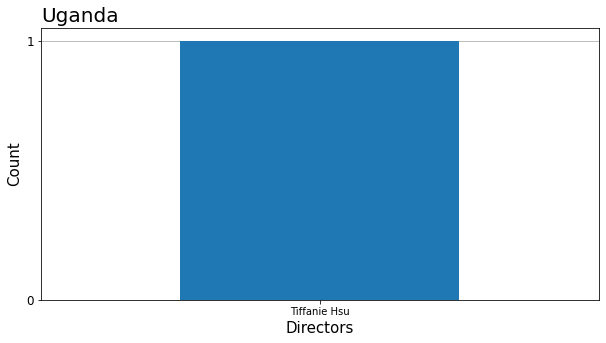

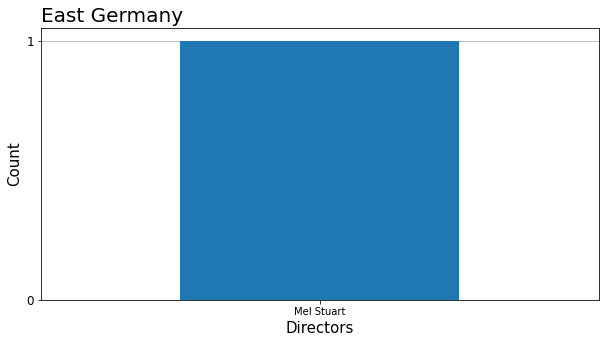

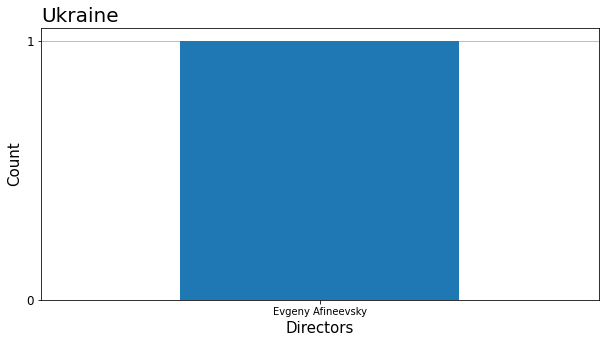

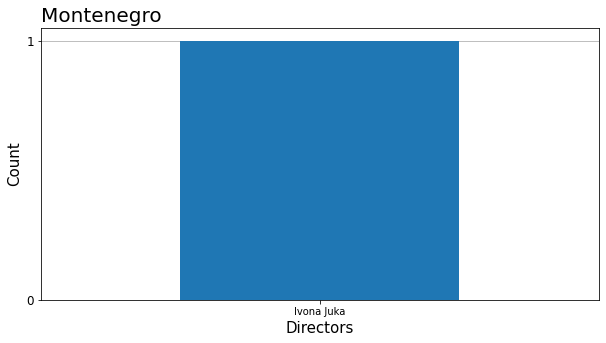

In [51]:
#Η διαδικασία παρακάτω είναι ίδια με αυτή του ερωτήματος 5,
#με μόνη διαφορά ότι αναζητάμε βάσει σκηνοθέτη και δε μας ενδιαφέρει αν είναι ταινία ή σειρά
#Εδώ πάλι επιλέξαμε να εμφανίσουμε τους top 5 σκηνοθέτες. Ο αριθμός των σκηνοθετών
#που εμφανίζονται αλλάζει εύκολα αν απλώς αλλάξουμε το νούμερο στο iloc του sorted series.

tmp9 = netflix.dropna(axis=0,subset=['country', 'director'])
tmp9 = split_df_rows(tmp9,'country')
tmp9 = split_df_rows(tmp9,'director')
country_whole = tmp9['country'].unique()

for x in country_whole:

    df9 = tmp9.loc[tmp9['country']==x]
    directors = df9.groupby('director')
    num_directors = directors['show_id'].nunique()
    
    sorted = num_directors.sort_values(ascending=False)
    s = sorted.iloc[:5]
    ylen9 = [0]
    for i in s:
        ylen9.append(i)
    
    ax = s.plot.bar(rot=0, figsize=(10,5),zorder=3)
    plt.ylabel('Count', fontsize=15)
    plt.xlabel('Directors', fontsize=15)
    plt.title(x, fontsize=20, loc='left')
    ax.set_yticks(ylen9)
    ax.yaxis.grid(True)
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.show()

**Ερώτημα 10:**
*Μελετήστε τις σειρές και παρουσιάστε ένα γράφημα που τις δείχνει ανάλογα με το
αριθμό των seasons*

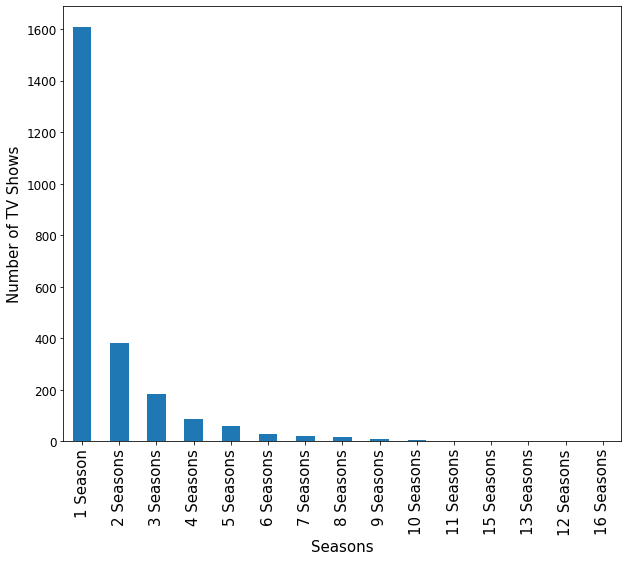

In [52]:
#Αναζήτηση πλήθους μοναδικών σειρών ομαδοποιημένες βάσει του αριθμό των season τους
shows10 = netflix.loc[netflix['type']=='TV Show']
durations10 = shows10.groupby('duration')
num_seasons10 = durations10['show_id'].nunique()

#Ταξινόμηση απο το μεγαλύτερο προς το μικρότερο
sorting = num_seasons10.sort_values(ascending=False)
sorting.plot.bar(figsize=(10,8))

plt.xlabel('Seasons', fontsize=15)
plt.ylabel('Number of TV Shows', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

**Ερώτημα 11:**
*Αξιοποιήστε τα υπόλοιπα αρχεία της εργασίας για να απαντήσετε στο ερώτημα:
Ποιές είναι οι ταινίες με την πιο υψηλή βαθμολογία; Θα χρειαστεί να συννενώσετε
κατάλληλα τα αρχεία που σας δίνονται ώστε να κρατήσετε τις ταινίες του netflix για
τις οποίες υπάρχουν ratings στο IMBD.*

Σε αυτό το ερώτημα επιλέξαμε να εμφανίσουμε μόνο τις 10 καλύτερες ταινίες. Ο αριθμός των καλύτερων ταινιών που εμφανίζονται αλλάζει εύκολα αν απλώς αλλάξουμε το νούμερο στο iloc του sorted series.

In [53]:
#Αναζήτηση όλων των ταινιών που έχουν βαθμολογία

nmovies11 = netflix.loc[netflix['type']=='Movie']
votes11 = imdb_movies.dropna(axis=0,subset=['avg_vote'])
title11 = nmovies11['title'].unique()

d11 = {}

#Για κάθε ταινία: αναζήτηση του τίτλου της στο imdb
#και αν υπάρχει, αποθήκευση της βαθμολογίας της
for x in title11:
    movie11 = votes11.loc[votes11['title']==x]
    if len(movie11.index)!= 0:
        d11[x] = movie11.iat[0,14]

#Ταξινόμηση και εμφάνιση των 10 ταινιών με την πιο υψηλή βαθμολογία
s11 = pd.Series(d11)
sort11 = s11.sort_values(ascending=False)

topMovies = sort11.iloc[:10]

print("Οι ταινίες με την υψηλότερη βαθμολογία είναι: ")
for i, j in topMovies.iteritems():
    print(i, ":", j)

Οι ταινίες με την υψηλότερη βαθμολογία είναι: 
Pulp Fiction : 8.9
Schindler's List : 8.9
Inception : 8.8
Oththa Seruppu Size 7 : 8.6
Eh Janam Tumhare Lekhe : 8.6
Gol Maal : 8.6
Ani... Dr. Kashinath Ghanekar : 8.6
Koshish : 8.6
City of God : 8.6
American History X : 8.5


#Β. Recommendation system

**Ερώτημα 1:**
*Θα δημιουργήσετε 2 διαφορετικά representations για κάθε ταινία, βασιζόμενοι στις
περιγραφές που περιέχονται στις παραπάνω στήλες:
a. Δημιουργήστε το boolean BoW πίνακα των unigrams και των bigrams από τη
κειμενική αναπαράσταση των ταινιών. (χρησιμοποιήστε την παράμετρο
ngram_range του CountVectorizer).
b. Δημιουργήστε τον TF-IDF (Term Frequency - Inverse Document Frequency)
πίνακα των unigrams και των bigrams από τη κειμενική αναπαράσταση των
ταινιών.Πειραματιστείτε με τις διάφορες παραμέτρους των vectorizers π.χ. max_df, min_df,
max_features, stopwords, για να πάρετε χρήσιμες αναπαραστάσεις.*

*Αρχικοποίηση*

*Για λόγους αποδοτικότητας και πολυπλοκότητας επιλέξαμε να εκτελέσουμε τα παρακάτω ερωτήματα με ένα μικρό κομμάτι των ταινιών του αρχικού DataFrame*

In [54]:
#Κρατήσαμε μόνο της ταινίες, κι απ' αυτές κρατήσαμε μόνο 1000 τυχαίες
moviesv2 = netflix.dropna(axis=0, subset=['show_id', 'title', 'description'])
moviesv2 = moviesv2.loc[moviesv2['type']=='Movie']

moviesv2['title_desc'] = moviesv2['title'] + ' ' + moviesv2['description']
moviesv2 = moviesv2.sample(frac=1).reset_index(drop=True)
moviesv2 = moviesv2.loc[:1000]

**a.**
*boolean BoW*

In [55]:
#Δημιουργία boolean BoW unigrams και bigrams με μέγιστο αριθμό features ίσο με 1000
#Βάλαμε stop words english για να φύγουν τα σημέια στίξης και για τις τιμές επιλέξαμε binary
#έτσι οι τιμές τους θα είναι διακριτές [0,1]
bowVector = CountVectorizer(ngram_range=(1,2), max_features=1000, stop_words='english', binary=True)

BoW = bowVector.fit_transform(moviesv2['title_desc'])
BoWarray = BoW.toarray()

**b.**
*TF-IDF*

In [56]:
#Δημιουργία tf-idf unigrams και bigrams με μέγιστο αριθμό features ίσο με 1000
tfidfVector = TfidfVectorizer(ngram_range=(1,2), max_features=1000, stop_words='english')

TFIDF = tfidfVector.fit_transform(moviesv2['title_desc'])

**Ερώτημα 2:**
*Χρησιμοποιώντας τις παραπάνω αναπαραστάσεις των ταινιών υπολογίστε την
ομοιότητα μεταξύ τους.
a. Για την αναπαράσταση από το 1.α, θα αξιοποιήσετε το Jaccard/Tanimoto
coefficient για να υπολογίσετε την ομοιότητα 2 ταινιών δοθέντων των feature
vectors τους.
b. Για την αναπαράσταση από το 1.β, θα αξιοποιήσετε το cosine similarity.Διατρέξτε τους πίνακες από το 1 και υπολογίστε τις ομοιότητες όλων των ταινιών μεταξύ
τους (και με τους δύο τρόπους 2.α, 2.β). Έπειτα αποθηκεύστε για κάθε ταινία τις 100 πιο
όμοιες με αυτή σε ένα python dictionary.*

**a.**
*Jaccard/Tanimoto*

In [57]:
#Κάθε γραμμή του πίνακα BoW αντιστοιχεί σε μια ταινία και τις τιμές των feature της
#Διατρέχουμε τον πίνακα γραμμή γραμμή και καλούμε την jaccard_score για όλες τις ταινίες μεταξύ τους
#Και δημιουργούμε ένα dictionary όπου κάθε ταινία έχει μια λίστα με tuples με πρώτο στοιχείο του tuple
#το όνομα της άλλης ταινίας και δεύτερο στοιχείο το similarity τους

jaccarDict = {}
for i in range(len(BoWarray)):
    title1 = moviesv2.iat[i,2]
    jaccarDict[title1] = []
    for j in range(len(BoWarray)):
        if i != j:
            jac_sim = jaccard_score(BoWarray[i], BoWarray[j], average='binary')
            title2 = moviesv2.iat[j,2]
            jaccarDict[title1].append((title2, jac_sim))

**b.**
*Cosine similarity*

In [58]:
#Εκτέλεση του cosine similarity για όλο το matrxi του tf-idf
#κάθε γραμμή που επιστρέφει αντιστοιχεί σε μια ταινία και τα 
#similarities της με τις υπόλοιπες.
#Αποθήκευση των αποτελεσμάτων όπως πάνω στη Jaccard

cos_sim = cosine_similarity(TFIDF, TFIDF)

cosDict = {}
for x in range(len(cos_sim)):
    title1 = moviesv2.iat[x,2]
    cosDict[title1] = []
    for y in range(len(cos_sim)):
        if x != y:
            title2 = moviesv2.iat[y,2]
            cosDict[title1].append((title2, cos_sim[x][y]))

*Top 100 Similar*

In [59]:
jaccard100 = {}
cosine100 = {}

#Για κάθε ταινία κάνουμε sort τη λίστα με τα tuples βάσει του δεύτερου στοιχείου που είναι το similarity
#και κρατάμε τις top 100 κάνοντας slice

for k in jaccarDict:
    jaccarDict[k].sort(reverse=True, key=lambda tup: tup[1])
    jaccard100[k] = jaccarDict[k][:100]
    
for m in cosDict:
    cosDict[m].sort(reverse=True, key=lambda tup: tup[1])
    cosine100[m] = cosDict[m][:100]

**Ερώτημα 3:**
*Πρόβλεψη (1): Φτιάξτε μία συνάρτηση η οποία παίρνει σαν είσοδο ένα τίτλο, ένα
ακέραιο αριθμό N και τον τρόπο εύρεσης της ομοιότητας (boolean ή tf-idf σύμφωνα
με τα 1,2) και επιστρέφει τους Ν πιο όμοιους τίτλους.
get_similar_movies1('Title_of_the_movie', N=10, method=’boolean’)*

In [60]:
#Έχουμε βάλει περιορισμό το Ν να είναι μικρότερο ή ίσο του 100.
#Ελέγχει την τιμή του αριθμού Ν, αν είναι οκ, ελέγχει τι μέθοδο έχει
#βάλει ο χρήστης και αν είναι boolean αναζητούμε τον τίτλο της ταινίας 
#στο dictionary με τα top100 της jaccard αλλιώς αν είναι tf-idf 
#αναζητούμε σε αυτό της cosine. Αν υπάρχει η ταινία (γιατί όπως έχουμε
#αναφέρει παραπάνω έχουμε χρησιμοποιήσει μόνο 1000 τυχαίες) εκτυπώνουμε 
#τις Ν πιο όμοιες ταινίες με αυτήν. Σε περίπτωση λάθους εκτυπώνουμε κατάλληλο
#μήνυμα.

def get_similar_movies1(title, N, method):
    if N <= 100:
        if method == 'boolean':
            if title in jaccard100:
                print("Οι", N, "πιο όμοιες ταινίες με την", title, "είναι:")
                for i in range(N):
                    print(jaccard100[title][i][0], jaccard100[title][i][1])
            else:
                print('Movie not available in DataSet')
        elif method == 'tf-idf':
            if title in cosine100:
                print("Οι", N, "πιο όμοιες ταινίες με την", title, "είναι:")
                for j in range(N):
                    print(cosine100[title][j][0], cosine100[title][j][1])
            else:
                print('Movie not available in DataSet')
        else:
            print('Unknown method')
    else:
        print('Please insert a number in range 0 to 100')

*Κλήση συνάρτησης για κάποιον τυχαίο τίτλο και εμφάνιση Ν όμοιων ταινιών και των similarities τους*

In [61]:
randMovie = moviesv2.iloc[random.randint(0,999)]

*Για boolean method:*

In [62]:
get_similar_movies1(randMovie['title'], 50, 'boolean')

Οι 50 πιο όμοιες ταινίες με την Tremors είναι:
Tall Girl 0.13333333333333333
17 Again 0.1111111111111111
Barbie: Princess Charm School 0.1
Unknown 0.1
Kuntilanak 0.09090909090909091
The Killer 0.08333333333333333
How High 2 0.08333333333333333
David Batra: Elefanten i rummet 0.08333333333333333
The NSU-Complex 0.08333333333333333
Tom Segura: Mostly Stories 0.08333333333333333
6 Underground 0.08333333333333333
Your Excellency 0.08333333333333333
Baby Dolls 0.07692307692307693
Perfect Stranger 0.07692307692307693
Kalek Shanab 0.07692307692307693
1898: Our Last Men in the Philippines 0.07692307692307693
Shark Night 0.07692307692307693
Daddy Issues 0.07692307692307693
All's Well, End's Well (2009) 0.07692307692307693
Get Santa 0.07692307692307693
Secrets of Westminster 0.07692307692307693
Whitney Cummings: Money Shot 0.07692307692307693
Yellowbird 0.07692307692307693
Justice, My Foot! 0.07142857142857142
Unexpectedly Yours 0.07142857142857142
ChuChuTV Bedtime Stories & Moral Stories for Ki

*Για tf-idf method*

In [63]:
get_similar_movies1(randMovie['title'], 50, 'tf-idf')

Οι 50 πιο όμοιες ταινίες με την Tremors είναι:
Tall Girl 0.30814926022812283
Unexpectedly Yours 0.18031351347316502
Justice, My Foot! 0.17794305903196292
Yellowbird 0.1737087153292484
The Hundred-Foot Journey 0.16736430778757144
Unknown 0.16706885524112464
Kuntilanak 0.16421759207661735
1898: Our Last Men in the Philippines 0.1627719132075734
Kocan Kadar Konus 0.15786978693023976
The Chord 0.1498526669934825
Just The Way You Are 0.1491150743340308
The Killer 0.1490000309960023
Shark Night 0.14353570270808097
Secrets of Westminster 0.14345721449695537
Daddy Issues 0.1429754281096383
Baby Dolls 0.136914973871507
Kalek Shanab 0.1355338549750065
Bangkok Traffic (Love) Story 0.1327584510566752
Double Dad 0.13101438289338938
A Secret Love 0.13075763970368992
Before I Wake 0.12849525217044735
Been So Long 0.1280975854615656
Justine 0.1270807346469819
How High 2 0.1231042961869669
All's Well, End's Well (2009) 0.1229692873320652
Struggle: The Life and Lost Art of Szukalski 0.12109360071887164


**Ερώτημα 4:** 
*Πρόβλεψη (2): Φτιάξτε μία συνάρτηση η οποία παίρνει σαν είσοδο μια ακολουθία
από λέξεις (π.χ. Περιγραφή μιας ταινίας), ένα ακέραιο αριθμό N και τον τρόπο
εύρεσης της ομοιότητας και επιστρέφει τους Ν πιο όμοιους τίτλους με βάση αυτή τη
περιγραφή. Το συγκεκριμένο σύστημα θα μετασχηματίζει τη περιγραφή της
εισόδου σε ένα feature vector, ανάλογα με την επιλεγμένη μεθοδολογία, και
χρησιμοποιώντας τους κατάλληλους πίνακες και μετρικά από τα 1,2 θα επιστρέφει
τις πιο σχετικές ταινίες.*

In [64]:
#Έχουμε βάλει περιορισμό το Ν να είναι μικρότερο ή ίσο του 100.
#Ελέγχει την τιμή του αριθμού Ν, αν είναι οκ, τότε παίρνει το dataframe 
#με τις 1000 ταινίες και βάζει μια επιπλέον γραμμή με μόνο στοιχείο την
#τιμή της description που δόθηκε ως όρισμα και τη βάζει στη στήλη title_desc
#ελέγχει τι μέθοδο έχει βάλει ο χρήστης και αν είναι boolean καλεί την jaccard_score 
#για αυτό το description με όλες τις υπόλοιπες ταινίες, ενώ αν είναι
#tf-idf καλέι την cosine αντίστοιχα. Βάζει τα αποτελέσματα σε μια λίστα
#με tuples όπου πρώτο στοιχείο είναι ο τίτλος της ταινίας και δεύτερο στοιχείο
#το similarity της με το δοθέν description. Ύστερα κάνουμε sort αυτή τη λίστα
#βάσει των similarities και εκτυπώνουμε τις Ν πιο όμοιες ταινίες. Σε περίπτωση 
#λάθους εκτυπώνουμε κατάλληλο μήνυμα.

def get_similar_movies2(description, N, method):
    if N <= 100:
        
        copyDF = moviesv2.copy()
        testDF = pd.DataFrame([description], columns=['title_desc'])
        copyDF = copyDF.append(testDF, ignore_index=True)

        if method == 'boolean':

            tempVector = CountVectorizer(ngram_range=(1,2), max_features=1000, stop_words='english', binary=True)
            tempBoW = tempVector.fit_transform(copyDF['title_desc'])
            tempBoWarray = tempBoW.toarray()
            topN = []
            pos = len(tempBoWarray) - 1
            
            for i in range(pos):
                jac_sim = jaccard_score(tempBoWarray[pos], tempBoWarray[i], average='binary')
                title2 = copyDF.iat[i,2]
                topN.append((title2, jac_sim))

            topN.sort(reverse=True, key=lambda tup: tup[1])

            print("Οι", N, "πιο όμοιες ταινίες για", description, "είναι:")
            for j in range(N):
                print(topN[j][0], topN[j][1])

        elif method == 'tf-idf':
            
            tempVector = TfidfVectorizer(ngram_range=(1,2), max_features=1000, stop_words='english')
            tempTFIDF = tempVector.fit_transform(copyDF['title_desc'])

            tempCos = cosine_similarity(tempTFIDF, tempTFIDF)
            topN = []
            pos = len(tempCos) - 1
            for i in range(pos):
                title2 = copyDF.iat[i,2]
                topN.append((title2, tempCos[pos][i]))

            topN.sort(reverse=True, key=lambda tup: tup[1])

            print("Οι", N, "πιο όμοιες ταινίες για", description, "είναι:")
            for j in range(N):
                print(topN[j][0], topN[j][1])
                
        else:
            print('Unknown method')
    else:
        print('Please insert a number in range 0 to 100')

*Εκτέλεση όπως φαίνεται στην εκφώνηση*

In [65]:
get_similar_movies2('War between America and Vietnam', 20, 'boolean')

Οι 20 πιο όμοιες ταινίες για War between America and Vietnam είναι:
An Interview with God 0.16666666666666666
Iliza Shlesinger: War Paint 0.16666666666666666
War Chhod Na Yaar 0.14285714285714285
The Surrounding Game 0.14285714285714285
Love Is War 0.14285714285714285
War Machine 0.125
Class of '61 0.125
BuyBust 0.125
Avengers: Infinity War 0.125
Bright 0.125
Resurface 0.125
Iron Man & Captain America: Heroes United 0.125
All In My Family 0.125
The Women's Balcony 0.1111111111111111
Gad Elmaleh: American Dream 0.1111111111111111
War Horse 0.1
Kraftidioten 0.1
Tim Allen: ReWires America 0.1
Ginger & Rosa 0.1
At All Costs 0.1


In [66]:
get_similar_movies2('War between America and Vietnam', 20, 'tf-idf')

Οι 20 πιο όμοιες ταινίες για War between America and Vietnam είναι:
Judah Friedlander: America Is the Greatest Country in the United States 0.43326922088429465
War Machine 0.39089335662961816
War Chhod Na Yaar 0.3716515080603517
Iron Man & Captain America: Heroes United 0.32794425399872756
The Last Bomb of the Second World War 0.3209821796600038
War Horse 0.2980153078782164
Iliza Shlesinger: War Paint 0.2945206985660767
Gad Elmaleh: American Dream 0.2753604340562872
The Surrounding Game 0.2672849442555523
An Interview with God 0.26340703281196703
At All Costs 0.257605456600494
Love Is War 0.2574907118062333
BuyBust 0.2335808785674736
Bright 0.2325784251492473
All In My Family 0.2218734310060718
Sprinter 0.21701568128657564
Avengers: Infinity War 0.21633664735247585
Umrika 0.21609378953329703
Marvel & ESPN Films Present: 1 of 1: Genesis 0.2129847563741269
Resurface 0.20905942257650467


Και ένα τυχαίο description

In [35]:
get_similar_movies2('In search of happiness', 35, 'boolean')

Οι 35 πιο όμοιες ταινίες για In search of happiness είναι:
Zozo 0.14285714285714285
Under The Skin 0.14285714285714285
Chippa 0.125
Minimalism: A Documentary About the Important Things 0.125
NOVA: Killer Floods 0.1111111111111111
The Forest 0.1
Paharganj 0.1
Shine Your Eyes 0.09090909090909091
For the Broken Hearted 0.09090909090909091
Brain on Fire 0.08333333333333333
Project Papa 0.08333333333333333
Anjaan 0.07692307692307693
Balto 2: Wolf Quest 0.07692307692307693
Tread 0.0
Alibaba Aur 40 Chor 0.0
Get Me Roger Stone 0.0
Lorai: Play to Live 0.0
Autohead 0.0
Alakada Reloaded 0.0
The Rover 0.0
Sandy Wexler 0.0
Grand-Daddy Day Care 0.0
Babam ve Oğlum 0.0
The Rift: The Dark Side of the Moon 0.0
A Christmas Prince: The Royal Baby 0.0
The Edge of Democracy 0.0
Before I Fall 0.0
The Royal Bengal Tiger 0.0
PK 0.0
The Lift Boy 0.0
Thottappan 0.0
No Longer kids 0.0
The Age of Shadows 0.0
John Mulaney & The Sack Lunch Bunch 0.0
Ghayal 0.0


In [36]:
get_similar_movies2('In search of happiness', 35, 'tf-idf')

Οι 35 πιο όμοιες ταινίες για In search of happiness είναι:
Zozo 0.2833943969797099
For the Broken Hearted 0.27294875669650775
Project Papa 0.26665036916595436
Minimalism: A Documentary About the Important Things 0.25901753285595264
Under The Skin 0.25791065444594385
NOVA: Killer Floods 0.24740854774645957
The Forest 0.22210426763272467
Chippa 0.21876315144426797
Shine Your Eyes 0.21309081505496144
Paharganj 0.21079321573642004
Anjaan 0.1982875033258412
Brain on Fire 0.171409294765024
Balto 2: Wolf Quest 0.11164912614320802
Tread 0.0
Alibaba Aur 40 Chor 0.0
Get Me Roger Stone 0.0
Lorai: Play to Live 0.0
Autohead 0.0
Alakada Reloaded 0.0
The Rover 0.0
Sandy Wexler 0.0
Grand-Daddy Day Care 0.0
Babam ve Oğlum 0.0
The Rift: The Dark Side of the Moon 0.0
A Christmas Prince: The Royal Baby 0.0
The Edge of Democracy 0.0
Before I Fall 0.0
The Royal Bengal Tiger 0.0
PK 0.0
The Lift Boy 0.0
Thottappan 0.0
No Longer kids 0.0
The Age of Shadows 0.0
John Mulaney & The Sack Lunch Bunch 0.0
Ghayal 0.0

Παρατηρώντας τα αποτελέσματα παραπάνω και τους χρόνους εκτέλεσης, φαίνεται ότι στη συγκεκριμένη περίπτωση (με τα νούμερα που έχουμε δώσει και τον τρόπο εκτέλεσης που έχουμε επιλέξει) η cosine similarity είναι πολύ πιο γρήγορη από την jaccard. Επίσης παρατηρούμε ότι, η cosine βρίσκει τιμές για τα similarities περίπου 0.1 παραπάνω απ' ότι η jaccard για τις ίδιες ταινίες. Ρίχνοντας μια ματιά στα descriptions των ταινιών που εμφανίζονται ως πιο όμοιες, συμπεραίνουμε ότι τα αποτελέσματα δεν είναι και τόσο ακριβή. Π.χ. όπως φαίνεται παραπάνω αναζητήσαμε "In search of happiness" και μας εμφάνισε το Zozo (αν ξανατρέξουμε τα dataframe και vectorizers αυτό μπορεί να αλλάξει επειδή θα έχουμε 1000 καινούριες τυχαίες ταινίες) που έχει στην περιγραφή του "in search of his grandparents", το οποίο δε σημαίνει ότι έκανε λάθος ο αλγόριθμος αλλά ότι μπορεί μεν οι λέξεις να ταιριάζουν, όμως το νόημα είναι τελείως διαφορετικό. Αυτό οφείλεται στον αριθμό των ταινιών που ελέγξαμε (στην περίπτωση μας 1000 -τυχάιες κάθε φορά- ταινίες από το Netflix) και στο μέγιστο αριθμό features (1000) που επιλέξαμε, διότι ο αλγόριθμος δε βρίσκει κάποια ταινία που να είναι αρκετά όμοια με αυτή που ζητάμε απλά βρίσκει εκείνες τις ταινίες που έχουν τις ίδιες λέξεις στο description ή στο title τους, διαφορετικά όμως δε θα τελείωνε ποτέ η εκτέλεση. Άμα κάναμε αναζήτηση σε ολόκληρο το dataframe ή ακόμα καλύτερα σε ένα τεράστιο database από εκατοντάδες χιλιάδες ταινίες ανά τον κόσμο, θα βρίσκαμε πιο αντιπροσωπευτικά και ακριβή αποτελέσματα.